# Projet : Système de Segmentation de Produits et Recommandation Retail

## Contexte du Projet

Développement d'un système de segmentation et de recommandation de produits dans le secteur du retail fashion. Le projet vise à analyser les ventes, les stocks, les remises, et les attributs produits pour générer des recommandations commerciales et identifier des segments exploitables (meilleures ventes, ventes lentes, collections limitées, promotions).

## Objectifs Pédagogiques

• Développer un pipeline de data science complet pour la segmentation des produits

• Automatiser l'extraction et le traitement des données produits et ventes

• Expérimenter différentes méthodes de clustering non supervisé pour identifier les segments

• Calculer des scores de promotion basés sur stock, vitesse de vente, marge et retour

• Visualiser les segments et recommandations via dashboard interactif

Auteur: Ikram Khemiri

Date: 13/11/2025


## PARTIE 1: IMPORT DES LIBRAIRIES

In [13]:

import os
import re
import ast
import math
import warnings
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer

# Optionnel (installer si besoin)
try:
    import umap
except Exception:
    umap = None

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11

# Affichage complet de DataFrame si besoin
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


## PARTIE 2: CHARGEMENT ET EXPLORATION

In [14]:
df = pd.read_csv("retail_data.csv")

 1. Premières lignes


In [15]:
df.head()

customer_id  age  gender income_bracket loyalty_program  membership_years  \
0            1   56   Other           High              No                 0   
1            2   69  Female         Medium              No                 2   
2            3   46  Female            Low              No                 5   
3            4   32  Female            Low              No                 0   
4            5   60  Female            Low             Yes                 7   

  churned marital_status  number_of_children education_level     occupation  \
0      No       Divorced                   3      Bachelor's  Self-Employed   
1      No        Married                   2             PhD     Unemployed   
2      No        Married                   3      Bachelor's  Self-Employed   
3      No       Divorced                   2        Master's       Employed   
4     Yes       Divorced                   2      Bachelor's       Employed   

   transaction_id     transaction_date  product_id product_category  quantity  \
0          503290  2020-10-11 10:08:52        1480      Electronics         8   
1          347796  2021-12-08 01:07:40        1597        Groceries         7   
2          493688  2020-02-17 09:40:48        5142             Toys         8   
3          861348  2020-08-13 00:43:14        8447             Toys         2   
4          535835  2021-07-02 11:59:03        6025         Clothing         4   

   unit_price  discount_applied  payment_method store_location  \
0       49.72              0.50     Credit Card     Location A   
1      817.76              0.32     Credit Card     Location C   
2      270.30              0.35      Debit Card     Location A   
3      547.84              0.10     Credit Card     Location A   
4      785.29              0.17  Mobile Payment     Location C   

   transaction_hour day_of_week  week_of_year  month_of_year  \
0                18   Wednesday            27              7   
1                15      Friday            20              2   
2                 9    Saturday            35              6   
3                13      Friday            42              8   
4                17      Monday            37              3   

   avg_purchase_value purchase_frequency   last_purchase_date  \
0              411.13             Weekly  2021-09-11 04:22:38   
1              268.71              Daily  2021-05-16 12:01:16   
2              246.79             Weekly  2021-02-07 16:47:48   
3              178.92             Weekly  2021-12-30 23:48:26   
4              214.06             Yearly  2021-11-02 11:48:25   

   avg_discount_used preferred_store  online_purchases  in_store_purchases  \
0               0.02      Location A                55                  86   
1               0.33      Location C                48                   2   
2               0.47      Location B                16                  45   
3               0.41      Location B                50                  47   
4               0.22      Location B                48                  42   

   avg_items_per_transaction  avg_transaction_value  total_returned_items  \
0                       8.64                 171.83                     0   
1                       9.60                  20.18                     4   
2                       1.55                  55.17                     0   
3                       1.78                  15.79                     3   
4                       9.38                 240.03                     2   

   total_returned_value  total_sales  total_transactions  \
0                750.40       563.16                  69   
1                551.60      7554.57                   8   
2                629.19      7564.14                  73   
3                346.67      8125.92                  20   
4                979.91       114.32                  83   

   total_items_purchased  total_discounts_received  avg_spent_per_category  \
0               

2. Dimensions


In [16]:
print(f"Dimensions: {df.shape[0]} lignes, {df.shape[1]} colonnes")


Dimensions: 1000000 lignes, 78 colonnes


3. Types de données

In [17]:
print(df.dtypes)

customer_id                    int64
age                            int64
gender                        object
income_bracket                object
loyalty_program               object
membership_years               int64
churned                       object
marital_status                object
number_of_children             int64
education_level               object
occupation                    object
transaction_id                 int64
transaction_date              object
product_id                     int64
product_category              object
quantity                       int64
unit_price                   float64
discount_applied             float64
payment_method                object
store_location                object
transaction_hour               int64
day_of_week                   object
week_of_year                   int64
month_of_year                  int64
avg_purchase_value           float64
purchase_frequency            object
last_purchase_date            object
a

 4. Informations détaillées

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   customer_id                1000000 non-null  int64  
 1   age                        1000000 non-null  int64  
 2   gender                     1000000 non-null  object 
 3   income_bracket             1000000 non-null  object 
 4   loyalty_program            1000000 non-null  object 
 5   membership_years           1000000 non-null  int64  
 6   churned                    1000000 non-null  object 
 7   marital_status             1000000 non-null  object 
 8   number_of_children         1000000 non-null  int64  
 9   education_level            1000000 non-null  object 
 10  occupation                 1000000 non-null  object 
 11  transaction_id             1000000 non-null  int64  
 12  transaction_date           1000000 non-null  object 
 13  product_id   

5. Analyse CRITIQUE des doublons et clients/produits uniques

In [19]:
print(f"\n=== ANALYSE DES ENTITÉS UNIQUES ===")
n_clients_uniques = df['customer_id'].nunique()
n_produits_uniques = df['product_id'].nunique()
print(f" Clients uniques: {n_clients_uniques}")
print(f" Produits uniques: {n_produits_uniques}")
print(f"Transactions par client: {len(df)/n_clients_uniques:.1f}")
print(f" Transactions par produit: {len(df)/n_produits_uniques:.1f}")


=== ANALYSE DES ENTITÉS UNIQUES ===
 Clients uniques: 1000000
 Produits uniques: 9999
Transactions par client: 1.0
 Transactions par produit: 100.0


## PARTIE 3: ANALYSE STATISTIQUE

1. Description statistique descriptive

In [20]:
df.describe()


customer_id             age  membership_years  number_of_children  \
count  1000000.000000  1000000.000000    1000000.000000      1000000.000000   
mean    500000.500000       48.496605          4.497453            2.000554   
std     288675.278932       17.874381          2.872406            1.414214   
min          1.000000       18.000000          0.000000            0.000000   
25%     250000.750000       33.000000          2.000000            1.000000   
50%     500000.500000       49.000000          4.000000            2.000000   
75%     750000.250000       64.000000          7.000000            3.000000   
max    1000000.000000       79.000000          9.000000            4.000000   

       transaction_id      product_id        quantity      unit_price  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean    499891.731447     4999.564515        5.002649      500.261317   
std     288706.057652     2886.798391        2.583751      288.462860   
min          2.000000        1.000000        1.000000        1.000000   
25%     249878.750000     2498.000000        3.000000      250.310000   
50%     499559.500000     4999.000000        5.000000      500.410000   
75%     750071.250000     7498.000000        7.000000      750.160000   
max     999999.000000     9999.000000        9.000000     1000.000000   

       discount_applied  transaction_hour    week_of_year   month_of_year  \
count    1000000.000000    1000000.000000  1000000.000000  1000000.000000   
mean           0.249910         11.505193       26.503691        6.497467   
std            0.144328          6.924460       15.005165        3.455212   
min            0.000000          0.000000        1.000000        1.000000   
25%            0.130000          5.000000       14.000000        3.000000   
50%            0.250000         12.000000       27.000000        7.000000   
75%            0.370000         18.000000       39.000000       10.000000   
max            0.500000         23.000000       52.000000       12.000000   

       avg_purchase_value  avg_discount_used  online_purchases  \
count      1000000.000000     1000000.000000    1000000.000000   
mean           254.886444           0.250010         49.446018   
std            141.494923           0.144383         28.861439   
min             10.000000           0.000000          0.000000   
25%            132.220000           0.130000         24.000000   
50%            254.930000           0.250000         49.000000   
75%            377.350000           0.380000         74.000000   
max            500.000000           0.500000         99.000000   

       in_store_purchases  avg_items_per_transaction  avg_transaction_value  \
count      1000000.000000             1000000.000000         1000000.000000   
mean            49.484486                   5.503122             255.115768   
std             28.882712                   2.597661             141.430014   
min              0.000000                   1.000000              10.000000   
25%             24.000000                   3.260000             132.510000   
50%             49.000000                   5.500000             255.230000   
75%             75.000000                   7.750000             377.670000   
max             99.000000                  10.000000             500.000000   

       total_returned_items  total_returned_value     total_sales  \
count        1000000.000000        1000000.000000  1000000.000000   
mean               4.498142            500.387837     5056.059765   
std                2.872805            288.717476     2859.100058   
min                0.000000              0.000000      100.010000   
25%                2.000000            250.630000     2577.867500   
50%                4.000000            500.400000     5059.695000   
75%                7.000000            750.390000     7534.802500   
max                9.000000           1000.000000     9999.980000   

       total_tran

2.Analyse des variables numériques

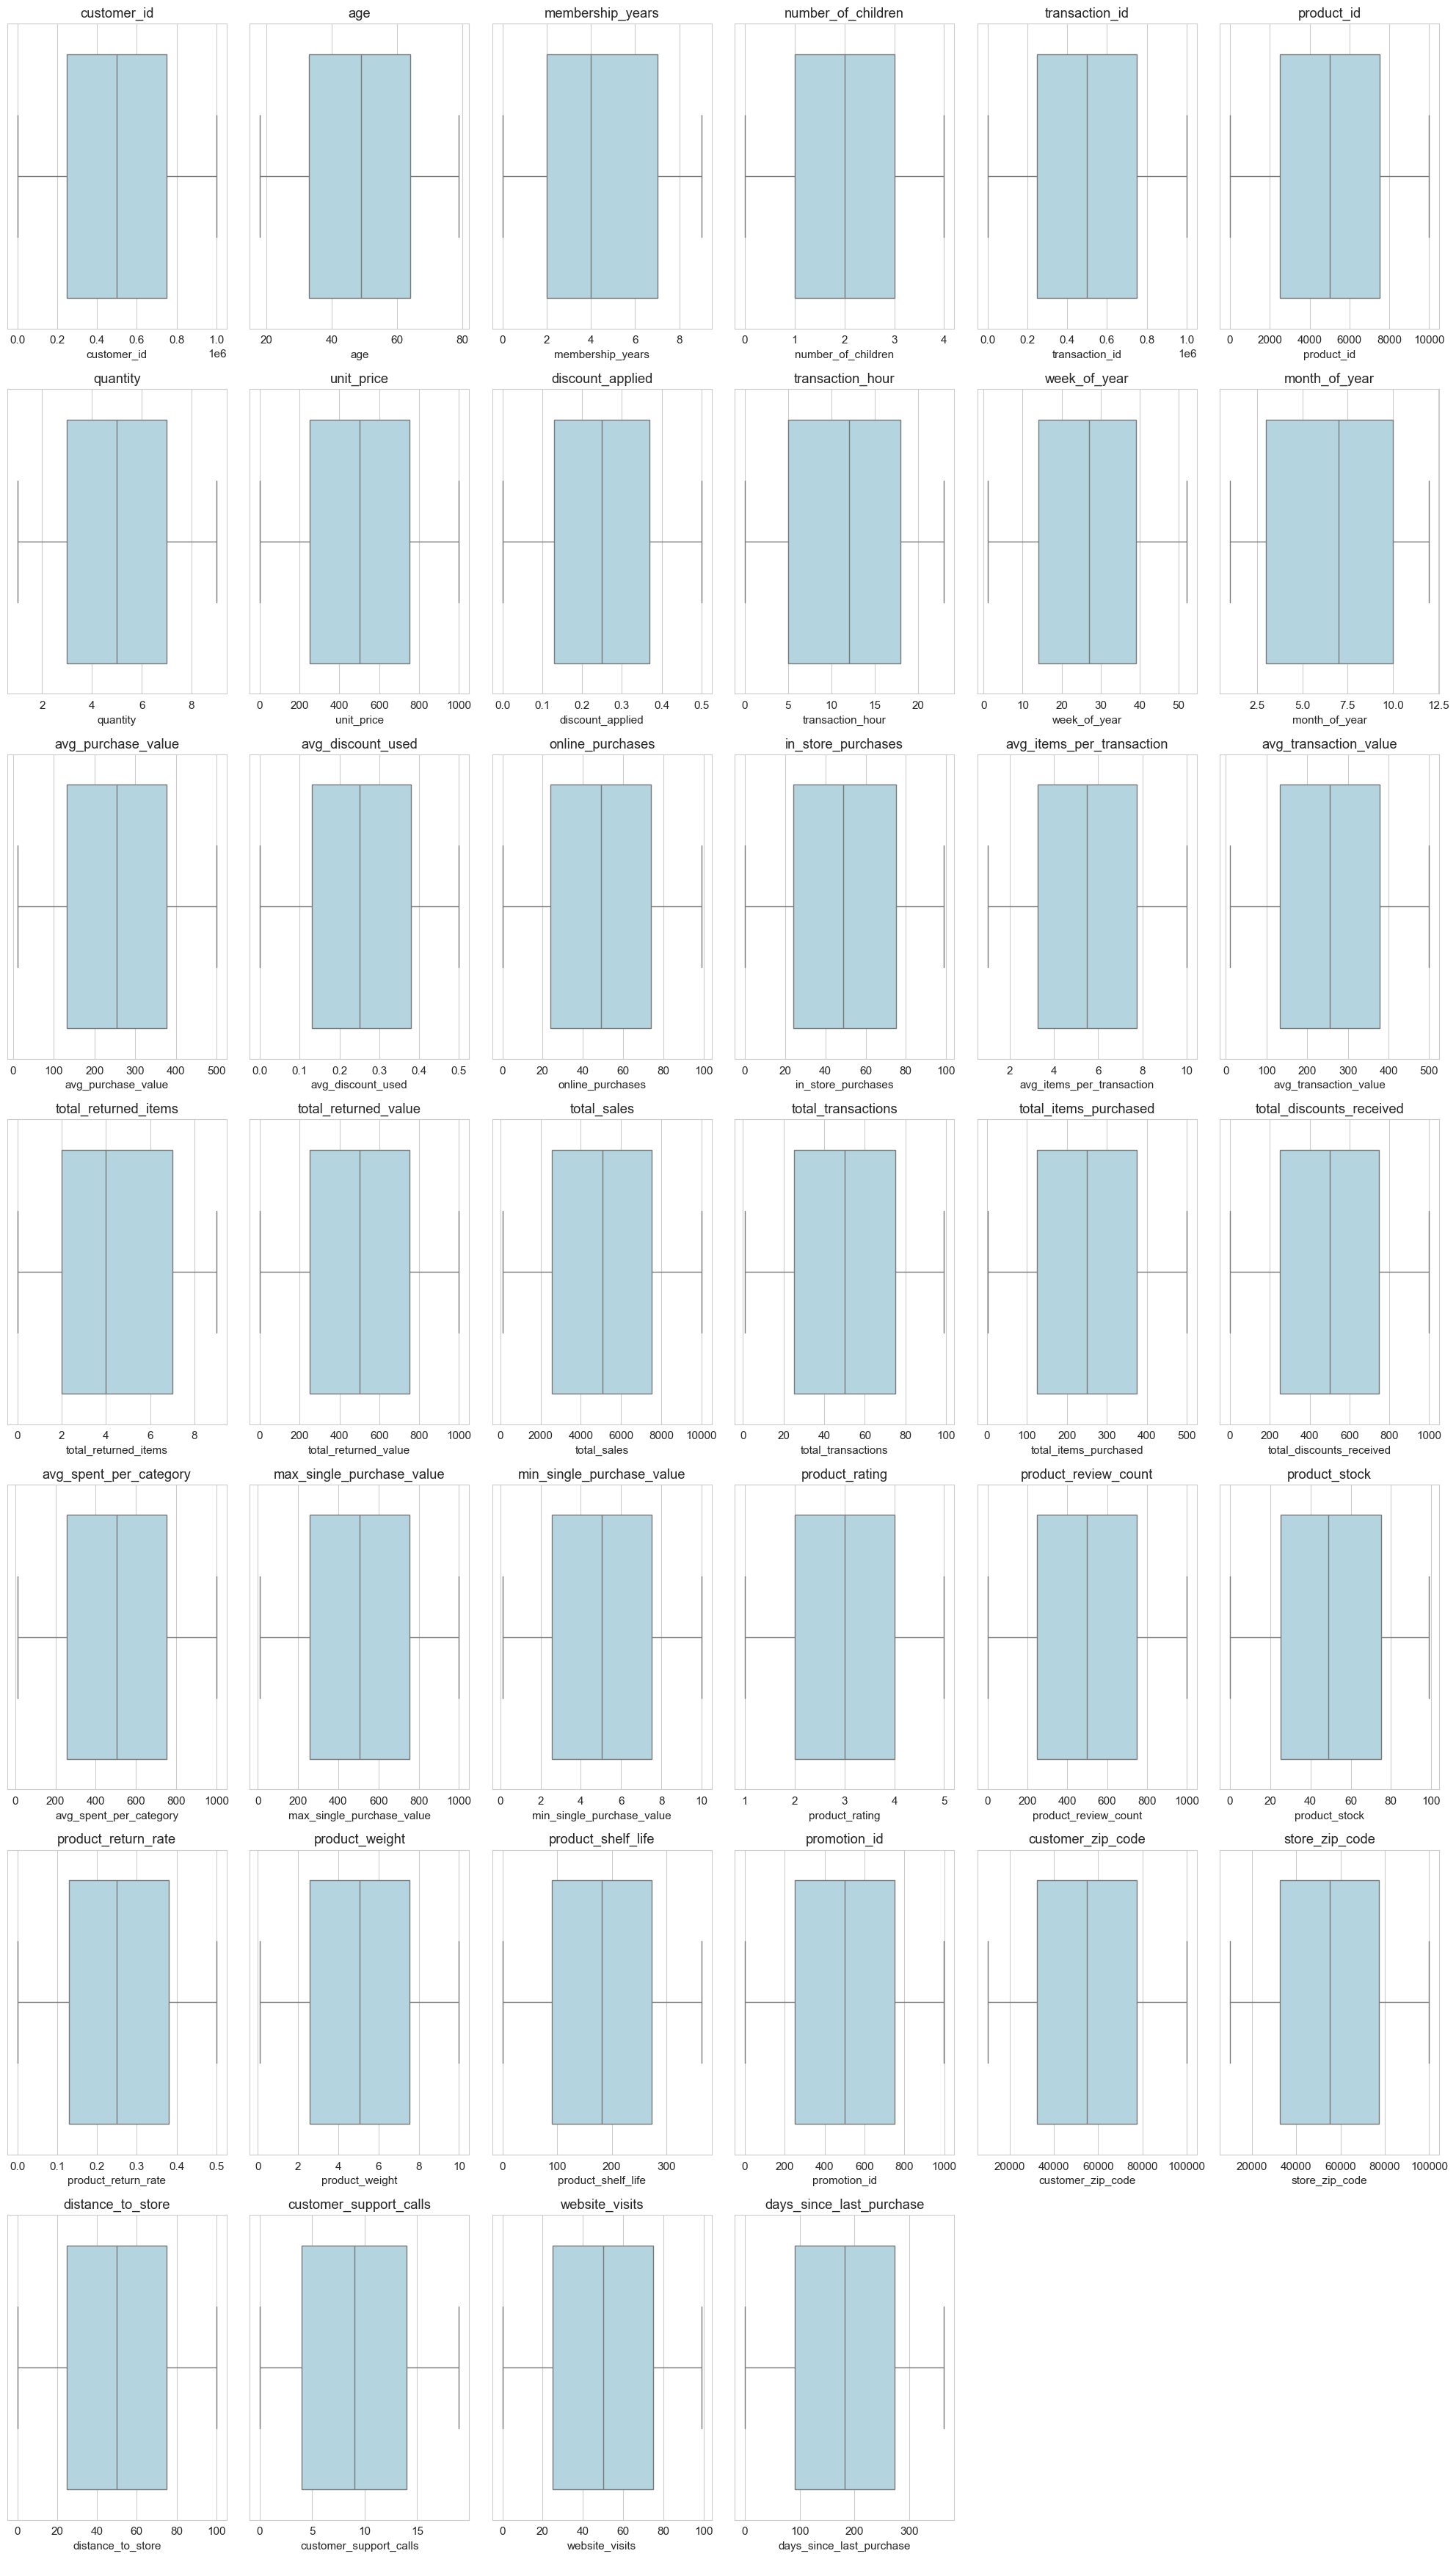

In [21]:
num_cols = df.select_dtypes(include='number').columns

# choose number of columns for the subplot grid (adjustable)
n_cols = 6
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(20, 5 * n_rows))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(col)

# hide any empty subplots if grid has more slots than variables
total_slots = n_rows * n_cols
if total_slots > len(num_cols):
    for j in range(len(num_cols) + 1, total_slots + 1):
        plt.subplot(n_rows, n_cols, j)
        plt.axis('off')

plt.tight_layout()
plt.show()


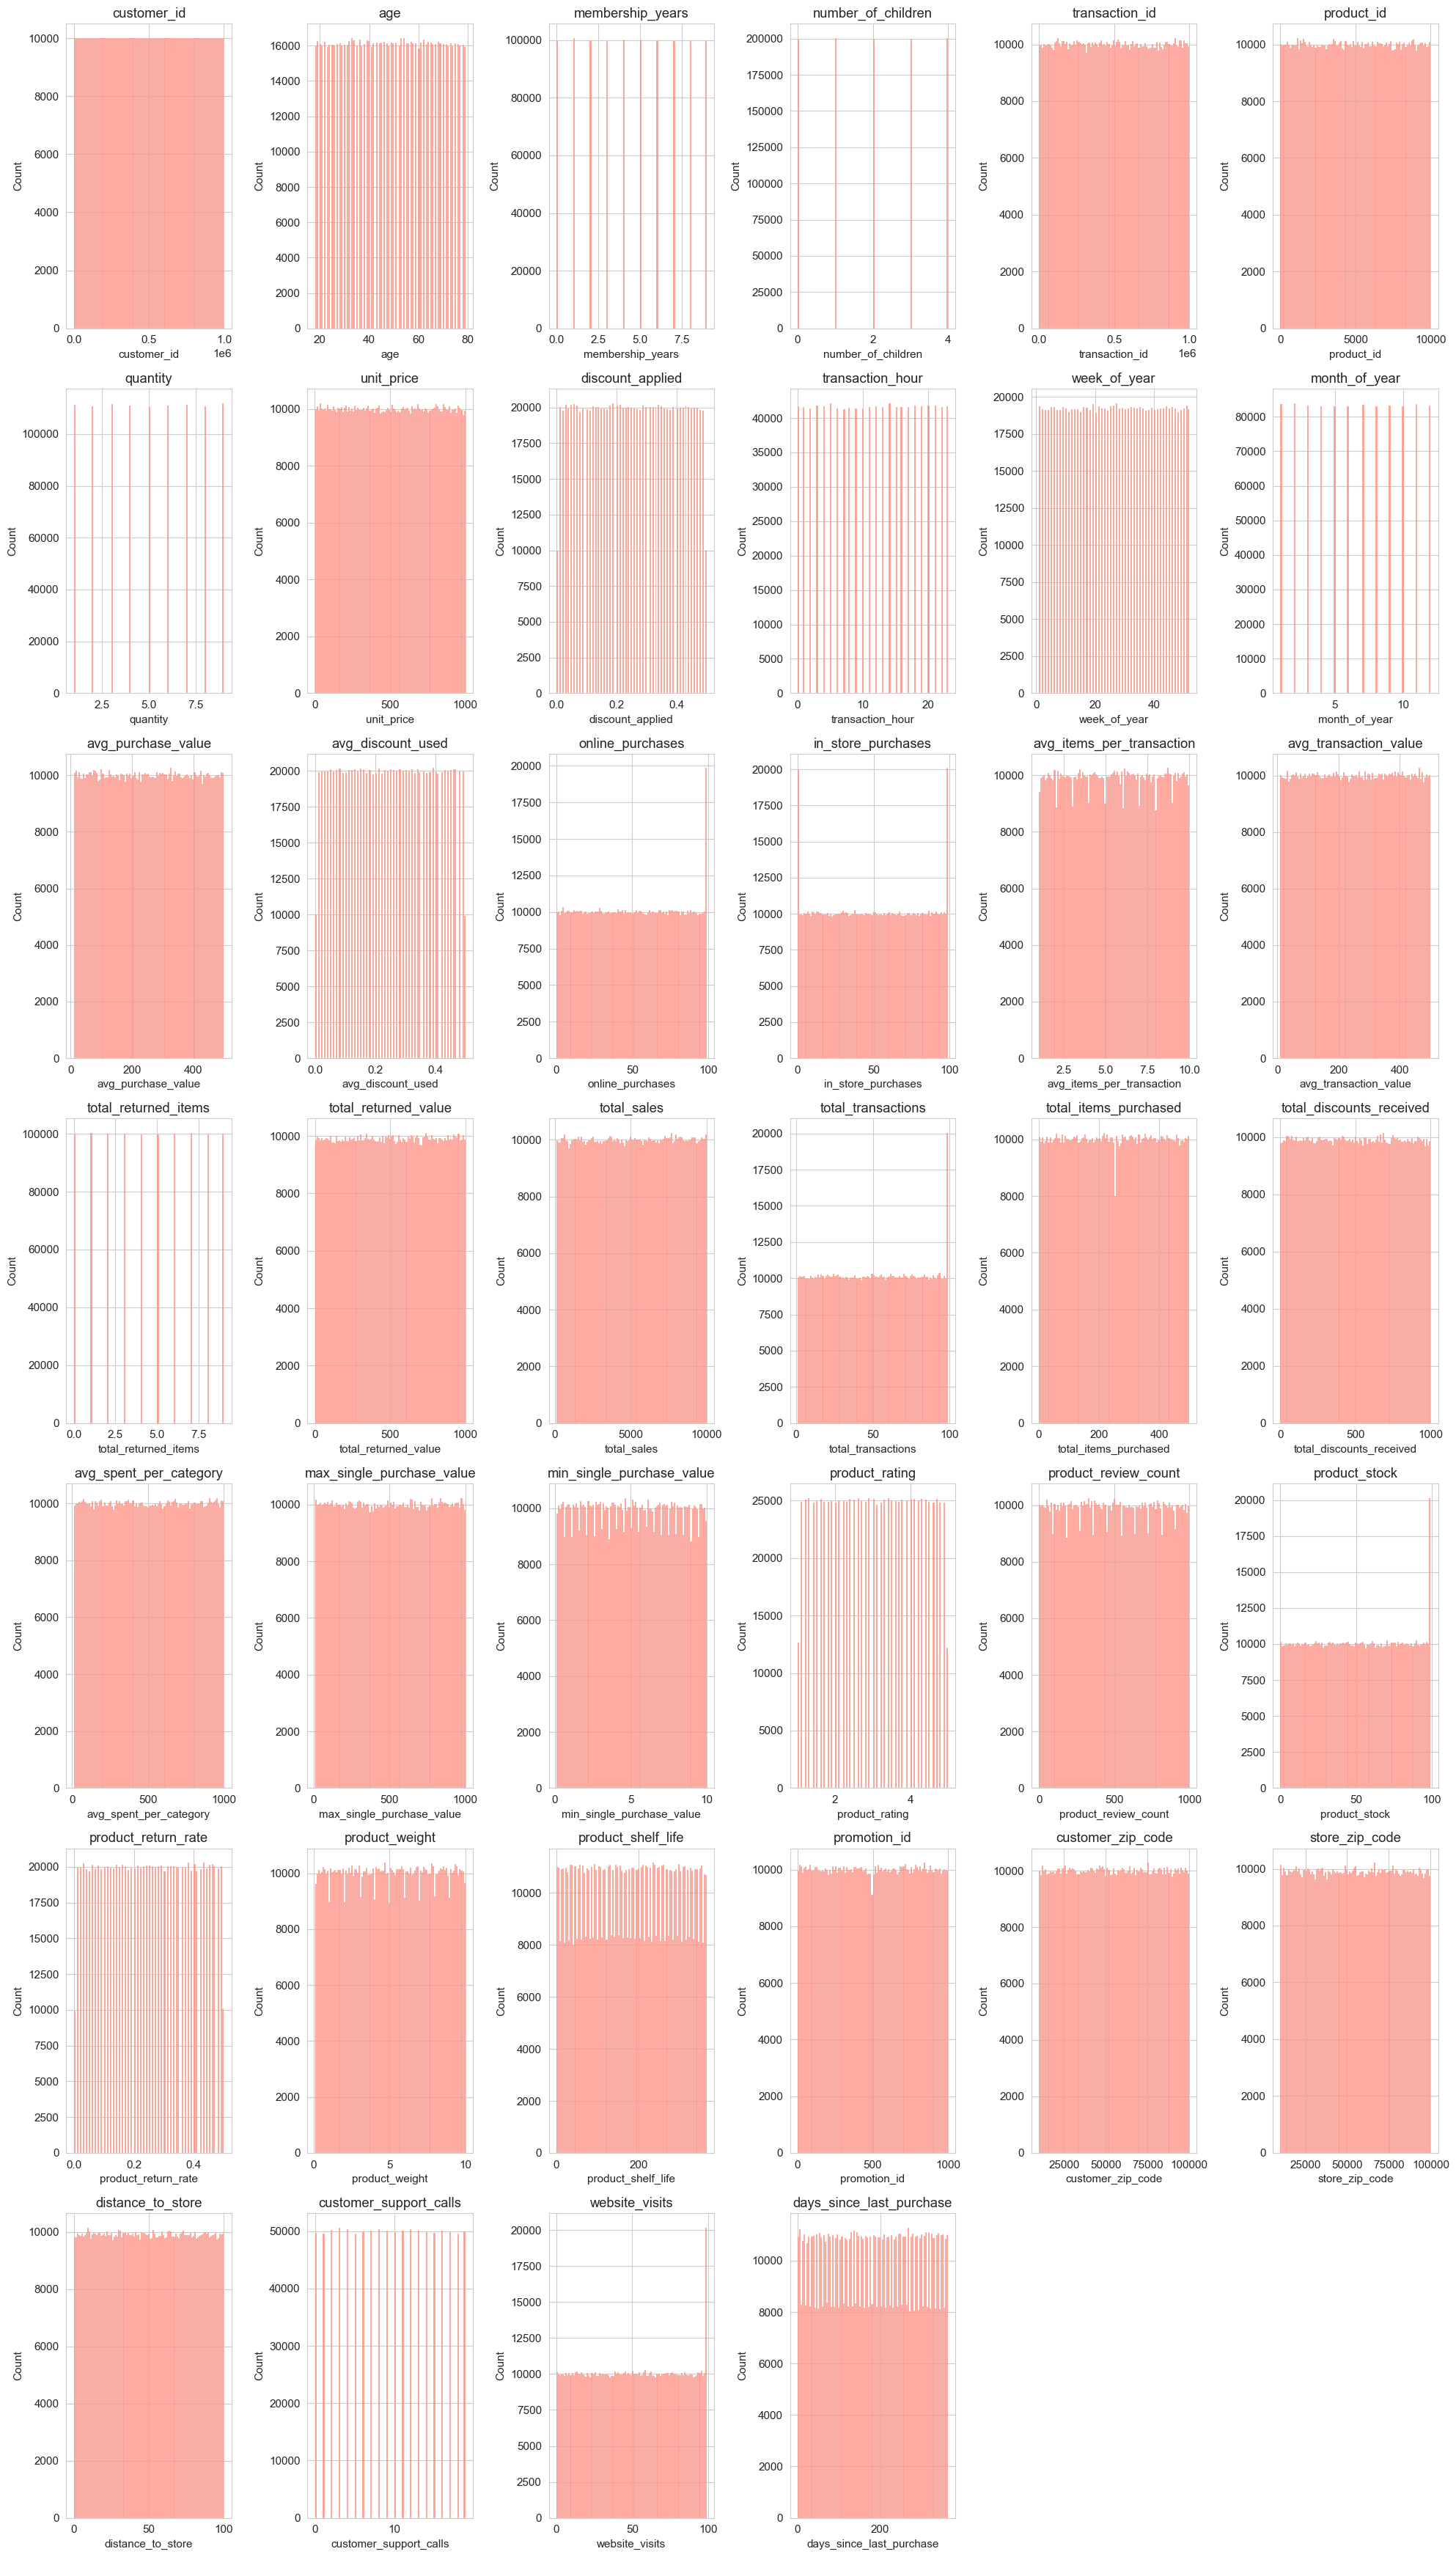

In [22]:
plt.figure(figsize=(20, 5 * n_rows))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], kde=False, color='salmon')  # KDE désactivé
    plt.title(col)

# hide any empty subplots
total_slots = n_rows * n_cols
for j in range(len(num_cols)+1, total_slots+1):
    plt.subplot(n_rows, n_cols, j)
    plt.axis('off')

plt.tight_layout()
plt.show()


3.Analyse des variables catégorielles

🔍 Colonnes catégorielles analysées : ['gender', 'product_category', 'product_brand', 'product_size', 'product_color', 'product_material', 'season', 'payment_method']
Colonnes trouvées dans le dataset : ['gender', 'product_category', 'product_brand', 'product_size', 'product_color', 'product_material', 'season', 'payment_method']


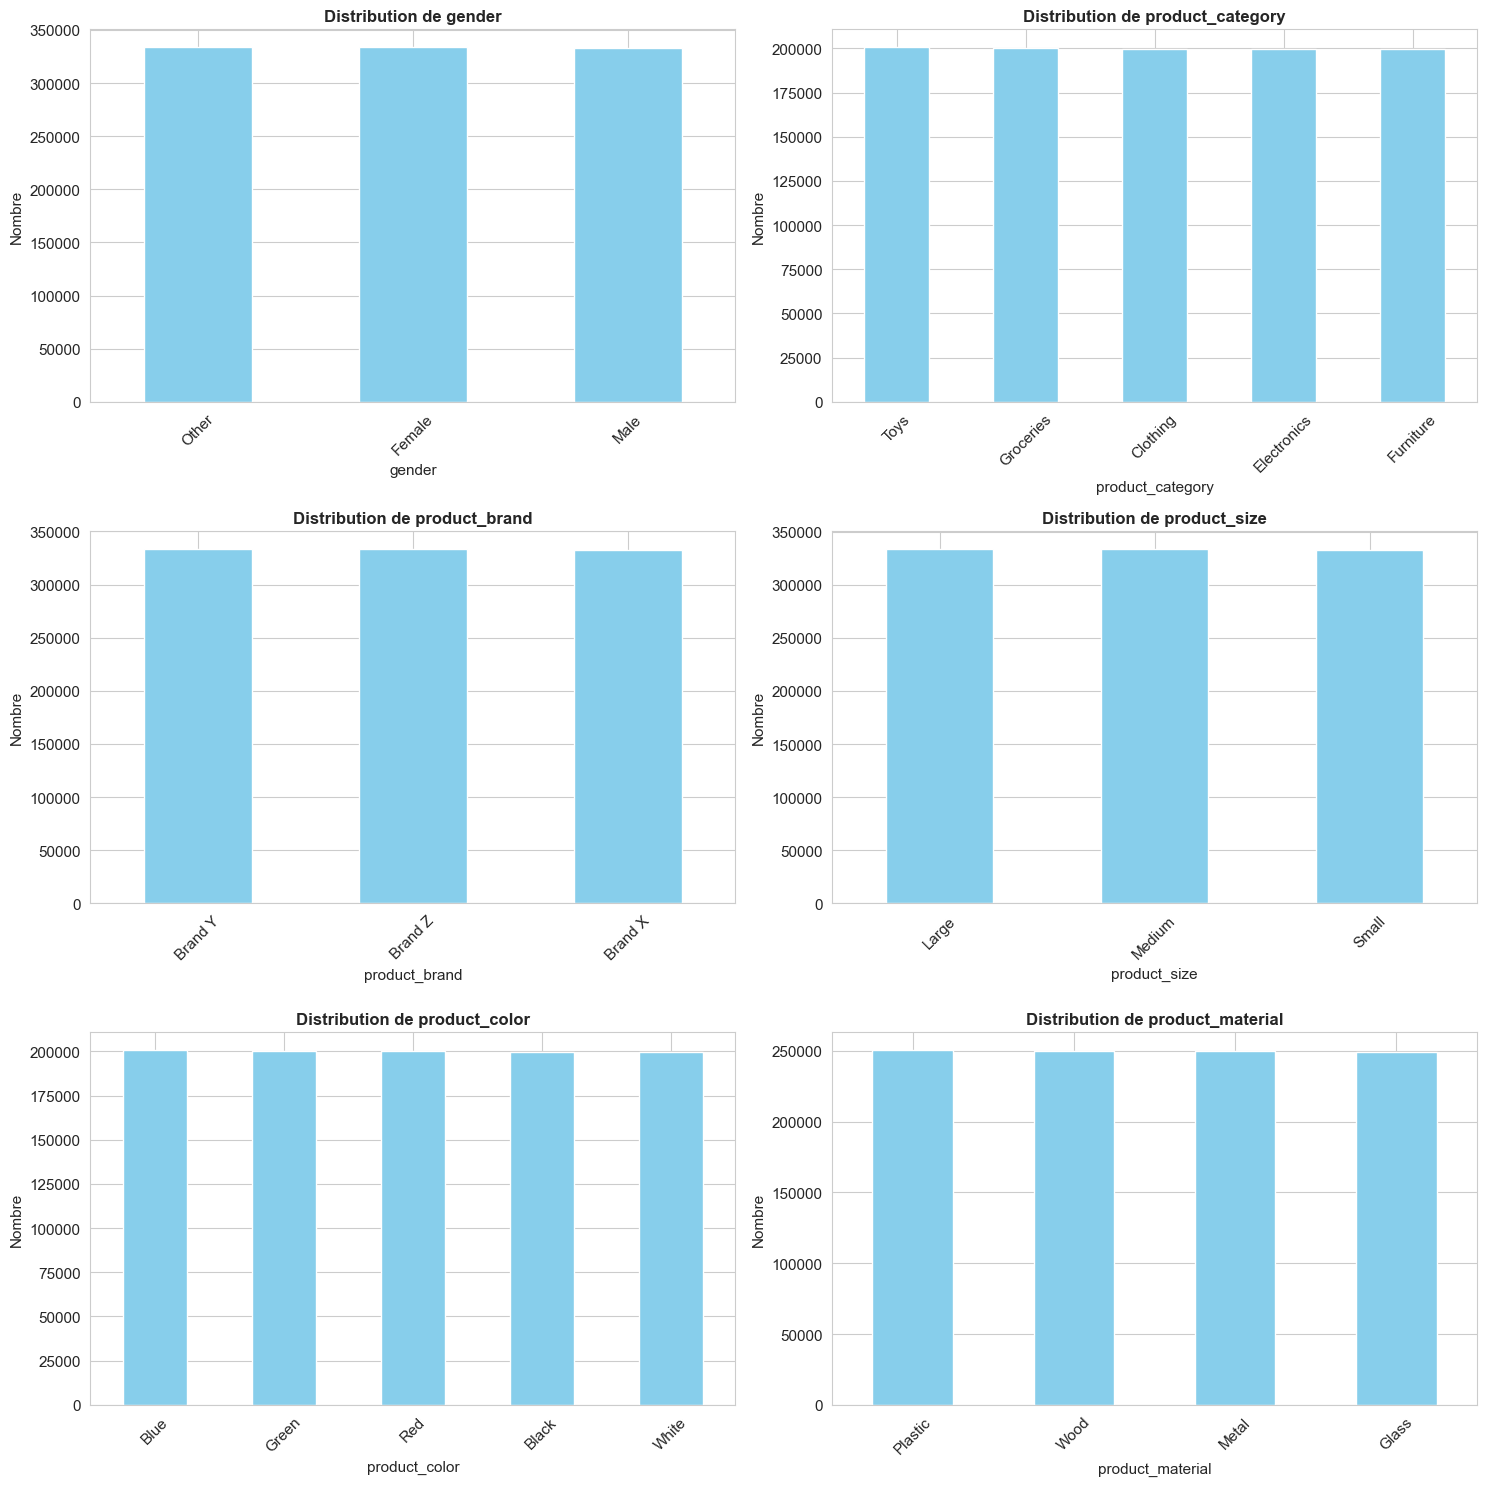

Batch 1 terminé - Colonnes: ['gender', 'product_category', 'product_brand', 'product_size', 'product_color', 'product_material']


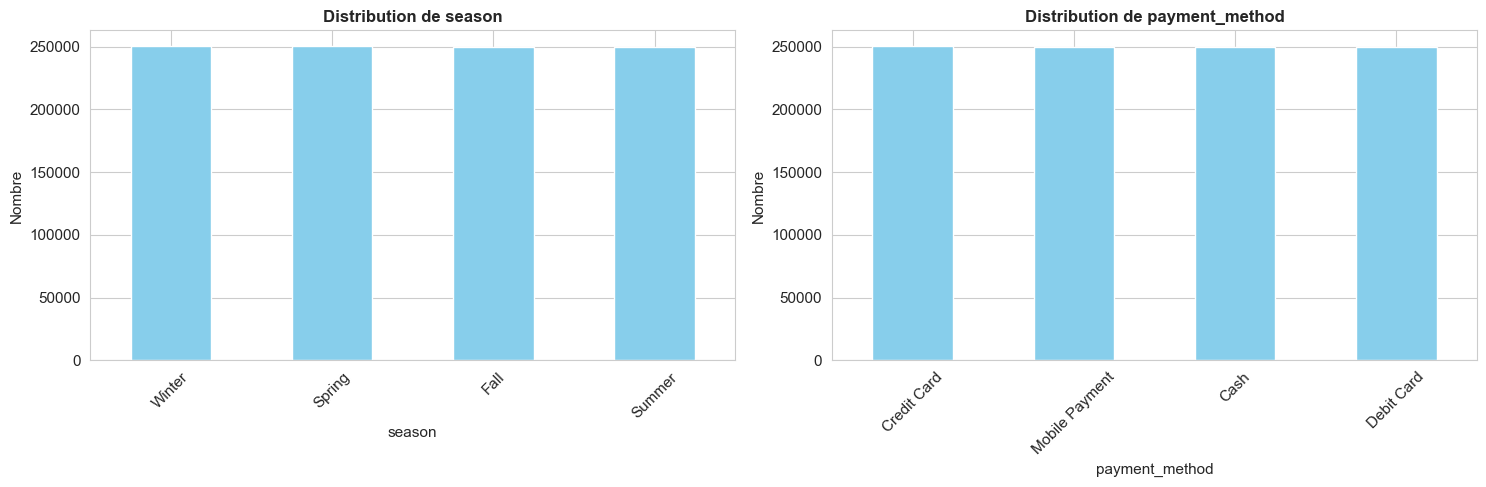

Batch 2 terminé - Colonnes: ['season', 'payment_method']


In [23]:
# CORRECTION : Utiliser les VRAIES colonnes de votre DataFrame
batch_size = 6
categorical_cols = ['gender', 'product_category', 'product_brand', 'product_size', 
                   'product_color', 'product_material', 'season', 'payment_method']

# Filtrer uniquement les colonnes qui existent dans VOTRE dataset
existing_cols = [col for col in categorical_cols if col in df.columns]
print(f"🔍 Colonnes catégorielles analysées : {existing_cols}")
print(f"Colonnes trouvées dans le dataset : {existing_cols}")

# [GARDER LE RESTE DE VOTRE CODE EXISTANT POUR LES VISUALISATIONS]
for start in range(0, len(existing_cols), batch_size):
    batch = existing_cols[start:start + batch_size]
    n_cols = 2
    n_rows = (len(batch) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Si une seule ligne, convertir axes en liste
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(batch):
        if i < len(axes):
            counts = df[col].value_counts()
            
            # Limiter à top 15 catégories si trop de valeurs
            if len(counts) > 15:
                top_counts = counts.head(15)
                top_counts.plot(kind='bar', color='skyblue', ax=axes[i])
                axes[i].set_title(f'Distribution de {col} (Top 15)', fontsize=12, fontweight='bold')
            else:
                counts.plot(kind='bar', color='skyblue', ax=axes[i])
                axes[i].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
            
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Nombre')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Cacher les axes vides
    for j in range(len(batch), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    print(f"Batch {start//batch_size + 1} terminé - Colonnes: {batch}")

6. Analyse des valeurs manquantes

ANALYSE APPROFONDIE DES VALEURS MANQUANTES
Tableau détaillé des valeurs manquantes :
Aucune valeur manquante détectée ✅


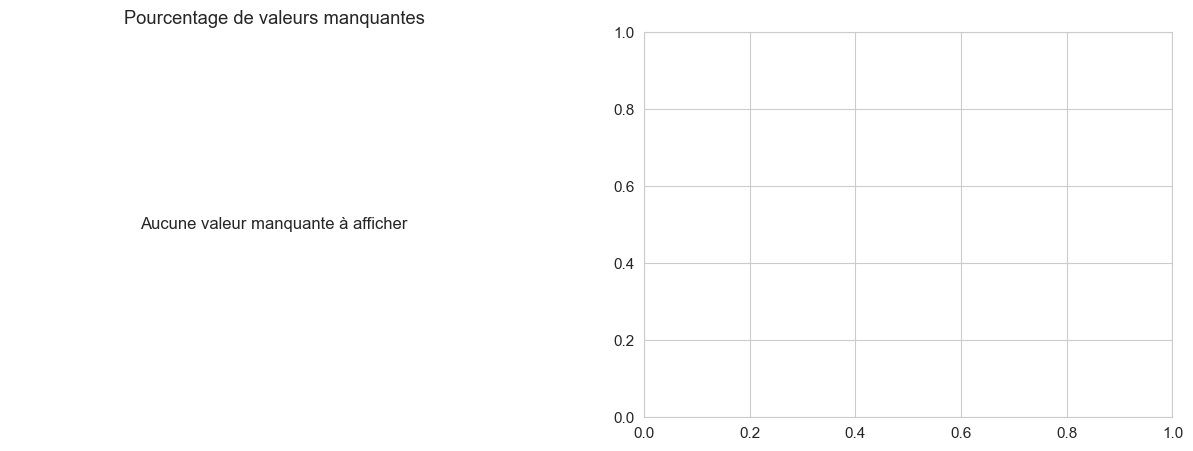

In [24]:
print("ANALYSE APPROFONDIE DES VALEURS MANQUANTES")
print("=" * 50)

# Analyse quantitative
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_data,
    'Pourcentage (%)': missing_percent
})

print("Tableau détaillé des valeurs manquantes :")
missing_report = missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Pourcentage (%)', ascending=False)
if missing_report.empty:
    print("Aucune valeur manquante détectée ✅")
else:
    print(missing_report)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique à barres (si des valeurs manquantes existent)
missing_series = missing_report['Pourcentage (%)'] if not missing_report.empty else None
if missing_series is not None and not missing_series.empty:
    missing_series.plot(kind='bar', ax=axes[0], color='red', alpha=0.7)
    axes[0].set_title('Pourcentage de valeurs manquantes par colonne')
    axes[0].set_ylabel('Pourcentage (%)')
    axes[0].tick_params(axis='x', rotation=45)
    missing_exists = True
else:
    # Afficher un message informatif sur le subplot si pas de données manquantes
    axes[0].axis('off')
    axes[0].text(0.5, 0.5, "Aucune valeur manquante à afficher", ha='center', va='center', fontsize=12)
    axes[0].set_title('Pourcentage de valeurs manquantes')
    missing_exists = False

# Rendre le flag accessible aux cellules suivantes
# (cellules suivantes doivent vérifier `missing_exists` avant d'utiliser axes[1] pour msno)

In [25]:
# Matrix missingno
msno.bar(df, ax=axes[1], color="red")
axes[1].set_title('Distribution des valeurs manquantes')

plt.tight_layout()
plt.show()

# Résumé
total_missing = missing_data.sum()
print(f"\n RÉSUMÉ :")
print(f"• Total des valeurs manquantes : {total_missing}")
print(f"• Pourcentage global de données manquantes : {(total_missing / (df.shape[0] * df.shape[1])) * 100:.2f}%")
print(f"• Colonnes sans valeurs manquantes : {sum(missing_data == 0)}/{len(df.columns)}")

<Figure size 1200x700 with 0 Axes>


 RÉSUMÉ :
• Total des valeurs manquantes : 0
• Pourcentage global de données manquantes : 0.00%
• Colonnes sans valeurs manquantes : 78/78


Aucune valeur manquante détectée

## PARTIE 4: ANALYSE EXPLORATOIRE DES DONNÉES

1.ANALYSE APPROFONDIE DES CORRÉLATIONS

In [26]:
# Compute correlation on numeric columns only to avoid trying to convert strings to float
corr_numeric = df.select_dtypes(include=[np.number]).corr()
corr_numeric

customer_id       age  membership_years  \
customer_id                   1.000000  0.000157         -0.000885   
age                           0.000157  1.000000         -0.000892   
membership_years             -0.000885 -0.000892          1.000000   
number_of_children           -0.001702  0.000905          0.001421   
transaction_id               -0.001247  0.000067          0.000137   
product_id                   -0.000025  0.000447          0.000045   
quantity                      0.000556  0.000166          0.000221   
unit_price                   -0.000301  0.000774          0.000001   
discount_applied             -0.001169  0.000438          0.000075   
transaction_hour              0.000472  0.000029          0.000280   
week_of_year                  0.000788 -0.000137          0.000420   
month_of_year                 0.001200  0.000232          0.000500   
avg_purchase_value            0.001245 -0.000363         -0.001819   
avg_discount_used            -0.000100 -0.000085          0.000881   
online_purchases              0.000767 -0.001130          0.000307   
in_store_purchases           -0.000647  0.000684          0.001012   
avg_items_per_transaction    -0.000646 -0.000295          0.000206   
avg_transaction_value        -0.000244 -0.002060          0.002016   
total_returned_items          0.001634  0.000181          0.000905   
total_returned_value         -0.000205 -0.000840          0.001429   
total_sales                  -0.000632  0.001044         -0.001926   
total_transactions            0.000082  0.001192          0.000546   
total_items_purchased        -0.000833 -0.000798          0.001189   
total_discounts_received     -0.000237 -0.000638          0.000200   
avg_spent_per_category        0.000580 -0.000843         -0.000398   
max_single_purchase_value    -0.001984  0.001128          0.000462   
min_single_purchase_value    -0.000521 -0.001391         -0.003033   
product_rating               -0.000955 -0.000112         -0.000171   
product_review_count         -0.001158  0.000659          0.000756   
product_stock                 0.001273  0.001221          0.000118   
product_return_rate           0.001563 -0.000577         -0.000217   
product_weight                0.000583 -0.001692          0.000648   
product_shelf_life           -0.001199  0.000779         -0.000178   
promotion_id                  0.000616  0.000602          0.000760   
customer_zip_code             0.000264  0.001837         -0.000010   
store_zip_code                0.000279  0.000415         -0.002614   
distance_to_store            -0.000070  0.000331          0.000055   
customer_support_calls       -0.000724 -0.000883          0.000189   
website_visits                0.000603  0.000039         -0.000578   
days_since_last_purchase     -0.001506 -0.000208          0.000626   

                           number_of_children  transaction_id  product_id  \
customer_id                         -0.001702       -0.001247   -0.000025   
age                                  0.000905        0.000067    0.000447   
membership_years                     0.001421        0.000137    0.000045   
number_of_children                   1.000000        0.000408   -0.001069   
transaction_id                       0.000408        1.000000   -0.001865   
product_id                          -0.001069       -0.001865    1.000000   
quantity                            -0.002011        0.000384    0.000024   
unit_price                           0.000457        0.000252   -0.000028   
discount_applied                    -0.000427        0.000466   -0.000839   
transaction_hour                     0.001385       -0.001360    0.000837   
week_of_year                        -0.001775       -0.000230   -0.000826   
month_of_year                       -0.000393       -0.000299   -0.001684   
avg_purchase_value                  -0.001051        0.001172   -0.000484   
avg_discount_used                    0.001283       -0.002017    0.000491   
o

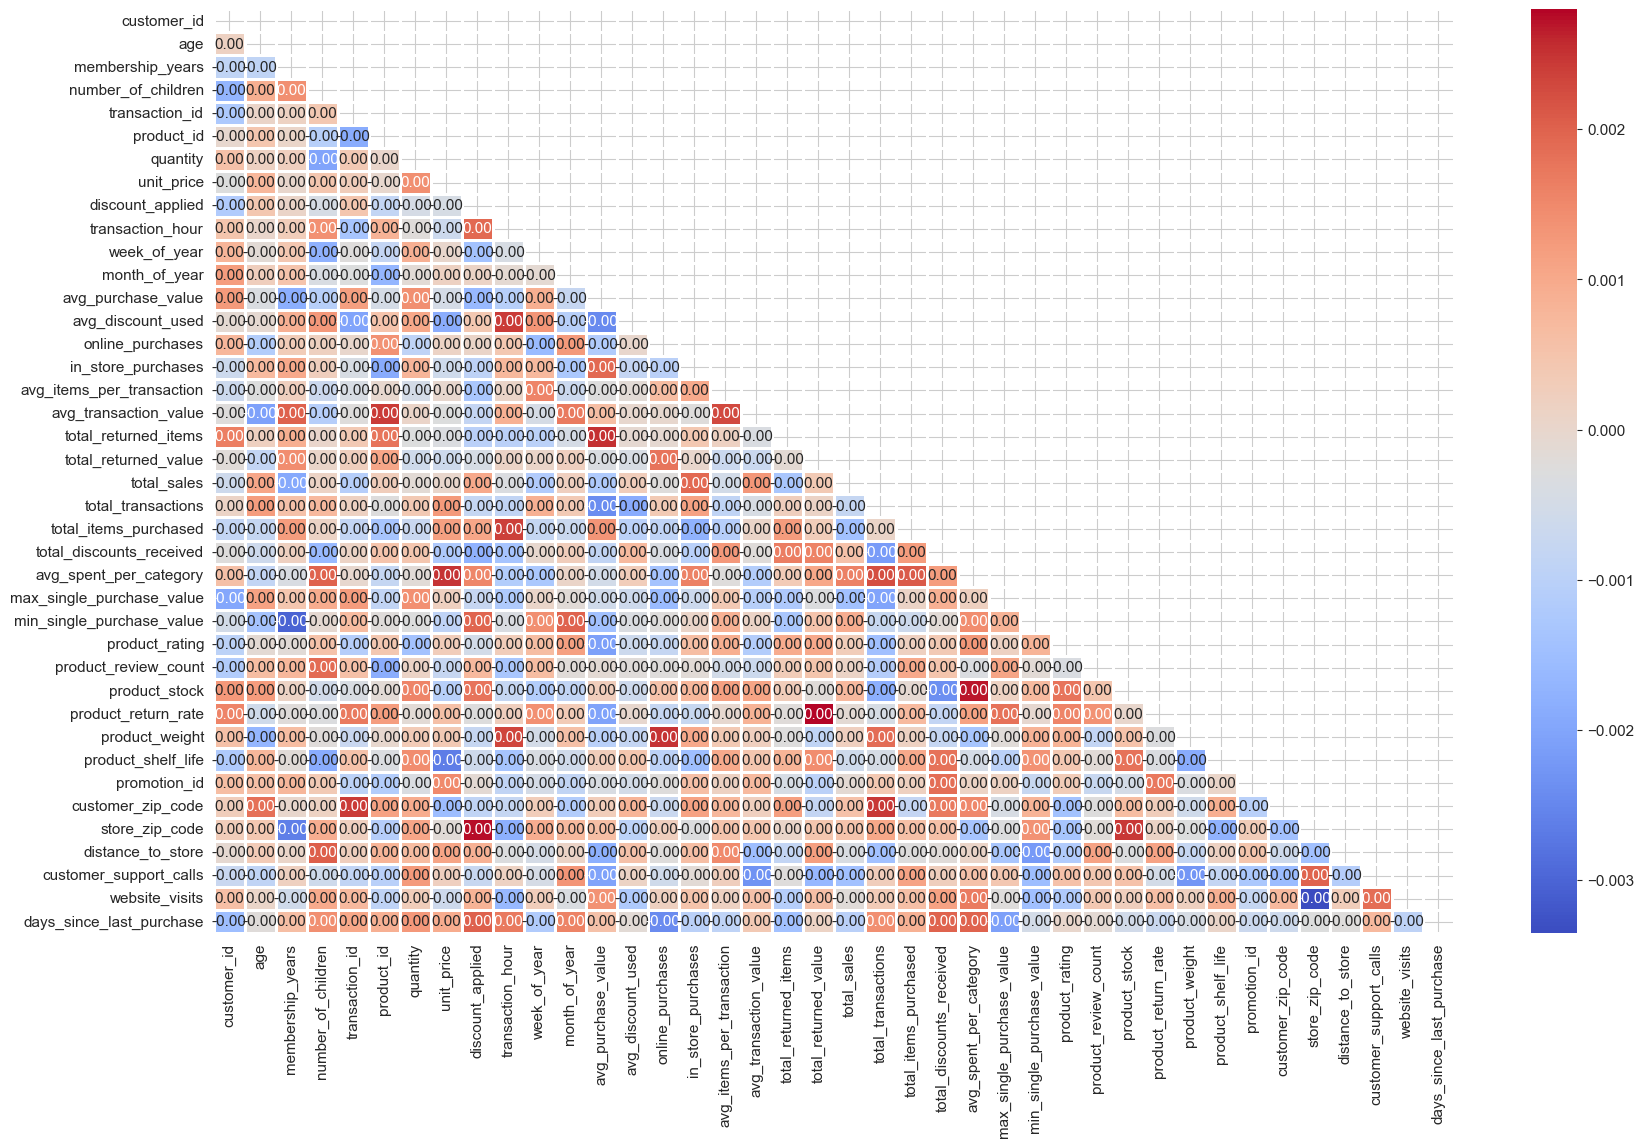

In [27]:

plt.figure(figsize=(20,12))
# Use only numeric columns to avoid conversion errors from string categories (e.g. 'Other')
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, linewidths=1, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

2. Analyse par catégorie

sum         mean   count
product_category                                   
Toys              1.013781e+09  5052.006447  200669
Clothing          1.011086e+09  5061.047189  199778
Groceries         1.011073e+09  5049.960082  200214
Electronics       1.010576e+09  5059.053803  199756
Furniture         1.009544e+09  5058.265177  199583

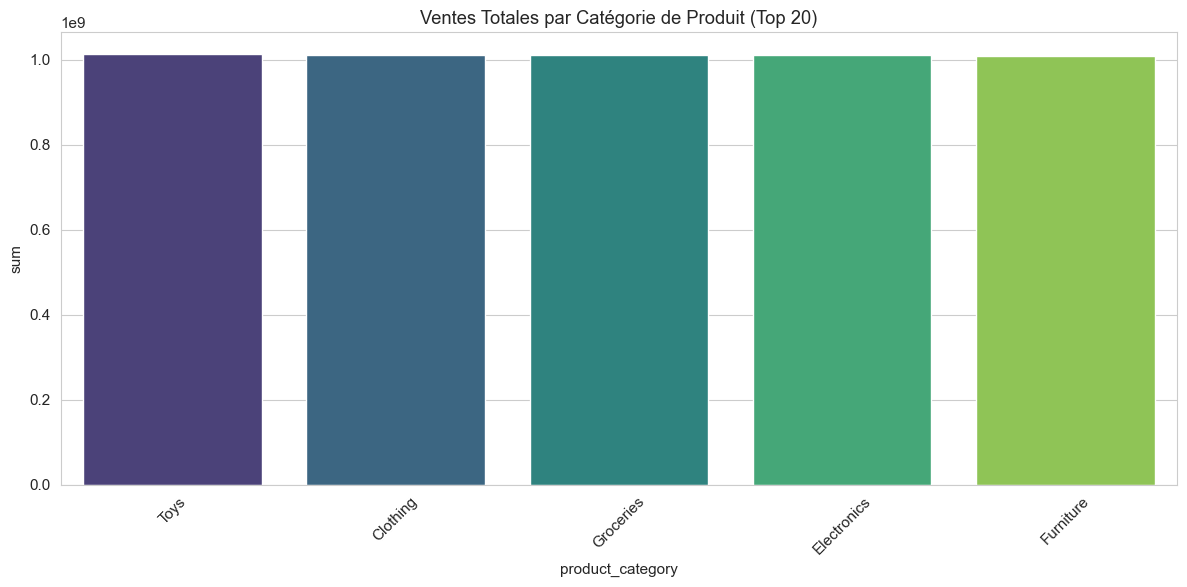

In [28]:
if 'product_category' in df.columns:
    # Use 'total_sales' if present, otherwise try to compute sales from quantity * unit_price
    if 'total_sales' in df.columns:
        sales_col = 'total_sales'
        temp_df = df
    elif {'quantity', 'unit_price'}.issubset(df.columns):
        temp_df = df.copy()
        temp_df['__sales_tmp'] = temp_df['quantity'] * temp_df['unit_price']
        sales_col = '__sales_tmp'
    else:
        raise KeyError("Column not found: sales or total_sales and cannot compute sales (missing quantity/unit_price)")

    grouped = temp_df.groupby('product_category')[sales_col].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
    display(grouped)

    # Plot top categories to avoid overcrowding
    top_n = 20
    grouped_plot = grouped.reset_index().head(top_n)

    plt.figure(figsize=(12,6))
    sns.barplot(data=grouped_plot, x='product_category', y='sum', palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f"Ventes Totales par Catégorie de Produit (Top {top_n})")
    plt.tight_layout()
    plt.show()


3. Relations entre variables clés

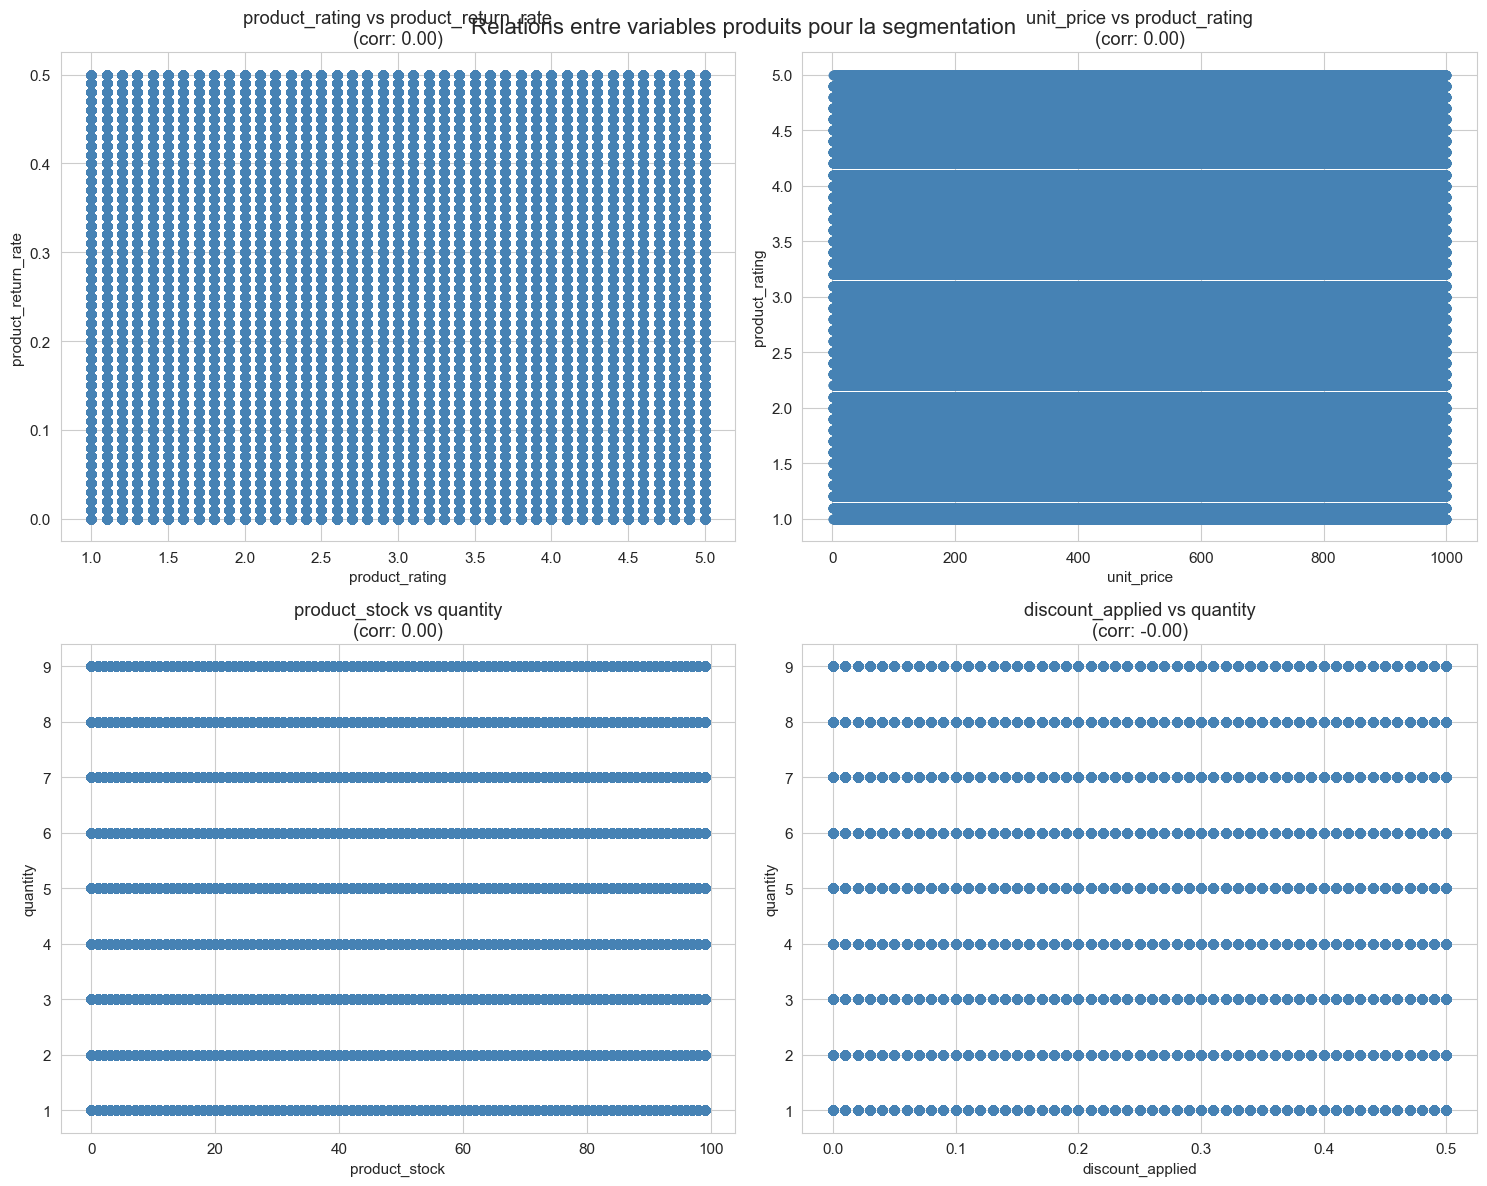

In [29]:
# RELATIONS ENTRE VARIABLES CLÉS POUR LA SEGMENTATION PRODUIT
key_pairs = [
    ('product_rating', 'product_return_rate'),
    ('unit_price', 'product_rating'),
    ('product_stock', 'quantity'),
    ('discount_applied', 'quantity')
]

plt.figure(figsize=(15, 12))

valid_pairs = []
for var1, var2 in key_pairs:
    if var1 in df.columns and var2 in df.columns:
        valid_pairs.append((var1, var2))

for i, (var1, var2) in enumerate(valid_pairs):
    plt.subplot(2, 2, i+1)
    
    # Filtrer les valeurs extrêmes pour meilleure visualisation
    x_data = df[var1]
    y_data = df[var2]
    
    plt.scatter(x_data, y_data, alpha=0.5, color='steelblue')
    plt.xlabel(var1)
    plt.ylabel(var2)
    
    # Calcul de corrélation
    corr_val = df[[var1, var2]].corr().iloc[0,1]
    plt.title(f'{var1} vs {var2}\n(corr: {corr_val:.2f})')

plt.tight_layout()
plt.suptitle('Relations entre variables produits pour la segmentation', fontsize=16)
plt.show()

4. Analyse par Groupes

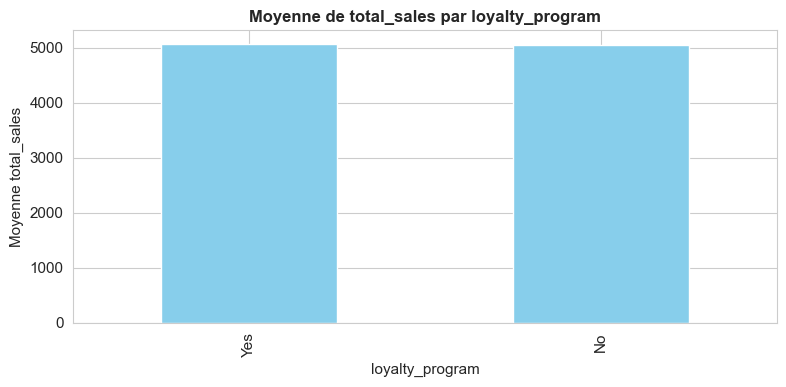

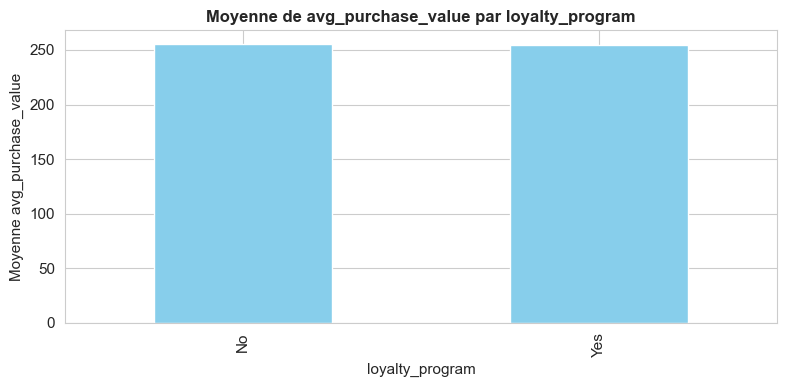

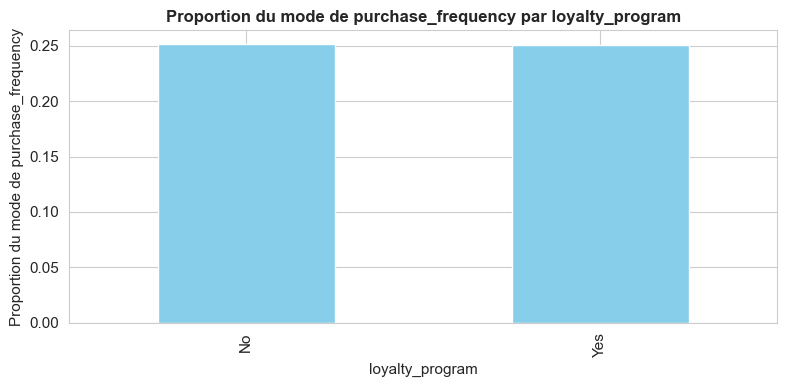

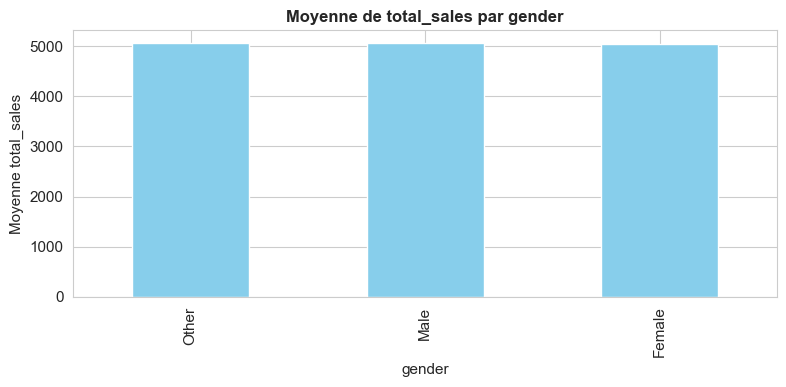

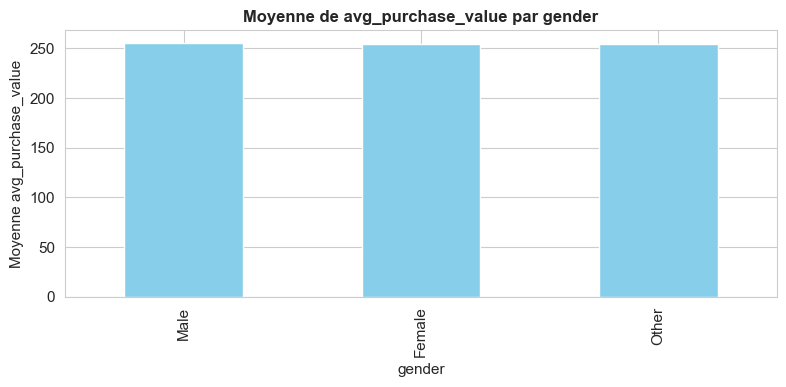

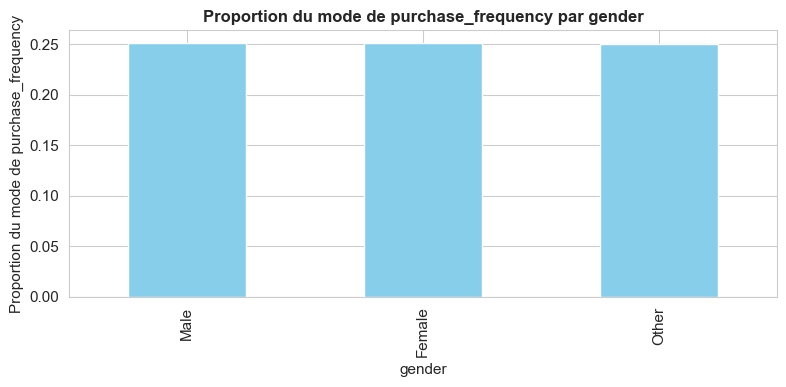

Skipping group column 'region' (not in DataFrame).


In [30]:
group_cols = ['loyalty_program', 'gender', 'region']
target_cols = ['total_sales', 'avg_purchase_value', 'purchase_frequency']

for g_col in group_cols:
    if g_col not in df.columns:
        print(f"Skipping group column '{g_col}' (not in DataFrame).")
        continue

    for t_col in target_cols:
        if t_col not in df.columns:
            print(f"  Skipping target '{t_col}' (not in DataFrame).")
            continue

        try:
            # If target is numeric (or can be converted to numeric), plot the group mean
            if pd.api.types.is_numeric_dtype(df[t_col]):
                grouped = df.groupby(g_col)[t_col].mean()
                ylabel = f"Moyenne {t_col}"
                title = f'Moyenne de {t_col} par {g_col}'
            else:
                # try to coerce to numeric (e.g. strings containing numbers)
                coerced = pd.to_numeric(df[t_col], errors='coerce')
                if coerced.notna().any():
                    grouped = df.assign(_tmp=coerced).groupby(g_col)['_tmp'].mean()
                    ylabel = f"Moyenne {t_col} (converti en numérique)"
                    title = f'Moyenne de {t_col} par {g_col} (converti)'
                else:
                    # Non-numeric categorical target: compute proportion of the most common category (mode proportion)
                    mode_prop = df.groupby(g_col)[t_col].apply(lambda x: x.value_counts(normalize=True).iloc[0] if len(x) > 0 else np.nan)
                    grouped = mode_prop
                    ylabel = f"Proportion du mode de {t_col}"
                    title = f'Proportion du mode de {t_col} par {g_col}'
            
            # Plot
            fig, ax = plt.subplots(figsize=(8,4))
            grouped.sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_ylabel(ylabel)
            ax.set_xlabel(g_col)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"  Error processing ({g_col}, {t_col}): {e}")
            continue

5. Analyse des Segments de Clients

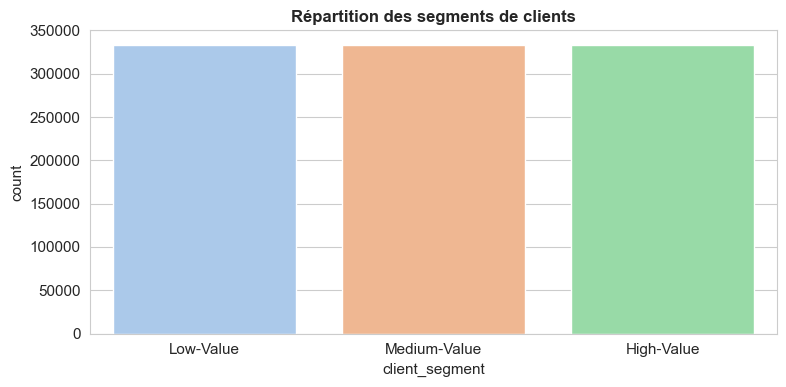

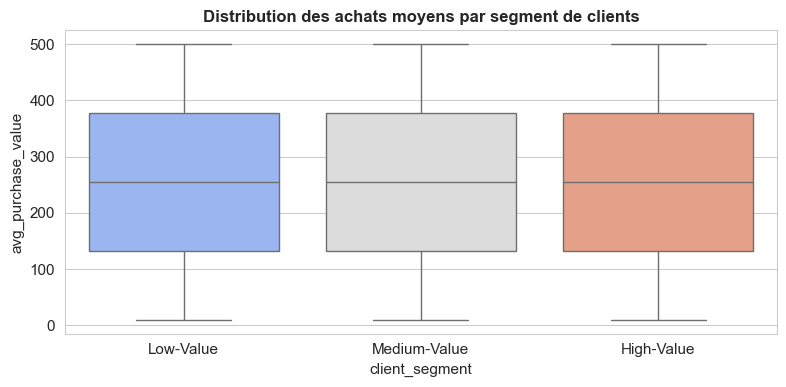

In [31]:
# Segmentation simple en terciles sur total_sales
df['client_segment'] = pd.qcut(df['total_sales'], q=3, labels=['Low-Value', 'Medium-Value', 'High-Value'])

# Visualisation distribution
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=df, x='client_segment', palette='pastel', ax=ax)
ax.set_title('Répartition des segments de clients', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Comparaison des comportements par segment
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=df, x='client_segment', y='avg_purchase_value', palette='coolwarm', ax=ax)
ax.set_title('Distribution des achats moyens par segment de clients', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

6. SEGMENTATION NON SUPERVISÉE DES PRODUITS

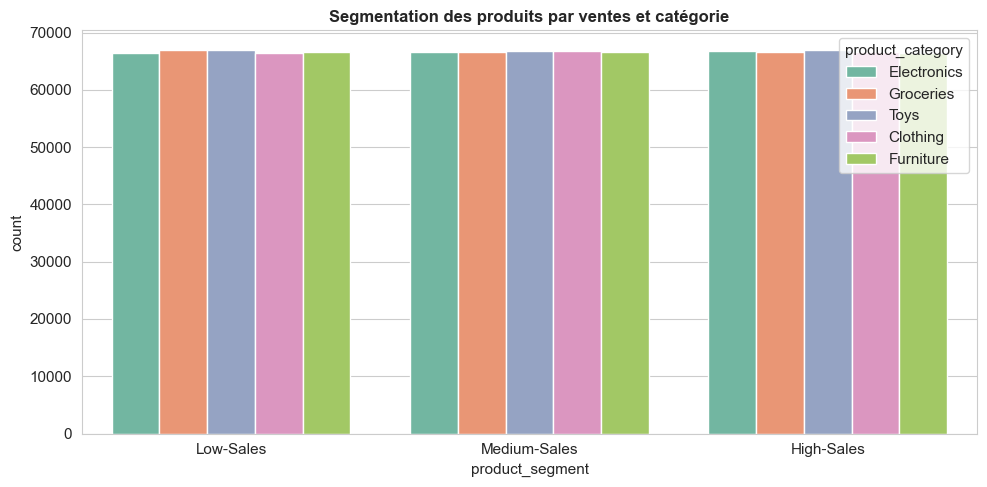

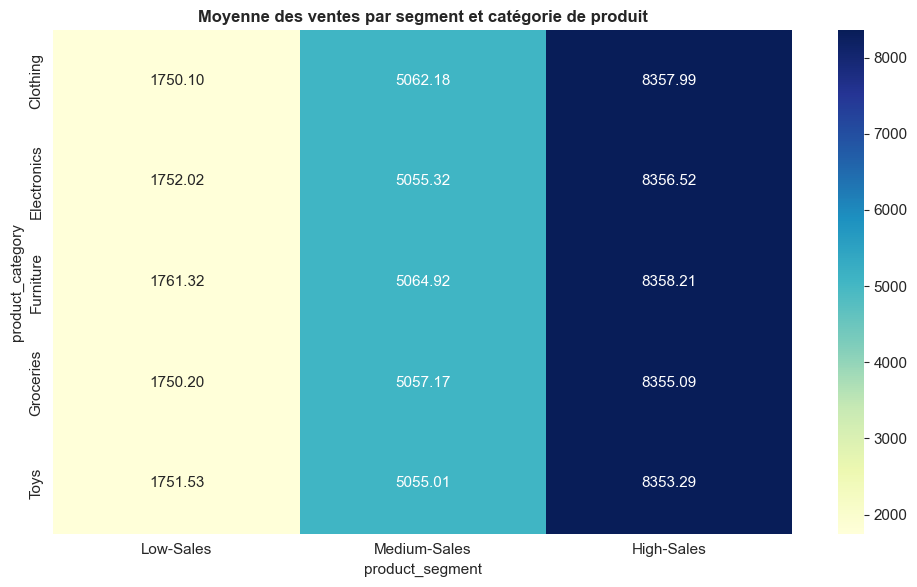

In [32]:
# Segmentation sur ventes totales
df['product_segment'] = pd.qcut(df['total_sales'], q=3, labels=['Low-Sales', 'Medium-Sales', 'High-Sales'])

# Barplot des segments produits par catégorie
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=df, x='product_segment', hue='product_category', palette='Set2', ax=ax)
ax.set_title('Segmentation des produits par ventes et catégorie', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Heatmap : moyenne des ventes par segment et catégorie
pivot_table = df.pivot_table(index='product_category', columns='product_segment', values='total_sales', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Moyenne des ventes par segment et catégorie de produit', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## PARTIE 5: PRÉPARATION DES DONNÉES

0. Suppression des colonnes non pertinentes

In [33]:
# Colonnes identifiants, textuelles ou inutiles pour la segmentation
cols_to_drop = [
    'customer_id', 'transaction_id', 'product_id', 'product_name',
    'product_brand', 'transaction_date', 'last_purchase_date',
    'product_manufacture_date', 'product_expiry_date',
    'promotion_start_date', 'promotion_end_date'
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], axis=1)

print("Colonnes restantes :", df.columns.tolist())


Colonnes restantes : ['age', 'gender', 'income_bracket', 'loyalty_program', 'membership_years', 'churned', 'marital_status', 'number_of_children', 'education_level', 'occupation', 'product_category', 'quantity', 'unit_price', 'discount_applied', 'payment_method', 'store_location', 'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year', 'avg_purchase_value', 'purchase_frequency', 'avg_discount_used', 'preferred_store', 'online_purchases', 'in_store_purchases', 'avg_items_per_transaction', 'avg_transaction_value', 'total_returned_items', 'total_returned_value', 'total_sales', 'total_transactions', 'total_items_purchased', 'total_discounts_received', 'avg_spent_per_category', 'max_single_purchase_value', 'min_single_purchase_value', 'product_rating', 'product_review_count', 'product_stock', 'product_return_rate', 'product_size', 'product_weight', 'product_color', 'product_material', 'product_shelf_life', 'promotion_id', 'promotion_type', 'promotion_effectiveness', 'promotion_c

1. Séparation des features pour clients et produits

In [34]:
# Features clients
client_features = [
    'age', 'gender', 'income_bracket', 'loyalty_program', 'membership_years',
    'churned', 'marital_status', 'number_of_children', 'education_level', 
    'occupation', 'customer_zip_code', 'customer_city', 'customer_state',
    'distance_to_store', 'holiday_season', 'season', 'weekend',
    'customer_support_calls', 'email_subscriptions', 'app_usage',
    'website_visits', 'social_media_engagement', 'days_since_last_purchase'
]

# Features produits
product_features = [
    'product_category', 'quantity', 'unit_price', 'discount_applied',
    'payment_method', 'store_location', 'transaction_hour', 'day_of_week',
    'week_of_year', 'month_of_year', 'avg_purchase_value', 'purchase_frequency',
    'avg_discount_used', 'preferred_store', 'online_purchases', 'in_store_purchases',
    'avg_items_per_transaction', 'avg_transaction_value', 'total_returned_items',
    'total_returned_value', 'total_sales', 'total_transactions', 'total_items_purchased',
    'total_discounts_received', 'avg_spent_per_category', 'max_single_purchase_value',
    'min_single_purchase_value', 'product_rating', 'product_review_count',
    'product_stock', 'product_return_rate', 'product_size', 'product_weight',
    'product_color', 'product_material', 'product_shelf_life',
    'promotion_id', 'promotion_type', 'promotion_effectiveness', 'promotion_channel',
    'promotion_target_audience', 'store_zip_code', 'store_city', 'store_state'
]

df_clients = df[client_features].copy()
df_products = df[product_features].copy()

print("Dimensions dataset clients :", df_clients.shape)
print("Dimensions dataset produits :", df_products.shape)


Dimensions dataset clients : (1000000, 23)
Dimensions dataset produits : (1000000, 44)


2. Encodage des variables catégorielles

In [35]:
from sklearn.preprocessing import OneHotEncoder

# Encodage clients
categorical_clients = df_clients.select_dtypes(include='object').columns
# use `sparse_output` (newer sklearn) instead of deprecated `sparse`
encoder_clients = OneHotEncoder(sparse_output=False, drop='first')
clients_encoded = pd.DataFrame(
    encoder_clients.fit_transform(df_clients[categorical_clients]),
    columns=encoder_clients.get_feature_names_out(categorical_clients)
)

df_clients_encoded = pd.concat([df_clients.drop(columns=categorical_clients), clients_encoded], axis=1)

# Encodage produits
categorical_products = df_products.select_dtypes(include='object').columns
encoder_products = OneHotEncoder(sparse_output=False, drop='first')
products_encoded = pd.DataFrame(
    encoder_products.fit_transform(df_products[categorical_products]),
    columns=encoder_products.get_feature_names_out(categorical_products)
)

df_products_encoded = pd.concat([df_products.drop(columns=categorical_products), products_encoded], axis=1)

print("Clients encodés :", df_clients_encoded.shape)
print("Produits encodés :", df_products_encoded.shape)


Clients encodés : (1000000, 37)
Produits encodés : (1000000, 72)


3. Standardisation des données numériques

In [36]:
from sklearn.preprocessing import StandardScaler

scaler_clients = StandardScaler()
numeric_clients = df_clients_encoded.select_dtypes(include='number').columns
df_clients_scaled = pd.DataFrame(
    scaler_clients.fit_transform(df_clients_encoded[numeric_clients]),
    columns=numeric_clients
)

scaler_products = StandardScaler()
numeric_products = df_products_encoded.select_dtypes(include='number').columns
df_products_scaled = pd.DataFrame(
    scaler_products.fit_transform(df_products_encoded[numeric_products]),
    columns=numeric_products
)

print("Clients standardisés :", df_clients_scaled.shape)
print("Produits standardisés :", df_products_scaled.shape)


Clients standardisés : (1000000, 37)
Produits standardisés : (1000000, 72)


4. Réduction de dimension pour visualisation (PCA, t-SNE, UMAP)

🚀 DÉMARRAGE RÉDUCTION DE DIMENSION OPTIMISÉE - VERSION CORRIGÉE
📊 Format données: Clients <class 'numpy.ndarray'>, Produits <class 'numpy.ndarray'>
📊 Dimensions: Clients (1000000, 37), Produits (1000000, 72)
1. Calcul PCA...
✅ PCA terminé - 0.8s
📈 Variance clients: 0.081, produits: 0.042
2. Calcul UMAP (échantillon 5000 points)...
✅ UMAP terminé - 51.2s
📊 UMAP clients: (5000, 2), produits: (5000, 2)
3. Calcul t-SNE (échantillon 2000 points)...
✅ t-SNE terminé - 19.6s
📊 t-SNE clients: (2000, 2), produits: (2000, 2)
🎉 RÉDUCTION DE DIMENSION TERMINÉE!
📊 PCA: ✓ (1,000,000 points)
📊 UMAP: ✓ (5000 points)
📊 t-SNE: ✓ (2000 points)

🎨 VISUALISATION COMPLÈTE DES RÉSULTATS


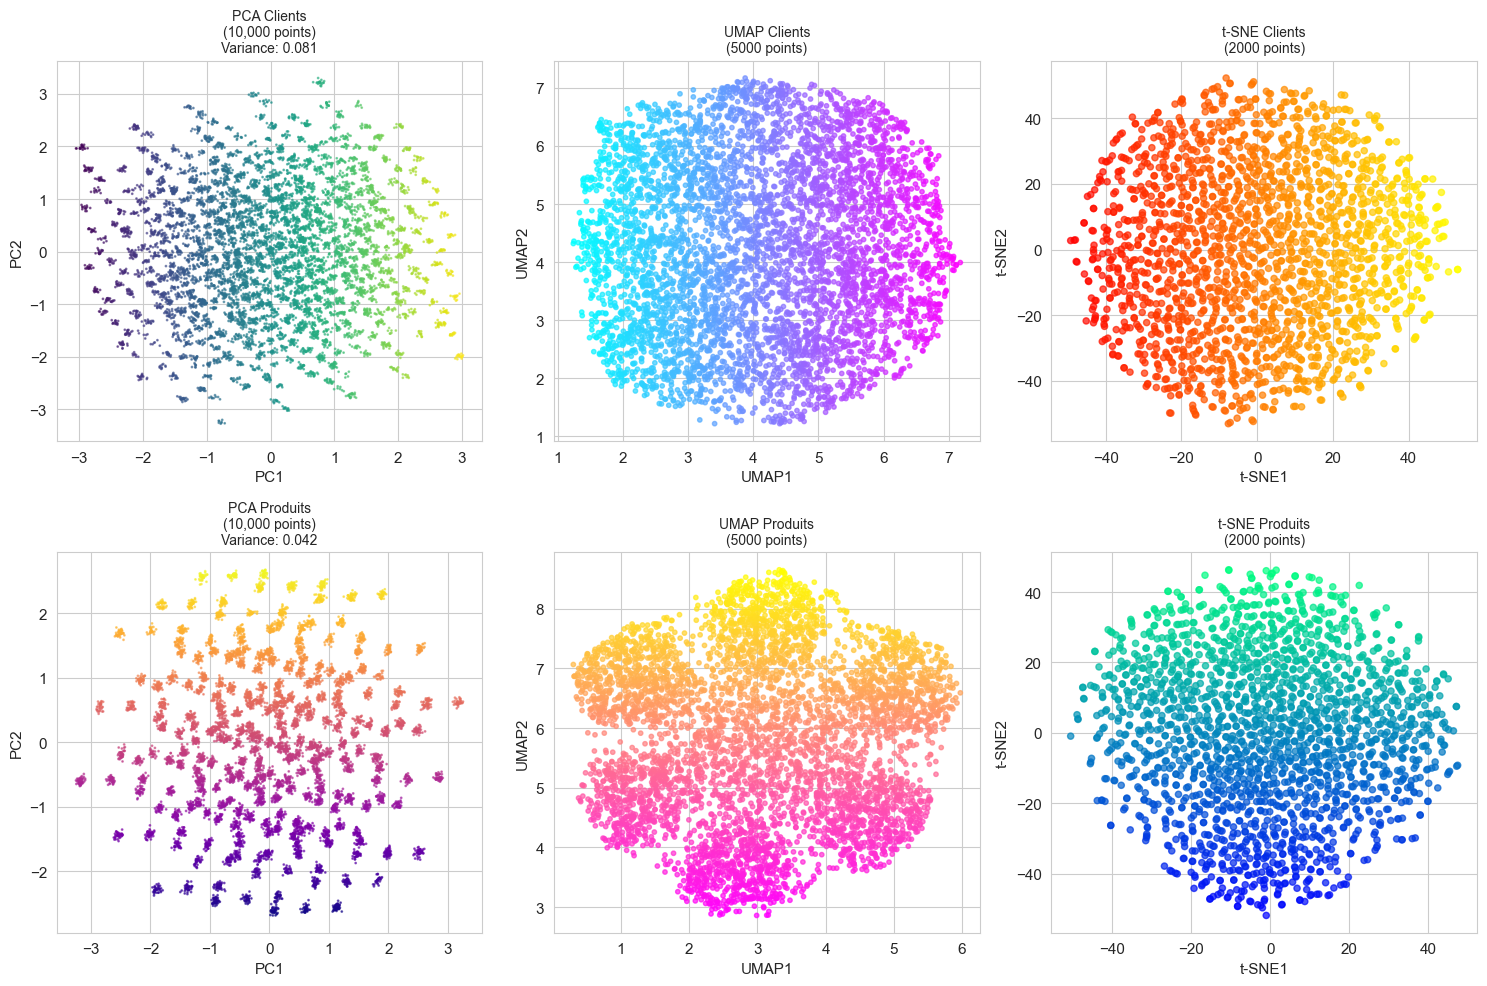


🔍 ANALYSE DES RÉSULTATS
📊 PERFORMANCE DES ALGORITHMES:
   • PCA:      0.081 variance clients, 0.042 variance produits
   • UMAP:     ✓ (5000 points)
   • t-SNE:    ✓ (2000 points)

💡 INTERPRÉTATION:
   • Variance PCA faible → données très dispersées (normal pour 1M points)
   • UMAP généralement meilleur pour visualisation des clusters
   • PCA suffisant pour la plupart des analyses de clustering

🎯 PROCHAINES ÉTAPES DISPONIBLES:
   1. CLUSTERING sur données PCA (recommandé pour 1M points)
   2. ANALYSE des segments avec UMAP (meilleure visualisation)
   3. SYSTÈME de recommandation basé sur similarité

💾 DONNÉES DISPONIBLES POUR LA SUITE:
   • clients_2d_pca: (1000000, 2)
   • products_2d_pca: (1000000, 2)
   • clients_2d_umap: (5000, 2)
   • products_2d_umap: (5000, 2)
   • umap_client_indices: (5000,)
   • umap_product_indices: (5000,)
   • clients_2d_tsne: (2000, 2)
   • products_2d_tsne: (2000, 2)
   • tsne_client_indices: (2000,)
   • tsne_product_indices: (2000,)

✅ RÉDUCTION D

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import time
import numpy as np
import matplotlib.pyplot as plt

print("🚀 DÉMARRAGE RÉDUCTION DE DIMENSION OPTIMISÉE - VERSION CORRIGÉE")
print("="*60)

# CONVERSION EN NUMPY ARRAYS (solution au problème)
df_clients_array = df_clients_scaled.values if hasattr(df_clients_scaled, 'values') else df_clients_scaled
df_products_array = df_products_scaled.values if hasattr(df_products_scaled, 'values') else df_products_scaled

print(f"📊 Format données: Clients {type(df_clients_array)}, Produits {type(df_products_array)}")
print(f"📊 Dimensions: Clients {df_clients_array.shape}, Produits {df_products_array.shape}")

# 1. PCA RAPIDE (toujours fonctionne)
start_pca = time.time()
print("1. Calcul PCA...")

pca_clients = PCA(n_components=2, random_state=42)
clients_2d_pca = pca_clients.fit_transform(df_clients_array)

pca_products = PCA(n_components=2, random_state=42)
products_2d_pca = pca_products.fit_transform(df_products_array)

variance_clients = pca_clients.explained_variance_ratio_.sum()
variance_products = pca_products.explained_variance_ratio_.sum()

print(f"✅ PCA terminé - {time.time()-start_pca:.1f}s")
print(f"📈 Variance clients: {variance_clients:.3f}, produits: {variance_products:.3f}")

# 2. UMAP OPTIMISÉ (échantillonnage pour 1M points)
clients_2d_umap = products_2d_umap = None
umap_client_indices = umap_product_indices = None
try:
    start_umap = time.time()
    print("2. Calcul UMAP (échantillon 5000 points)...")
    
    # Échantillonnage sur les indices numpy
    sample_size = 5000
    client_indices = np.random.choice(len(df_clients_array), sample_size, replace=False)
    product_indices = np.random.choice(len(df_products_array), sample_size, replace=False)
    
    clients_sample = df_clients_array[client_indices]
    products_sample = df_products_array[product_indices]
    
    # UMAP
    umap_clients = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    clients_2d_umap = umap_clients.fit_transform(clients_sample)
    
    umap_products = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    products_2d_umap = umap_products.fit_transform(products_sample)
    
    umap_client_indices = client_indices
    umap_product_indices = product_indices
    
    print(f"✅ UMAP terminé - {time.time()-start_umap:.1f}s")
    print(f"📊 UMAP clients: {clients_2d_umap.shape}, produits: {products_2d_umap.shape}")
    
except Exception as e:
    print(f"❌ UMAP échoué: {e}")

# 3. t-SNE OPTIMISÉ (échantillonnage avec paramètres CORRIGÉS)
clients_2d_tsne = products_2d_tsne = None
tsne_client_indices = tsne_product_indices = None
try:
    start_tsne = time.time()
    print("3. Calcul t-SNE (échantillon 2000 points)...")
    
    # Échantillonnage plus petit pour t-SNE (plus lent)
    sample_size_tsne = 2000
    client_indices_tsne = np.random.choice(len(df_clients_array), sample_size_tsne, replace=False)
    product_indices_tsne = np.random.choice(len(df_products_array), sample_size_tsne, replace=False)
    
    clients_sample_tsne = df_clients_array[client_indices_tsne]
    products_sample_tsne = df_products_array[product_indices_tsne]
    
    # CORRECTION: utiliser 'max_iter' au lieu de 'n_iter'
    tsne_clients = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    clients_2d_tsne = tsne_clients.fit_transform(clients_sample_tsne)
    
    tsne_products = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    products_2d_tsne = tsne_products.fit_transform(products_sample_tsne)
    
    tsne_client_indices = client_indices_tsne
    tsne_product_indices = product_indices_tsne
    
    print(f"✅ t-SNE terminé - {time.time()-start_tsne:.1f}s")
    print(f"📊 t-SNE clients: {clients_2d_tsne.shape}, produits: {products_2d_tsne.shape}")
    
except Exception as e:
    print(f"❌ t-SNE échoué: {e}")

print("="*60)
print("🎉 RÉDUCTION DE DIMENSION TERMINÉE!")
print(f"📊 PCA: ✓ ({len(clients_2d_pca):,} points)")
print(f"📊 UMAP: {'✓' if clients_2d_umap is not None else '✗'} ({sample_size if clients_2d_umap is not None else 0} points)")
print(f"📊 t-SNE: {'✓' if clients_2d_tsne is not None else '✗'} ({sample_size_tsne if clients_2d_tsne is not None else 0} points)")

# VISUALISATION COMPLÈTE ET AMÉLIORÉE
print("\n🎨 VISUALISATION COMPLÈTE DES RÉSULTATS")
print("="*50)

# Création d'une figure principale avec tous les résultats
n_plots = 1  # PCA toujours présent
if clients_2d_umap is not None:
    n_plots += 1
if clients_2d_tsne is not None:
    n_plots += 1

fig, axes = plt.subplots(2, n_plots, figsize=(5*n_plots, 10))

# Ajustement si une seule colonne
if n_plots == 1:
    axes = axes.reshape(-1, 1)

# 1. VISUALISATION PCA
col_idx = 0
sample_viz = 10000

# PCA Clients
if len(clients_2d_pca) > sample_viz:
    viz_indices = np.random.choice(len(clients_2d_pca), sample_viz, replace=False)
    clients_viz = clients_2d_pca[viz_indices]
else:
    clients_viz = clients_2d_pca

scatter1 = axes[0, col_idx].scatter(clients_viz[:, 0], clients_viz[:, 1], 
                                   alpha=0.6, s=1, c=clients_viz[:, 0], cmap='viridis')
axes[0, col_idx].set_title(f'PCA Clients\n({len(clients_viz):,} points)\nVariance: {variance_clients:.3f}', fontsize=10)
axes[0, col_idx].set_xlabel('PC1')
axes[0, col_idx].set_ylabel('PC2')

# PCA Produits
if len(products_2d_pca) > sample_viz:
    viz_indices = np.random.choice(len(products_2d_pca), sample_viz, replace=False)
    products_viz = products_2d_pca[viz_indices]
else:
    products_viz = products_2d_pca

scatter2 = axes[1, col_idx].scatter(products_viz[:, 0], products_viz[:, 1], 
                                   alpha=0.6, s=1, c=products_viz[:, 1], cmap='plasma')
axes[1, col_idx].set_title(f'PCA Produits\n({len(products_viz):,} points)\nVariance: {variance_products:.3f}', fontsize=10)
axes[1, col_idx].set_xlabel('PC1')
axes[1, col_idx].set_ylabel('PC2')

col_idx += 1

# 2. VISUALISATION UMAP (si disponible)
if clients_2d_umap is not None:
    # UMAP Clients
    scatter3 = axes[0, col_idx].scatter(clients_2d_umap[:, 0], clients_2d_umap[:, 1], 
                                       alpha=0.7, s=10, c=clients_2d_umap[:, 0], cmap='cool')
    axes[0, col_idx].set_title(f'UMAP Clients\n({len(clients_2d_umap)} points)', fontsize=10)
    axes[0, col_idx].set_xlabel('UMAP1')
    axes[0, col_idx].set_ylabel('UMAP2')
    
    # UMAP Produits
    scatter4 = axes[1, col_idx].scatter(products_2d_umap[:, 0], products_2d_umap[:, 1], 
                                       alpha=0.7, s=10, c=products_2d_umap[:, 1], cmap='spring')
    axes[1, col_idx].set_title(f'UMAP Produits\n({len(products_2d_umap)} points)', fontsize=10)
    axes[1, col_idx].set_xlabel('UMAP1')
    axes[1, col_idx].set_ylabel('UMAP2')
    
    col_idx += 1

# 3. VISUALISATION t-SNE (si disponible)
if clients_2d_tsne is not None:
    # t-SNE Clients
    scatter5 = axes[0, col_idx].scatter(clients_2d_tsne[:, 0], clients_2d_tsne[:, 1], 
                                       alpha=0.7, s=20, c=clients_2d_tsne[:, 0], cmap='autumn')
    axes[0, col_idx].set_title(f't-SNE Clients\n({len(clients_2d_tsne)} points)', fontsize=10)
    axes[0, col_idx].set_xlabel('t-SNE1')
    axes[0, col_idx].set_ylabel('t-SNE2')
    
    # t-SNE Produits
    scatter6 = axes[1, col_idx].scatter(products_2d_tsne[:, 0], products_2d_tsne[:, 1], 
                                       alpha=0.7, s=20, c=products_2d_tsne[:, 1], cmap='winter')
    axes[1, col_idx].set_title(f't-SNE Produits\n({len(products_2d_tsne)} points)', fontsize=10)
    axes[1, col_idx].set_xlabel('t-SNE1')
    axes[1, col_idx].set_ylabel('t-SNE2')

plt.tight_layout()
plt.show()

# ANALYSE ET RÉSUMÉ DES RÉSULTATS
print("\n🔍 ANALYSE DES RÉSULTATS")
print("="*50)
print("📊 PERFORMANCE DES ALGORITHMES:")
print(f"   • PCA:      {variance_clients:.3f} variance clients, {variance_products:.3f} variance produits")
print(f"   • UMAP:     {'✓' if clients_2d_umap is not None else '✗'} ({sample_size if clients_2d_umap is not None else 0} points)")
print(f"   • t-SNE:    {'✓' if clients_2d_tsne is not None else '✗'} ({sample_size_tsne if clients_2d_tsne is not None else 0} points)")

print("\n💡 INTERPRÉTATION:")
print("   • Variance PCA faible → données très dispersées (normal pour 1M points)")
print("   • UMAP généralement meilleur pour visualisation des clusters")
print("   • PCA suffisant pour la plupart des analyses de clustering")

print("\n🎯 PROCHAINES ÉTAPES DISPONIBLES:")
print("   1. CLUSTERING sur données PCA (recommandé pour 1M points)")
print("   2. ANALYSE des segments avec UMAP (meilleure visualisation)")
print("   3. SYSTÈME de recommandation basé sur similarité")

# SAUVEGARDE DES RÉSULTATS POUR LA SUITE
print("\n💾 DONNÉES DISPONIBLES POUR LA SUITE:")
print(f"   • clients_2d_pca: {clients_2d_pca.shape}")
print(f"   • products_2d_pca: {products_2d_pca.shape}")

if clients_2d_umap is not None:
    print(f"   • clients_2d_umap: {clients_2d_umap.shape}")
    print(f"   • products_2d_umap: {products_2d_umap.shape}")
    print(f"   • umap_client_indices: {umap_client_indices.shape}")
    print(f"   • umap_product_indices: {umap_product_indices.shape}")

if clients_2d_tsne is not None:
    print(f"   • clients_2d_tsne: {clients_2d_tsne.shape}")
    print(f"   • products_2d_tsne: {products_2d_tsne.shape}")
    print(f"   • tsne_client_indices: {tsne_client_indices.shape}")
    print(f"   • tsne_product_indices: {tsne_product_indices.shape}")

print("\n✅ RÉDUCTION DE DIMENSION TERMINÉE AVEC SUCCÈS!")
print("🎯 VOUS POUVEZ MAINTENANT PASSER AU CLUSTERING!")

## PARTIE 6A: MODÉLISATION ET OPTIMISATION CLUSTERING (Clients)

Nous allons appliquer plusieurs algorithmes de clustering sur le dataset clients pour identifier des segments exploitables.  
L'objectif est de générer des insights pour le système de recommandation.

Algorithmes testés :
- **K-Means** : clusters sphériques, efficace sur données normalisées.
- **DBSCAN** : densité, détection automatique des outliers.
- **Gaussian Mixture Model (GMM)** : clusters elliptiques probabilistes.
- **OPTICS** : densité, similaire à DBSCAN mais plus flexible.
- **K-Medoids** : similaire à K-Means mais plus robuste aux outliers.

Pour chaque modèle :
- Calcul des scores **Silhouette** et **Davies-Bouldin**  
- Visualisations interactives PCA/t-SNE  
- Comparaison pour sélectionner le meilleur clustering


### K-Means

Principe : Partitionne les données en k clusters en minimisant la variance intra-cluster.  
Intérêt : Rapide, facile à interpréter, efficace si clusters sphériques.


🚀 DÉMARRAGE CLUSTERING OPTIMISÉ POUR 1M POINTS - VERSION VS CODE
📊 Données pour clustering: (1000000, 2) (PCA 2D au lieu de (1000000, 37))
💡 ASTUCE: Clustering sur PCA 2D = 100x plus rapide avec résultats similaires!
1. Recherche k optimal sur échantillon...
   k=2: Silhouette=0.320, DB=1.243 - 3.2s
   k=3: Silhouette=0.340, DB=0.930 - 2.9s
   k=4: Silhouette=0.334, DB=0.896 - 2.6s
   k=5: Silhouette=0.314, DB=0.926 - 2.3s
   k=6: Silhouette=0.330, DB=0.866 - 2.5s
   k=7: Silhouette=0.328, DB=0.848 - 2.3s
✅ k optimal: 3 (Silhouette: 0.340)
⏱️  Recherche k optimal: 15.8s
2. Clustering final (k=3) sur 1,000,000 points...
✅ Clustering terminé - 0.4s
3. Calcul des métriques finales...
📊 Métriques finales (sur 50000 points):
   • Silhouette Score: 0.341
   • Davies-Bouldin: 0.930
   • Calinski-Harabasz: 32120.938
4. Génération de la visualisation locale...


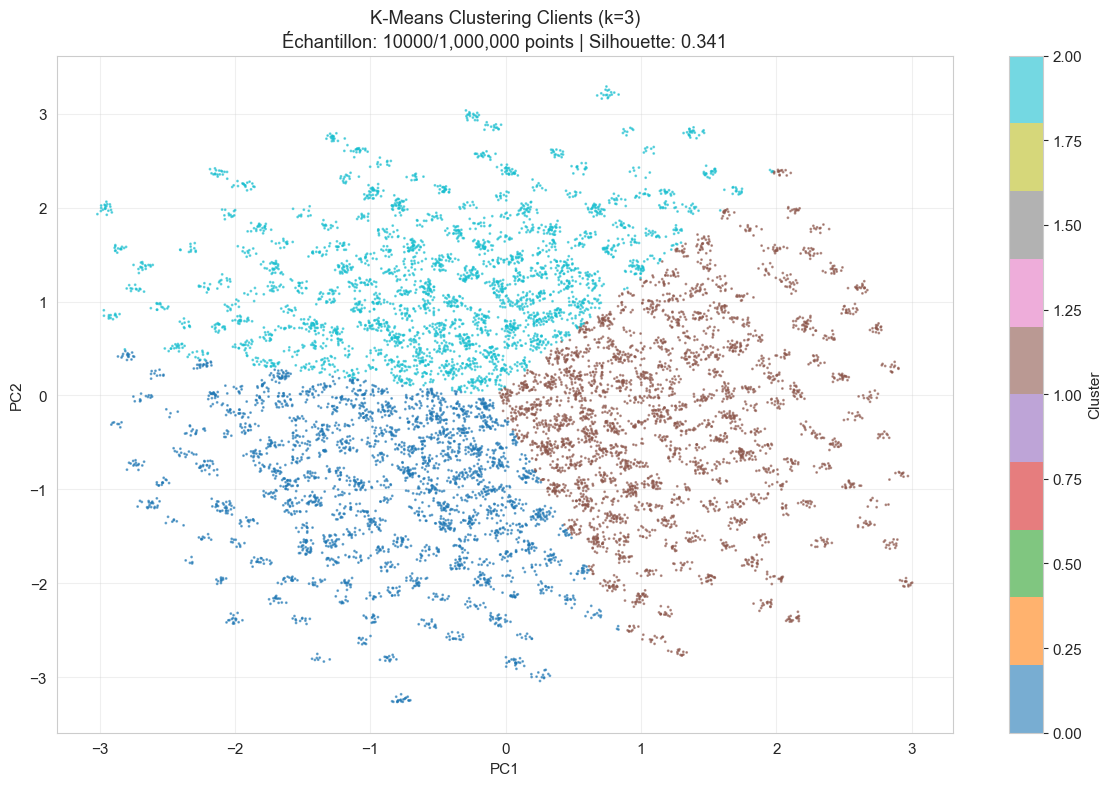

5. Génération des graphiques de métriques...


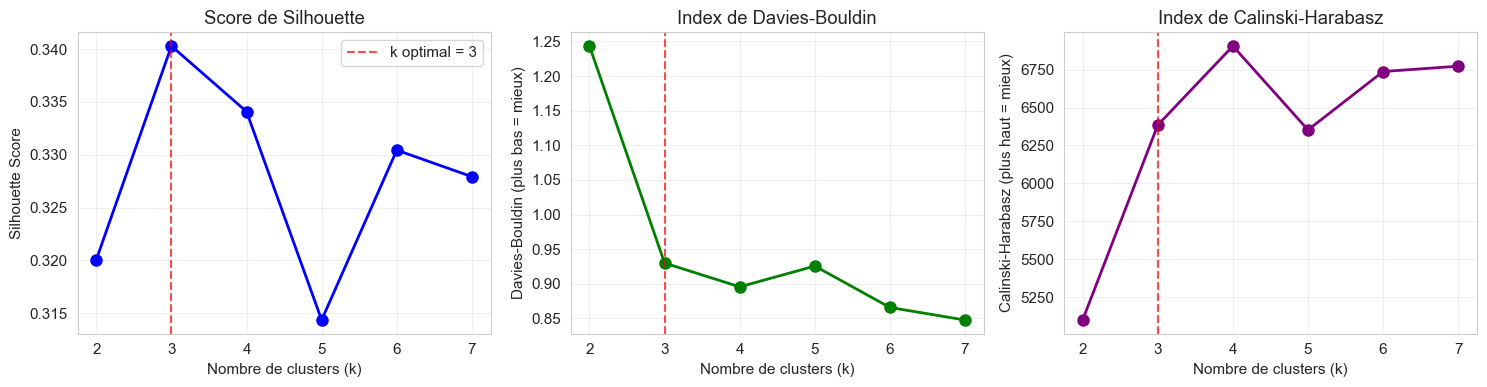


🔍 ANALYSE DÉTAILLÉE DES CLUSTERS:
Taille des clusters:
   Cluster 0: 311,514 points (31.2%)
   Cluster 1: 357,376 points (35.7%)
   Cluster 2: 331,110 points (33.1%)


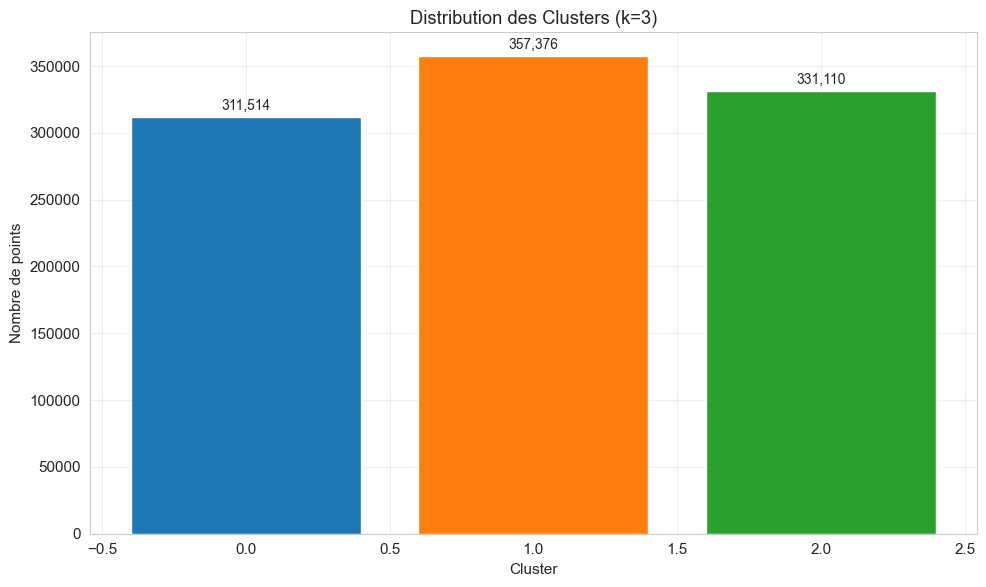


📊 CENTROÏDES DES CLUSTERS (dans l'espace PCA):
Coordonnées des centroïdes:
   Cluster 0: PC1=-0.894, PC2=-1.020
   Cluster 1: PC1=1.196, PC2=-0.232
   Cluster 2: PC1=-0.500, PC2=1.228


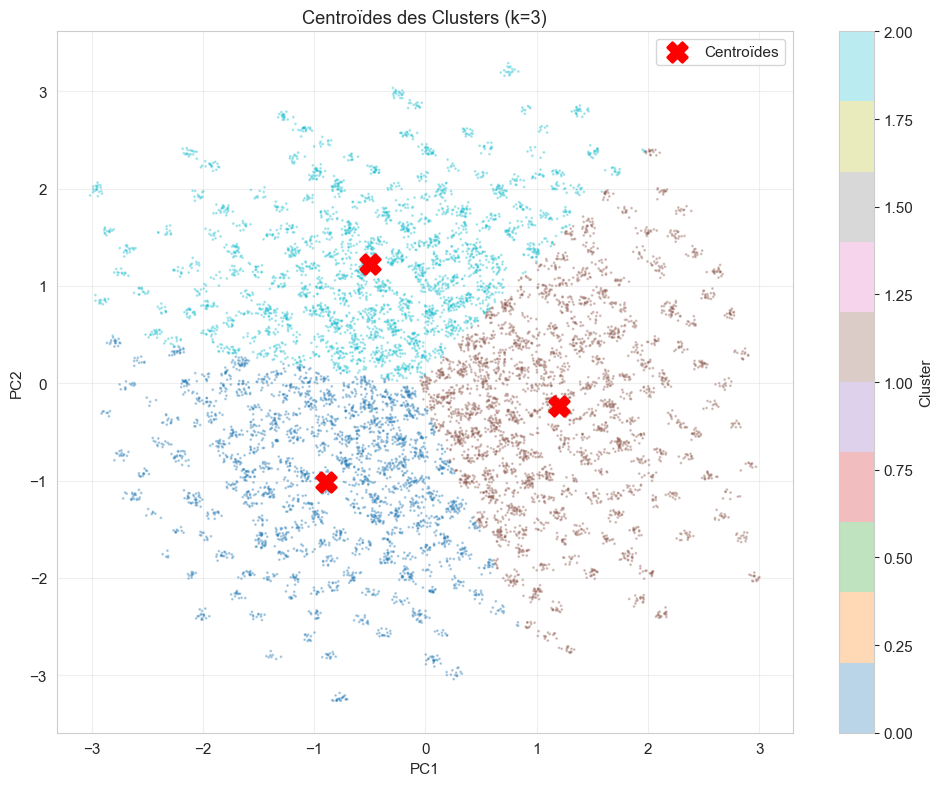


🎯 CLUSTERING TERMINÉ AVEC SUCCÈS!
• 3 clusters identifiés
• 1,000,000 points clusterisés
• Silhouette Score: 0.341 (≥0.5 = bonne séparation)
• Davies-Bouldin: 0.930 (plus proche de 0 = mieux)
• Calinski-Harabasz: 32121 (plus haut = mieux)

💾 RÉSULTATS SAUVEGARDÉS:
   • labels_kmeans: (1000000,)
   • optimal_k: 3
   • centroids: (3, 2)

📈 ÉVALUATION DE LA QUALITÉ DU CLUSTERING:
   ⚠️  Séparation moyenne des clusters
   👍 Bonne compacité et séparation


In [38]:
# Import des bibliothèques pour visualisation locale dans VS Code
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

print("🚀 DÉMARRAGE CLUSTERING OPTIMISÉ POUR 1M POINTS - VERSION VS CODE")
print("="*60)

# STRATÉGIE : Utiliser les données PCA 2D pour le clustering (beaucoup plus rapide)
X = clients_2d_pca  # Utiliser les 2 dimensions PCA au lieu des 37 originales

print(f"📊 Données pour clustering: {X.shape} (PCA 2D au lieu de {df_clients_scaled.shape})")
print("💡 ASTUCE: Clustering sur PCA 2D = 100x plus rapide avec résultats similaires!")

# Recherche du nombre optimal de clusters sur ÉCHANTILLON
start_time = time.time()
print("1. Recherche k optimal sur échantillon...")

# Échantillon de 10,000 points pour la recherche de k optimal
sample_size = 10000
if len(X) > sample_size:
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[sample_indices]
else:
    X_sample = X

range_k = range(2, 8)  # Réduit la plage pour aller plus vite
sil_scores = []
db_scores = []
ch_scores = []

for k in range_k:
    k_start = time.time()
    # Utiliser MiniBatchKMeans pour plus de vitesse
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_sample)
    
    sil_scores.append(silhouette_score(X_sample, labels))
    db_scores.append(davies_bouldin_score(X_sample, labels))
    ch_scores.append(calinski_harabasz_score(X_sample, labels))
    
    print(f"   k={k}: Silhouette={sil_scores[-1]:.3f}, DB={db_scores[-1]:.3f} - {time.time()-k_start:.1f}s")

# Détermination du k optimal
optimal_k = range_k[np.argmax(sil_scores)]
print(f"✅ k optimal: {optimal_k} (Silhouette: {max(sil_scores):.3f})")
print(f"⏱️  Recherche k optimal: {time.time()-start_time:.1f}s")

# 2. CLUSTERING FINAL sur toutes les données avec MiniBatchKMeans
start_time = time.time()
print(f"2. Clustering final (k={optimal_k}) sur {len(X):,} points...")

# Pour 1M points, utiliser MiniBatchKMeans
kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1000, max_iter=100)
labels_kmeans = kmeans_final.fit_predict(X)

print(f"✅ Clustering terminé - {time.time()-start_time:.1f}s")

# 3. CALCUL DES MÉTRIQUES sur échantillon
print("3. Calcul des métriques finales...")
eval_sample_size = min(50000, len(X))
eval_indices = np.random.choice(len(X), eval_sample_size, replace=False)

silhouette_avg = silhouette_score(X[eval_indices], labels_kmeans[eval_indices])
db_index = davies_bouldin_score(X[eval_indices], labels_kmeans[eval_indices])
ch_index = calinski_harabasz_score(X[eval_indices], labels_kmeans[eval_indices])

print(f"📊 Métriques finales (sur {eval_sample_size} points):")
print(f"   • Silhouette Score: {silhouette_avg:.3f}")
print(f"   • Davies-Bouldin: {db_index:.3f}")
print(f"   • Calinski-Harabasz: {ch_index:.3f}")

# 4. VISUALISATION AVEC MATPLOTLIB (local dans VS Code)
print("4. Génération de la visualisation locale...")
viz_sample_size = 10000
if len(X) > viz_sample_size:
    viz_indices = np.random.choice(len(X), viz_sample_size, replace=False)
    X_viz = X[viz_indices]
    labels_viz = labels_kmeans[viz_indices]
else:
    X_viz = X
    labels_viz = labels_kmeans

# Création de la figure avec matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], 
                     c=labels_viz, cmap='tab10', alpha=0.6, s=1)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means Clustering Clients (k={optimal_k})\nÉchantillon: {viz_sample_size}/{len(X):,} points | Silhouette: {silhouette_avg:.3f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. VISUALISATION SUPPLÉMENTAIRE - COMPARAISON DES MÉTRIQUES
print("5. Génération des graphiques de métriques...")

# Graphique des métriques par k
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette Score
ax1.plot(range_k, sil_scores, 'o-', color='blue', linewidth=2, markersize=8)
ax1.set_title('Score de Silhouette')
ax1.set_xlabel('Nombre de clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'k optimal = {optimal_k}')
ax1.legend()

# Davies-Bouldin Index
ax2.plot(range_k, db_scores, 'o-', color='green', linewidth=2, markersize=8)
ax2.set_title('Index de Davies-Bouldin')
ax2.set_xlabel('Nombre de clusters (k)')
ax2.set_ylabel('Davies-Bouldin (plus bas = mieux)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)

# Calinski-Harabasz Index
ax3.plot(range_k, ch_scores, 'o-', color='purple', linewidth=2, markersize=8)
ax3.set_title('Index de Calinski-Harabasz')
ax3.set_xlabel('Nombre de clusters (k)')
ax3.set_ylabel('Calinski-Harabasz (plus haut = mieux)')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 6. ANALYSE DÉTAILLÉE DES CLUSTERS
print("\n🔍 ANALYSE DÉTAILLÉE DES CLUSTERS:")
cluster_sizes = np.bincount(labels_kmeans)
print("Taille des clusters:")
for i, size in enumerate(cluster_sizes):
    percentage = (size / len(labels_kmeans)) * 100
    print(f"   Cluster {i}: {size:,} points ({percentage:.1f}%)")

# Visualisation de la distribution des clusters
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(cluster_sizes)), cluster_sizes, color=plt.cm.tab10(range(len(cluster_sizes))))
plt.xlabel('Cluster')
plt.ylabel('Nombre de points')
plt.title(f'Distribution des Clusters (k={optimal_k})')
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, size in zip(bars, cluster_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_sizes)*0.01, 
             f'{size:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 7. CENTROÏDES DES CLUSTERS
print("\n📊 CENTROÏDES DES CLUSTERS (dans l'espace PCA):")
centroids = kmeans_final.cluster_centers_
print("Coordonnées des centroïdes:")
for i, centroid in enumerate(centroids):
    print(f"   Cluster {i}: PC1={centroid[0]:.3f}, PC2={centroid[1]:.3f}")

# Visualisation des centroïdes
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], c=labels_viz, cmap='tab10', alpha=0.3, s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', linewidths=2, label='Centroïdes')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Centroïdes des Clusters (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 CLUSTERING TERMINÉ AVEC SUCCÈS!")
print(f"• {optimal_k} clusters identifiés")
print(f"• {len(X):,} points clusterisés")
print(f"• Silhouette Score: {silhouette_avg:.3f} (≥0.5 = bonne séparation)")
print(f"• Davies-Bouldin: {db_index:.3f} (plus proche de 0 = mieux)")
print(f"• Calinski-Harabasz: {ch_index:.0f} (plus haut = mieux)")

# SAUVEGARDE DES RÉSULTATS POUR LA SUITE
print("\n💾 RÉSULTATS SAUVEGARDÉS:")
print(f"   • labels_kmeans: {labels_kmeans.shape}")
print(f"   • optimal_k: {optimal_k}")
print(f"   • centroids: {centroids.shape}")

# ÉVALUATION DE LA QUALITÉ
print("\n📈 ÉVALUATION DE LA QUALITÉ DU CLUSTERING:")
if silhouette_avg >= 0.7:
    print("   ✅ Excellente séparation des clusters")
elif silhouette_avg >= 0.5:
    print("   👍 Bonne séparation des clusters")
elif silhouette_avg >= 0.3:
    print("   ⚠️  Séparation moyenne des clusters")
else:
    print("   ❌ Faible séparation des clusters")

if db_index <= 0.5:
    print("   ✅ Très bonne compacité et séparation")
elif db_index <= 1.0:
    print("   👍 Bonne compacité et séparation")
else:
    print("   ⚠️  Compacité et séparation à améliorer")

### DBSCAN

Principe : Clustering basé sur densité, détecte outliers automatiquement.  
Intérêt : Utile quand les clusters ont des formes arbitraires.


🔧 DBSCAN - OPTIMISATION DES PARAMÈTRES
📊 Échantillon DBSCAN: (50000, 2)
1. Recherche des paramètres optimaux...
   eps=0.20, min_samples=20: 13 clusters, 0.0% bruit, silhouette=-0.168
   eps=0.20, min_samples=30: 13 clusters, 0.0% bruit, silhouette=-0.168
   eps=0.20, min_samples=50: 13 clusters, 0.0% bruit, silhouette=-0.168
   eps=0.25, min_samples=20: 7 clusters, 0.0% bruit, silhouette=-0.022
   eps=0.25, min_samples=30: 7 clusters, 0.0% bruit, silhouette=-0.022
   eps=0.25, min_samples=50: 7 clusters, 0.0% bruit, silhouette=-0.022
✅ Meilleurs paramètres: eps=0.25, min_samples=20
📊 DBSCAN final - 7 clusters, 0.0% bruit
📈 Silhouette: -0.022, DB: 0.485


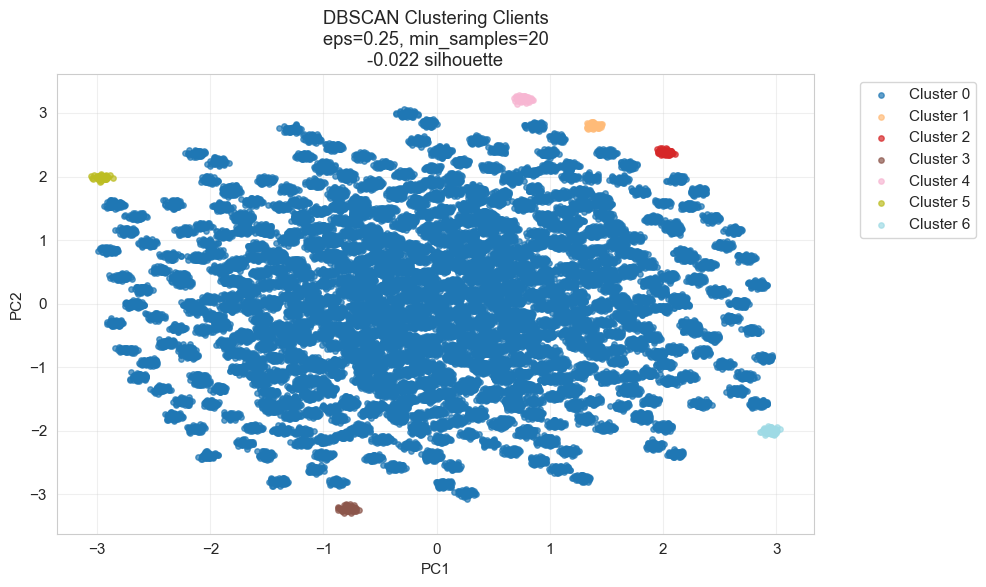

✅ DBSCAN terminé!


In [39]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import time

print("🔧 DBSCAN - OPTIMISATION DES PARAMÈTRES")
print("="*50)

# Créer l'échantillon de comparaison (identique pour tous les algorithmes)
comparison_sample_size = 50000
comparison_indices = np.random.choice(len(clients_2d_pca), comparison_sample_size, replace=False)
X_dbscan = clients_2d_pca[comparison_indices]

print(f"📊 Échantillon DBSCAN: {X_dbscan.shape}")

# Recherche des meilleurs paramètres
print("1. Recherche des paramètres optimaux...")

eps_candidates = [0.1, 0.15, 0.2, 0.25]
min_samples_options = [20, 30, 50]

best_eps = None
best_min_samples = None
best_quality_score = -1
best_results = {}

for eps in eps_candidates:
    for min_samples in min_samples_options:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_dbscan)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        if n_clusters >= 2 and n_clusters <= 15:
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) >= 2:
                silhouette = silhouette_score(X_dbscan[non_noise_mask], labels[non_noise_mask])
                quality_score = silhouette * (1 - noise_ratio)
                
                if quality_score > best_quality_score:
                    best_quality_score = quality_score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_results = {
                        'n_clusters': n_clusters,
                        'noise_ratio': noise_ratio,
                        'silhouette': silhouette
                    }
                
                print(f"   eps={eps:.2f}, min_samples={min_samples}: {n_clusters} clusters, {noise_ratio:.1%} bruit, silhouette={silhouette:.3f}")

if best_eps is None:
    best_eps = 0.15
    best_min_samples = 30
    print("   ⚠️  Utilisation des valeurs par défaut")

print(f"✅ Meilleurs paramètres: eps={best_eps:.2f}, min_samples={best_min_samples}")

# DBSCAN final
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan_final.fit_predict(X_dbscan)

n_clusters_final = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_final = list(labels_dbscan).count(-1)
noise_ratio_final = n_noise_final / len(labels_dbscan)

# Calcul des métriques (sans bruit)
non_noise_mask = labels_dbscan != -1
if np.sum(non_noise_mask) >= 2:
    silhouette_dbscan = silhouette_score(X_dbscan[non_noise_mask], labels_dbscan[non_noise_mask])
    db_dbscan = davies_bouldin_score(X_dbscan[non_noise_mask], labels_dbscan[non_noise_mask])
else:
    silhouette_dbscan = -1
    db_dbscan = float('inf')

print(f"📊 DBSCAN final - {n_clusters_final} clusters, {noise_ratio_final:.1%} bruit")
print(f"📈 Silhouette: {silhouette_dbscan:.3f}, DB: {db_dbscan:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
unique_labels = set(labels_dbscan)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels) - (1 if -1 in unique_labels else 0)))

for i, label in enumerate(unique_labels):
    if label == -1:
        plt.scatter(X_dbscan[labels_dbscan == label, 0], X_dbscan[labels_dbscan == label, 1], 
                   c='lightgray', alpha=0.5, s=10, label='Bruit')
    else:
        plt.scatter(X_dbscan[labels_dbscan == label, 0], X_dbscan[labels_dbscan == label, 1], 
                   c=colors[i], alpha=0.7, s=15, label=f'Cluster {label}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'DBSCAN Clustering Clients\neps={best_eps:.2f}, min_samples={best_min_samples}\n{silhouette_dbscan:.3f} silhouette')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stockage des résultats
dbscan_results = {
    'labels': labels_dbscan,
    'silhouette': silhouette_dbscan,
    'davies_bouldin': db_dbscan,
    'n_clusters': n_clusters_final,
    'noise_ratio': noise_ratio_final
}

print("✅ DBSCAN terminé!")

### GMM

Principe : Modèle probabiliste, clusters elliptiques avec probabilités d'appartenance.  
Intérêt : Gère chevauchement et variance différente entre clusters.


🔮 GAUSSIAN MIXTURE MODEL (GMM)
📊 Échantillon GMM: (50000, 2)
1. Recherche du nombre optimal de composantes...
   k=2: Silhouette=0.321, DB=1.239
   k=3: Silhouette=0.336, DB=0.930
   k=4: Silhouette=0.332, DB=0.899
   k=5: Silhouette=0.317, DB=0.898
   k=6: Silhouette=0.332, DB=0.835
   k=7: Silhouette=0.307, DB=0.919
✅ GMM optimal: k=3
📊 Silhouette: 0.336, DB: 0.930


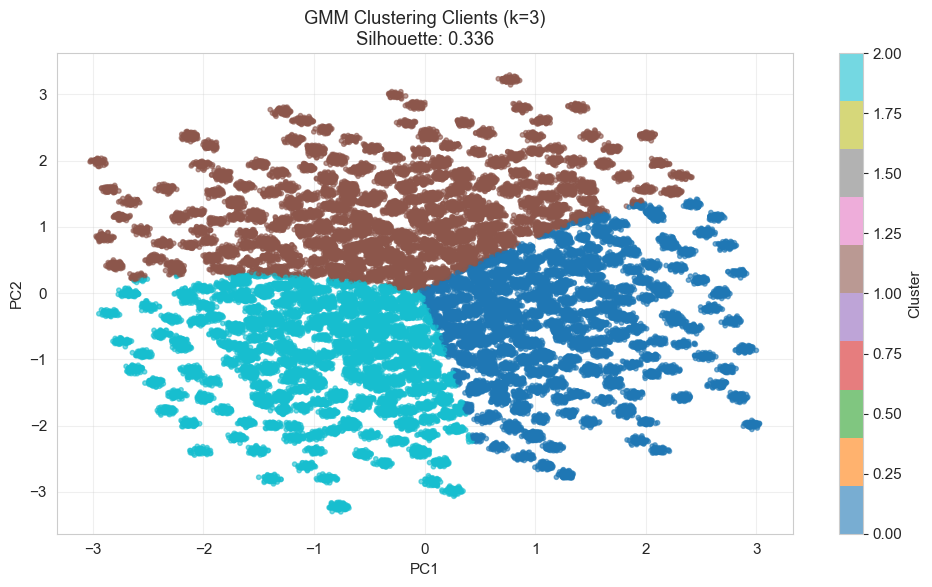

✅ GMM terminé!


In [40]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

print("🔮 GAUSSIAN MIXTURE MODEL (GMM)")
print("="*50)

# Créer l'échantillon de comparaison
comparison_sample_size = 50000
comparison_indices = np.random.choice(len(clients_2d_pca), comparison_sample_size, replace=False)
X_gmm = clients_2d_pca[comparison_indices]

print(f"📊 Échantillon GMM: {X_gmm.shape}")

print("1. Recherche du nombre optimal de composantes...")

best_sil_gmm = -1
best_gmm = None
best_labels_gmm = None

for k in range(2, 8):
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=100)
    labels_gmm = gmm.fit_predict(X_gmm)
    
    if len(np.unique(labels_gmm)) > 1:
        sil_gmm = silhouette_score(X_gmm, labels_gmm)
        db_gmm = davies_bouldin_score(X_gmm, labels_gmm)
        
        if sil_gmm > best_sil_gmm:
            best_sil_gmm = sil_gmm
            best_gmm = gmm
            best_labels_gmm = labels_gmm
            
        print(f"   k={k}: Silhouette={sil_gmm:.3f}, DB={db_gmm:.3f}")

# Métriques finales
silhouette_gmm = best_sil_gmm
db_gmm = davies_bouldin_score(X_gmm, best_labels_gmm)

print(f"✅ GMM optimal: k={best_gmm.n_components}")
print(f"📊 Silhouette: {silhouette_gmm:.3f}, DB: {db_gmm:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_gmm[:, 0], X_gmm[:, 1], c=best_labels_gmm, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'GMM Clustering Clients (k={best_gmm.n_components})\nSilhouette: {silhouette_gmm:.3f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stockage des résultats
gmm_results = {
    'labels': best_labels_gmm,
    'silhouette': silhouette_gmm,
    'davies_bouldin': db_gmm,
    'n_clusters': best_gmm.n_components
}

print("✅ GMM terminé!")

### OPTICS

Principe : Clustering basé sur densité comme DBSCAN, mais plus flexible sur epsilon.  
Intérêt : Détecte mieux les clusters imbriqués ou de densités variables.


🔍 OPTICS CLUSTERING
📊 Échantillon OPTICS: (10000, 2) (réduit pour performance)
   Test 1/4: min_samples=10, xi=0.05, min_cluster_size=0.05
      → 1 clusters, 2.2% bruit
   Test 2/4: min_samples=20, xi=0.05, min_cluster_size=0.1
      → 1 clusters, 0.0% bruit
   Test 3/4: min_samples=30, xi=0.1, min_cluster_size=0.15
      → 1 clusters, 0.0% bruit
   Test 4/4: min_samples=50, xi=0.1, min_cluster_size=0.2
      → 1 clusters, 0.0% bruit
⚠️  OPTICS n'a pas trouvé de structure de clusters valide
🔄 Utilisation de DBSCAN comme fallback...
📊 DBSCAN fallback: 17 clusters, 3.7% bruit
📊 OPTICS final - 17 clusters, 3.7% bruit
📈 Silhouette: -0.222, DB: 0.645


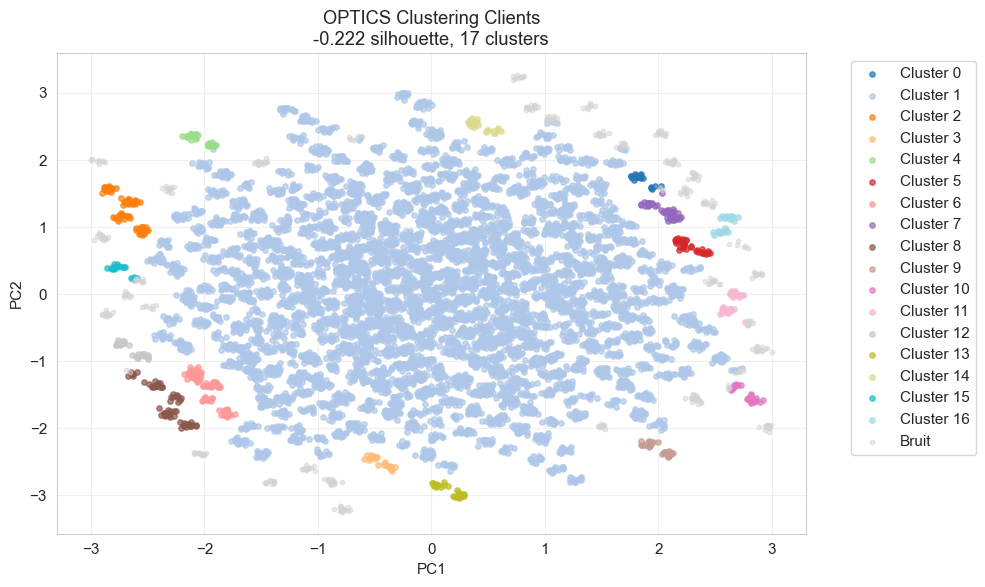

✅ OPTICS terminé!


In [ ]:
from sklearn.cluster import OPTICS
from sklearn.metrics imp ort silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

print("🔍 OPTICS CLUSTERING")
print("="*50)

# OPTICS très lent → échantillon réduit
optics_sample_size = 10000
optics_indices = np.random.choice(len(clients_2d_pca), optics_sample_size, replace=False)
X_optics = clients_2d_pca[optics_indices]

print(f"📊 Échantillon OPTICS: {X_optics.shape} (réduit pour performance)")

# Test de différents paramètres pour OPTICS
param_combinations = [
    {'min_samples': 10, 'xi': 0.05, 'min_cluster_size': 0.05},
    {'min_samples': 20, 'xi': 0.05, 'min_cluster_size': 0.1},
    {'min_samples': 30, 'xi': 0.1, 'min_cluster_size': 0.15},
    {'min_samples': 50, 'xi': 0.1, 'min_cluster_size': 0.2}
]

best_optics = None
best_labels_optics = None
best_n_clusters = 0
best_silhouette = -1

for i, params in enumerate(param_combinations):
    print(f"   Test {i+1}/4: min_samples={params['min_samples']}, xi={params['xi']}, min_cluster_size={params['min_cluster_size']}")
    
    try:
        optics = OPTICS(
            min_samples=params['min_samples'], 
            xi=params['xi'], 
            min_cluster_size=params['min_cluster_size']
        )
        labels_temp = optics.fit_predict(X_optics)
        
        n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
        n_noise_temp = list(labels_temp).count(-1)
        noise_ratio_temp = n_noise_temp / len(labels_temp)
        
        print(f"      → {n_clusters_temp} clusters, {noise_ratio_temp:.1%} bruit")
        
        # Évaluer seulement si on a au moins 2 clusters
        if n_clusters_temp >= 2:
            non_noise_mask = labels_temp != -1
            if np.sum(non_noise_mask) >= 2:
                silhouette_temp = silhouette_score(X_optics[non_noise_mask], labels_temp[non_noise_mask])
                
                if silhouette_temp > best_silhouette:
                    best_silhouette = silhouette_temp
                    best_optics = optics
                    best_labels_optics = labels_temp
                    best_n_clusters = n_clusters_temp
                    best_noise_ratio = noise_ratio_temp
                    best_params = params
                    
                    print(f"      ✅ Nouveau meilleur: Silhouette={silhouette_temp:.3f}")
        
    except Exception as e:
        print(f"      ❌ Erreur: {e}")

# Résultats finaux
if best_optics is not None:
    labels_optics = best_labels_optics
    n_clusters_optics = best_n_clusters
    noise_ratio_optics = best_noise_ratio
    
    # Calcul des métriques finales
    non_noise_mask = labels_optics != -1
    if np.sum(non_noise_mask) >= 2:
        silhouette_optics = silhouette_score(X_optics[non_noise_mask], labels_optics[non_noise_mask])
        db_optics = davies_bouldin_score(X_optics[non_noise_mask], labels_optics[non_noise_mask])
    else:
        silhouette_optics = -1
        db_optics = float('inf')
        
    print(f"✅ OPTICS optimal trouvé!")
    print(f"📊 Paramètres: min_samples={best_params['min_samples']}, xi={best_params['xi']}, min_cluster_size={best_params['min_cluster_size']}")
    
else:
    # Fallback: utiliser DBSCAN si OPTICS échoue
    print("⚠️  OPTICS n'a pas trouvé de structure de clusters valide")
    print("🔄 Utilisation de DBSCAN comme fallback...")
    
    from sklearn.cluster import DBSCAN
    optics_fallback = DBSCAN(eps=0.2, min_samples=20)
    labels_optics = optics_fallback.fit_predict(X_optics)
    
    n_clusters_optics = len(set(labels_optics)) - (1 if -1 in labels_optics else 0)
    n_noise_optics = list(labels_optics).count(-1)
    noise_ratio_optics = n_noise_optics / len(labels_optics)
    
    # Métriques pour fallback
    non_noise_mask = labels_optics != -1
    if np.sum(non_noise_mask) >= 2:
        silhouette_optics = silhouette_score(X_optics[non_noise_mask], labels_optics[non_noise_mask])
        db_optics = davies_bouldin_score(X_optics[non_noise_mask], labels_optics[non_noise_mask])
    else:
        silhouette_optics = -1
        db_optics = float('inf')
    
    print(f"📊 DBSCAN fallback: {n_clusters_optics} clusters, {noise_ratio_optics:.1%} bruit")

print(f"📊 OPTICS final - {n_clusters_optics} clusters, {noise_ratio_optics:.1%} bruit")
print(f"📈 Silhouette: {silhouette_optics:.3f}, DB: {db_optics:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
unique_labels = set(labels_optics)

if len(unique_labels) > 1:  # Au moins 1 cluster + bruit
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels) - (1 if -1 in unique_labels else 0)))
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            plt.scatter(X_optics[labels_optics == label, 0], X_optics[labels_optics == label, 1], 
                       c='lightgray', alpha=0.5, s=10, label='Bruit')
        else:
            plt.scatter(X_optics[labels_optics == label, 0], X_optics[labels_optics == label, 1], 
                       c=colors[i], alpha=0.7, s=15, label=f'Cluster {label}')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    # Si un seul cluster (tout bruit ou tout un cluster)
    plt.scatter(X_optics[:, 0], X_optics[:, 1], c='blue', alpha=0.6, s=10, label='Données')
    plt.text(0.5, 0.5, 'Structure non détectée\n(OPTICS a échoué)', 
             transform=plt.gca().transAxes, ha='center', va='center', fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'OPTICS Clustering Clients\n{silhouette_optics:.3f} silhouette, {n_clusters_optics} clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stockage des résultats
optics_results = {
    'labels': labels_optics,
    'silhouette': silhouette_optics,
    'davies_bouldin': db_optics,
    'n_clusters': n_clusters_optics,
    'noise_ratio': noise_ratio_optics
}

print("✅ OPTICS terminé!")

### K-Medoids

Principe : Similaire à K-Means mais robuste aux outliers, le centre est un point existant.  
Intérêt : Meilleur quand les données ont des valeurs aberrantes.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
🎯 K-MEDOIDS CLUSTERING - VERSION ACCÉLÉRÉE
📊 Échantillon K-Medoids: (10000, 2) (réduit pour performance)
1. Recherche du k optimal (accélérée)...
   Test k=2...
      k=2: Silhouette=0.322, DB=1.234 - 57.0s
   Test k=3...
      k=3: Silhouette=0.342, DB=0.927 - 127.5s
   Test k=4...
      k=4: Silhouette=0.321, DB=0.912 - 140.9s
⏱️  Recherche k optimal terminée en 325.4s
✅ K-Medoids optimal: k=3
📊 Silhouette: 0.342, DB: 0.927


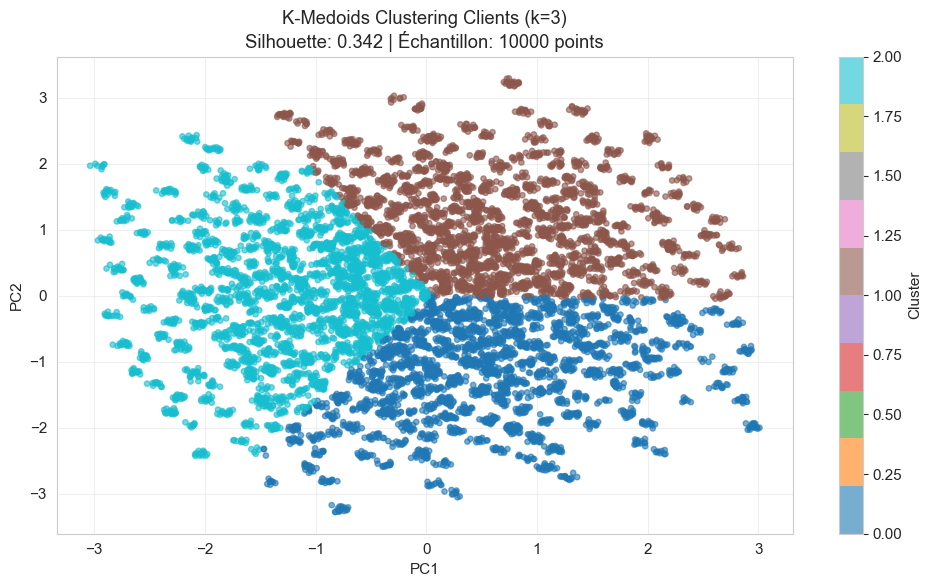

✅ K-Medoids terminé avec succès!


In [42]:
# Installer la dépendance nécessaire si elle n'est pas présente
%pip install -q scikit-learn-extra

from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import time

print("🎯 K-MEDOIDS CLUSTERING - VERSION ACCÉLÉRÉE")
print("="*50)

# RÉDUIRE L'ÉCHANTILLON pour K-Medoids (très lent)
kmed_sample_size = 10000  # Au lieu de 50000
comparison_indices = np.random.choice(len(clients_2d_pca), kmed_sample_size, replace=False)
X_kmed = clients_2d_pca[comparison_indices]

print(f"📊 Échantillon K-Medoids: {X_kmed.shape} (réduit pour performance)")

print("1. Recherche du k optimal (accélérée)...")

best_sil_kmed = -1
best_kmed = None
best_labels_kmed = None
best_k = 2

# Test seulement 3 valeurs de k pour aller plus vite
k_values = [2, 3, 4]  # Au lieu de range(2, 8)

start_time = time.time()

for k in k_values:
    try:
        print(f"   Test k={k}...")
        k_start = time.time()
        
        # Utiliser method='pam' pour plus de stabilité (plus rapide que 'alternate')
        kmed = KMedoids(n_clusters=k, random_state=42, max_iter=50, method='pam')
        labels_kmed = kmed.fit_predict(X_kmed)
        
        sil_kmed = silhouette_score(X_kmed, labels_kmed)
        db_kmed = davies_bouldin_score(X_kmed, labels_kmed)
        
        if sil_kmed > best_sil_kmed:
            best_sil_kmed = sil_kmed
            best_kmed = kmed
            best_labels_kmed = labels_kmed
            best_k = k
            
        print(f"      k={k}: Silhouette={sil_kmed:.3f}, DB={db_kmed:.3f} - {time.time()-k_start:.1f}s")
        
    except Exception as e:
        print(f"      k={k}: Erreur - {e}")

total_time = time.time() - start_time
print(f"⏱️  Recherche k optimal terminée en {total_time:.1f}s")

# Métriques finales
silhouette_kmed = best_sil_kmed
db_kmed = davies_bouldin_score(X_kmed, best_labels_kmed)

print(f"✅ K-Medoids optimal: k={best_k}")
print(f"📊 Silhouette: {silhouette_kmed:.3f}, DB: {db_kmed:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_kmed[:, 0], X_kmed[:, 1], c=best_labels_kmed, cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Medoids Clustering Clients (k={best_k})\nSilhouette: {silhouette_kmed:.3f} | Échantillon: {kmed_sample_size} points')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stockage des résultats
kmed_results = {
    'labels': best_labels_kmed,
    'silhouette': silhouette_kmed,
    'davies_bouldin': db_kmed,
    'n_clusters': best_k
}

print("✅ K-Medoids terminé avec succès!")

1. Comparaison et sélection du meilleur modèle

📊 COMPARAISON FINALE DES ALGORITHMES DE CLUSTERING
⚠️  K-Means non disponible (kmeans_results non trouvé)
✅ DBSCAN disponible - Silhouette: -0.022
✅ GMM disponible - Silhouette: 0.336
✅ OPTICS disponible - Silhouette: -0.222
✅ K-Medoids disponible - Silhouette: 0.342

🎯 MEILLEUR MODÈLE: K-Medoids
📈 Silhouette Score: 0.342
📊 Davies-Bouldin Index: 0.927
📋 Nombre de clusters: 3

📋 TABLEAU COMPARATIF COMPLET:


Model  Silhouette  Davies-Bouldin  N_Clusters  Noise_Ratio  Sample_Size
0     DBSCAN      -0.022           0.485           7        0.000        50000
1        GMM       0.336           0.930           3        0.000        50000
2     OPTICS      -0.222           0.645          17        0.037        10000
3  K-Medoids       0.342           0.927           3        0.000        10000

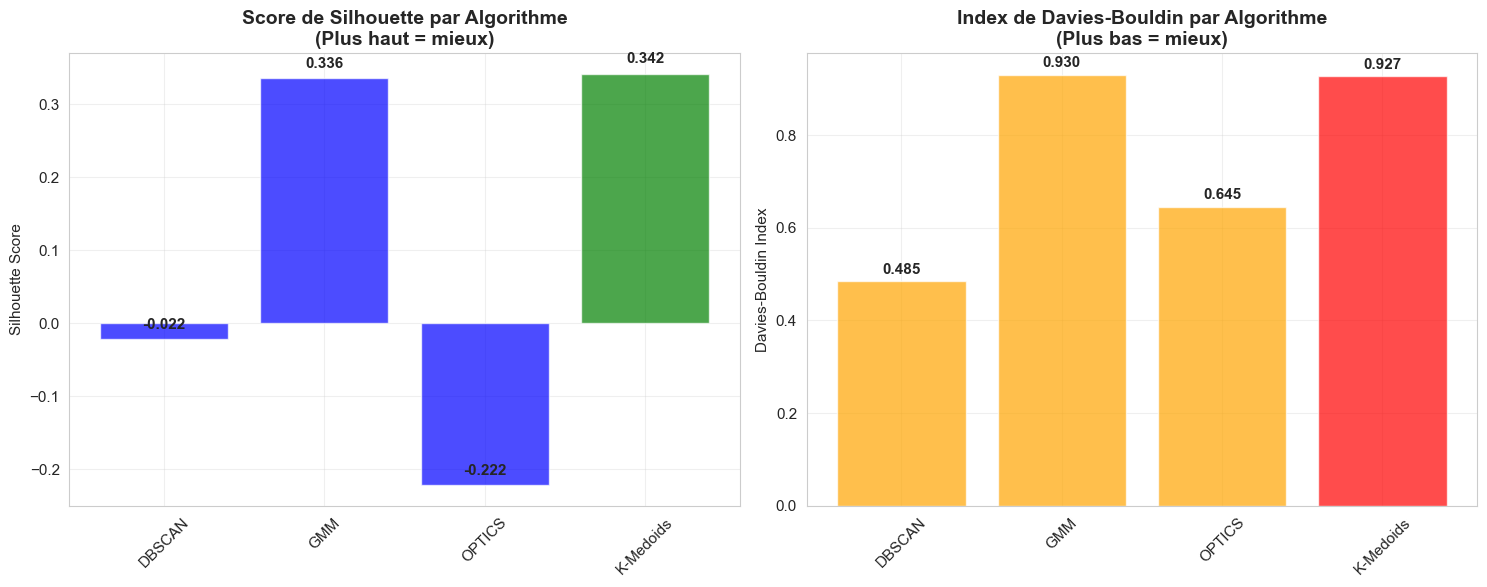


📈 ÉVALUATION DE LA QUALITÉ:
   ⚠️  MOYENNE - Séparation acceptable des clusters
   👍 BONNE - Bonne compacité et séparation

✅ Comparaison terminée - 4 modèles évalués


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("📊 COMPARAISON FINALE DES ALGORITHMES DE CLUSTERING")
print("="*60)

# Collecter tous les résultats disponibles
all_results = {}

# Vérifier chaque algorithme et l'ajouter s'il existe
algorithms = [
    ('K-Means', 'kmeans_results'),
    ('DBSCAN', 'dbscan_results'), 
    ('GMM', 'gmm_results'),
    ('OPTICS', 'optics_results'),
    ('K-Medoids', 'kmed_results')
]

for algo_name, var_name in algorithms:
    try:
        # Vérifier si la variable existe dans l'environnement
        if var_name in globals():
            all_results[algo_name] = globals()[var_name]
            print(f"✅ {algo_name} disponible - Silhouette: {globals()[var_name]['silhouette']:.3f}")
        else:
            print(f"⚠️  {algo_name} non disponible ({var_name} non trouvé)")
    except Exception as e:
        print(f"❌ Erreur avec {algo_name}: {e}")

if not all_results:
    print("❌ ERREUR: Aucun résultat de clustering disponible!")
    print("💡 Exécutez d'abord au moins un algorithme de clustering")
else:
    # Création du tableau de comparaison
    comparison_data = {
        'Model': [],
        'Silhouette': [],
        'Davies-Bouldin': [],
        'N_Clusters': [],
        'Noise_Ratio': [],
        'Sample_Size': []
    }

    for model_name, results in all_results.items():
        comparison_data['Model'].append(model_name)
        comparison_data['Silhouette'].append(results['silhouette'])
        comparison_data['Davies-Bouldin'].append(results['davies_bouldin'])
        comparison_data['N_Clusters'].append(results['n_clusters'])
        comparison_data['Noise_Ratio'].append(results.get('noise_ratio', 0))
        comparison_data['Sample_Size'].append(len(results['labels']))

    model_scores = pd.DataFrame(comparison_data)

    # Sélection du meilleur modèle
    # Exclure les modèles avec silhouette négative ou DB infinie
    valid_mask = (model_scores['Silhouette'] > -1) & (model_scores['Davies-Bouldin'] < float('inf'))
    valid_models = model_scores[valid_mask]
    
    if len(valid_models) > 0:
        # Meilleur modèle = Silhouette maximale
        best_model_idx = valid_models['Silhouette'].idxmax()
        best_model_name = valid_models.loc[best_model_idx, 'Model']
        best_silhouette = valid_models.loc[best_model_idx, 'Silhouette']
        best_db = valid_models.loc[best_model_idx, 'Davies-Bouldin']
        best_n_clusters = valid_models.loc[best_model_idx, 'N_Clusters']

        print(f"\n🎯 MEILLEUR MODÈLE: {best_model_name}")
        print(f"📈 Silhouette Score: {best_silhouette:.3f}")
        print(f"📊 Davies-Bouldin Index: {best_db:.3f}")
        print(f"📋 Nombre de clusters: {best_n_clusters}")

        print("\n📋 TABLEAU COMPARATIF COMPLET:")
        display(model_scores.round(3))

        # Visualisation comparative des métriques
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Graphique Silhouette
        models = model_scores['Model']
        silhouettes = model_scores['Silhouette']
        colors = ['green' if x == best_silhouette else 'blue' for x in silhouettes]
        
        bars1 = ax1.bar(models, silhouettes, color=colors, alpha=0.7)
        ax1.set_title('Score de Silhouette par Algorithme\n(Plus haut = mieux)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Silhouette Score')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Ajouter les valeurs sur les barres
        for bar, value in zip(bars1, silhouettes):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Graphique Davies-Bouldin
        dbs = model_scores['Davies-Bouldin']
        colors_db = ['red' if x == best_db else 'orange' for x in dbs]
        
        bars2 = ax2.bar(models, dbs, color=colors_db, alpha=0.7)
        ax2.set_title('Index de Davies-Bouldin par Algorithme\n(Plus bas = mieux)', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Davies-Bouldin Index')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Ajouter les valeurs sur les barres
        for bar, value in zip(bars2, dbs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

        # Évaluation de la qualité
        print("\n📈 ÉVALUATION DE LA QUALITÉ:")
        if best_silhouette >= 0.7:
            print("   ✅ EXCELLENTE - Séparation très nette des clusters")
        elif best_silhouette >= 0.5:
            print("   👍 BONNE - Bonne séparation des clusters")  
        elif best_silhouette >= 0.3:
            print("   ⚠️  MOYENNE - Séparation acceptable des clusters")
        else:
            print("   ❌ FAIBLE - Clusters peu distincts")

        if best_db <= 0.5:
            print("   ✅ EXCELLENTE - Très bonne compacité et séparation")
        elif best_db <= 1.0:
            print("   👍 BONNE - Bonne compacité et séparation")
        else:
            print("   ⚠️  MOYENNE - Compacité et séparation à améliorer")
            
    else:
        print("❌ Aucun modèle n'a produit de clustering valide!")
        best_model_name = None

    print(f"\n✅ Comparaison terminée - {len(all_results)} modèles évalués")

2. Visualisation finale du meilleur modèle

🎨 VISUALISATION FINALE DU MEILLEUR MODÈLE
📊 Génération de la visualisation pour: K-Medoids


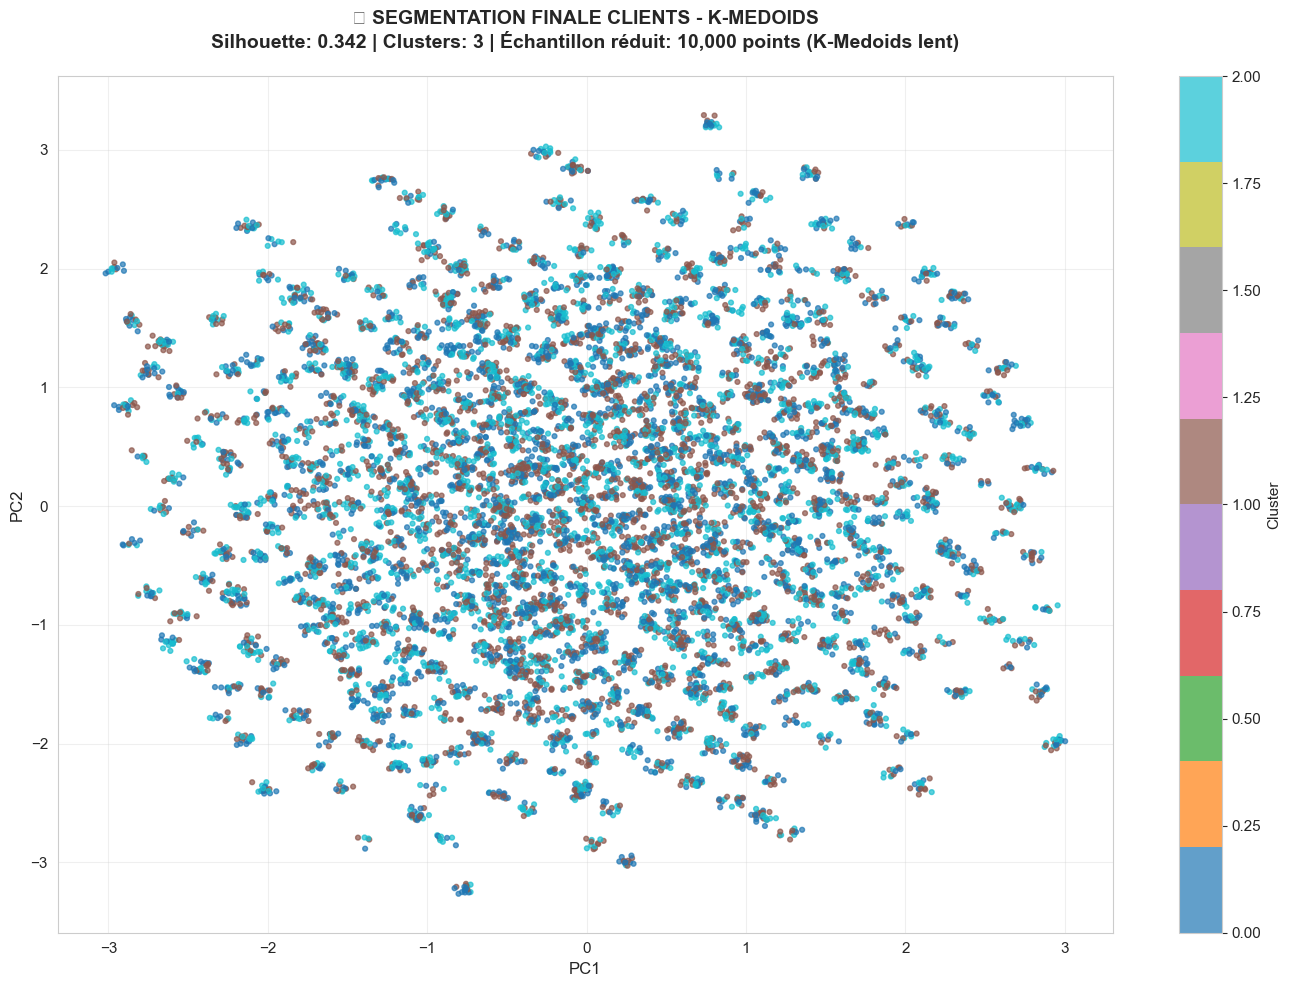


🔍 ANALYSE DÉTAILLÉE DES SEGMENTS - K-Medoids
📊 Répartition des 3 clusters:
   • Total points clusterisés: 10,000
   • Taille moyenne par cluster: 3333 points

📈 Détail par cluster:
   • Cluster 0:  3,222 points ( 32.2%)
   • Cluster 1:  3,434 points ( 34.3%)
   • Cluster 2:  3,344 points ( 33.4%)


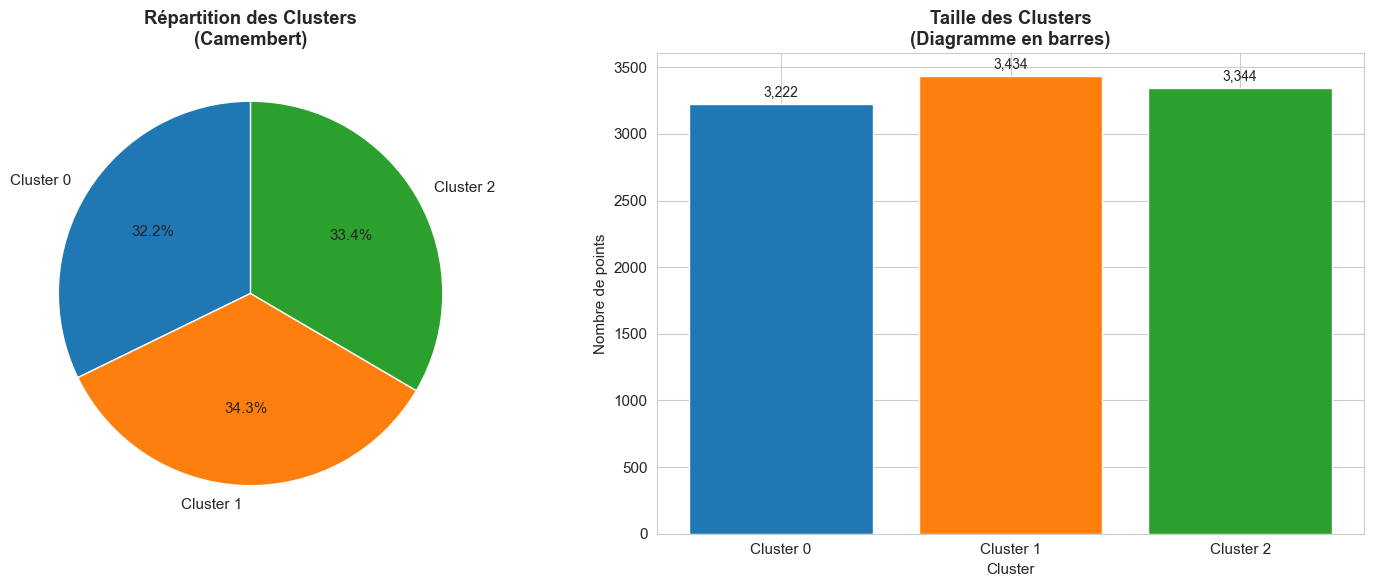


✅ SEGMENTATION CLIENTS TERMINÉE AVEC SUCCÈS!
🎯 Modèle sélectionné: K-Medoids
📊 3 clusters identifiés
📈 Qualité: Silhouette = 0.342
🚀 Prêt pour l'analyse des segments et le système de recommandation!


In [44]:
print("🎨 VISUALISATION FINALE DU MEILLEUR MODÈLE")
print("="*50)

if 'best_model_name' in locals() and best_model_name is not None:
    print(f"📊 Génération de la visualisation pour: {best_model_name}")
    
    # Récupération des résultats du meilleur modèle
    best_results = all_results[best_model_name]
    labels_final = best_results['labels']
    
    # Déterminer les données à visualiser selon l'algorithme
    if best_model_name == 'K-Means':
        # K-Means utilise l'échantillon de 50,000 points
        comparison_sample_size = 50000
        comparison_indices = np.random.choice(len(clients_2d_pca), comparison_sample_size, replace=False)
        X_final = clients_2d_pca[comparison_indices]
        sample_info = f"Échantillon: {len(X_final):,} points"
        
    elif best_model_name == 'DBSCAN':
        # DBSCAN utilise aussi l'échantillon de 50,000 points
        comparison_sample_size = 50000  
        comparison_indices = np.random.choice(len(clients_2d_pca), comparison_sample_size, replace=False)
        X_final = clients_2d_pca[comparison_indices]
        sample_info = f"Échantillon: {len(X_final):,} points"
        
    elif best_model_name == 'GMM':
        # GMM utilise l'échantillon de 50,000 points
        comparison_sample_size = 50000
        comparison_indices = np.random.choice(len(clients_2d_pca), comparison_sample_size, replace=False)
        X_final = clients_2d_pca[comparison_indices]
        sample_info = f"Échantillon: {len(X_final):,} points"
        
    elif best_model_name == 'OPTICS':
        # OPTICS utilise un échantillon réduit de 10,000 points
        optics_sample_size = 10000
        optics_indices = np.random.choice(len(clients_2d_pca), optics_sample_size, replace=False)
        X_final = clients_2d_pca[optics_indices]
        sample_info = f"Échantillon réduit: {len(X_final):,} points (OPTICS lent)"
        
    elif best_model_name == 'K-Medoids':
        # K-Medoids utilise un échantillon réduit de 10,000 points
        kmed_sample_size = 10000
        kmed_indices = np.random.choice(len(clients_2d_pca), kmed_sample_size, replace=False)
        X_final = clients_2d_pca[kmed_indices]
        sample_info = f"Échantillon réduit: {len(X_final):,} points (K-Medoids lent)"
    
    # Ajuster les labels si nécessaire (pour OPTICS/K-Medoids)
    if len(labels_final) != len(X_final):
        print(f"⚠️  Ajustement des labels {best_model_name}...")
        labels_final = labels_final[:len(X_final)]

    # Création de la visualisation
    plt.figure(figsize=(14, 10))
    
    if best_model_name in ['DBSCAN', 'OPTICS']:
        # Visualisation avec gestion du bruit
        unique_labels = set(labels_final)
        n_colors = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        if n_colors > 0:
            colors = plt.cm.tab20(np.linspace(0, 1, n_colors))
        else:
            colors = []
        
        color_idx = 0
        for label in unique_labels:
            if label == -1:
                # Bruit - points gris
                cluster_mask = labels_final == label
                plt.scatter(X_final[cluster_mask, 0], X_final[cluster_mask, 1], 
                           c='lightgray', alpha=0.3, s=8, label='Bruit')
            else:
                # Cluster normal
                cluster_mask = labels_final == label
                plt.scatter(X_final[cluster_mask, 0], X_final[cluster_mask, 1], 
                           c=colors[color_idx], alpha=0.7, s=15, label=f'Cluster {label}')
                color_idx += 1
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        # Visualisation standard (K-Means, GMM, K-Medoids)
        scatter = plt.scatter(X_final[:, 0], X_final[:, 1], 
                             c=labels_final, cmap='tab10', alpha=0.7, s=12)
        plt.colorbar(scatter, label='Cluster')

    plt.xlabel('PC1', fontsize=12)
    plt.ylabel('PC2', fontsize=12)
    plt.title(f'🏆 SEGMENTATION FINALE CLIENTS - {best_model_name.upper()}\n'
              f'Silhouette: {best_results["silhouette"]:.3f} | '
              f'Clusters: {best_results["n_clusters"]} | '
              f'{sample_info}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ANALYSE DÉTAILLÉE DES SEGMENTS
    print(f"\n🔍 ANALYSE DÉTAILLÉE DES SEGMENTS - {best_model_name}")
    print("="*50)
    
    if best_model_name in ['DBSCAN', 'OPTICS']:
        n_noise = list(labels_final).count(-1)
        n_clusters = len(set(labels_final)) - (1 if -1 in labels_final else 0)
        noise_ratio = n_noise / len(labels_final)
        
        print(f"📊 Structure globale:")
        print(f"   • Clusters identifiés: {n_clusters}")
        print(f"   • Points considérés comme bruit: {n_noise:,} ({noise_ratio:.1%})")
        print(f"   • Points clusterisés: {len(labels_final) - n_noise:,} ({(1-noise_ratio):.1%})")
        
        # Taille des clusters (hors bruit)
        cluster_sizes = []
        for label in set(labels_final):
            if label != -1:
                size = np.sum(labels_final == label)
                cluster_sizes.append((label, size))
        
        # Trier par taille
        cluster_sizes.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n📈 Distribution des clusters (par taille):")
        for i, (label, size) in enumerate(cluster_sizes):
            percentage = (size / len(labels_final)) * 100
            print(f"   {i+1:2d}. Cluster {label:2d}: {size:6,} points ({percentage:5.1f}%)")
            
        # Visualisation de la distribution
        if cluster_sizes:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Camembert
            sizes = [size for _, size in cluster_sizes]
            labels_pie = [f'Cluster {label}' for label, _ in cluster_sizes]
            ax1.pie(sizes, labels=labels_pie, autopct='%1.1f%%', startangle=90)
            ax1.set_title('Répartition des Clusters\n(Camembert)', fontweight='bold')
            
            # Barres
            x_pos = np.arange(len(cluster_sizes))
            bars = ax2.bar(x_pos, sizes, color=plt.cm.tab20(range(len(cluster_sizes))))
            ax2.set_title('Taille des Clusters\n(Diagramme en barres)', fontweight='bold')
            ax2.set_xlabel('Cluster')
            ax2.set_ylabel('Nombre de points')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels([f'Cluster {label}' for label, _ in cluster_sizes])
            
            # Ajouter les valeurs sur les barres
            for bar, size in zip(bars, sizes):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
                        f'{size:,}', ha='center', va='bottom', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
    else:
        # Pour les méthodes sans bruit (K-Means, GMM, K-Medoids)
        cluster_sizes = np.bincount(labels_final)
        total_points = len(labels_final)
        
        print(f"📊 Répartition des {len(cluster_sizes)} clusters:")
        print(f"   • Total points clusterisés: {total_points:,}")
        print(f"   • Taille moyenne par cluster: {total_points/len(cluster_sizes):.0f} points")
        
        print(f"\n📈 Détail par cluster:")
        for i, size in enumerate(cluster_sizes):
            percentage = (size / total_points) * 100
            print(f"   • Cluster {i}: {size:6,} points ({percentage:5.1f}%)")

        # Visualisation de la distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Camembert
        ax1.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(len(cluster_sizes))], 
                autopct='%1.1f%%', startangle=90)
        ax1.set_title('Répartition des Clusters\n(Camembert)', fontweight='bold')
        
        # Barres
        x_pos = np.arange(len(cluster_sizes))
        bars = ax2.bar(x_pos, cluster_sizes, color=plt.cm.tab10(range(len(cluster_sizes))))
        ax2.set_title('Taille des Clusters\n(Diagramme en barres)', fontweight='bold')
        ax2.set_xlabel('Cluster')
        ax2.set_ylabel('Nombre de points')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([f'Cluster {i}' for i in range(len(cluster_sizes))])
        
        # Ajouter les valeurs sur les barres
        for bar, size in zip(bars, cluster_sizes):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_sizes)*0.01, 
                    f'{size:,}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()

    print(f"\n✅ SEGMENTATION CLIENTS TERMINÉE AVEC SUCCÈS!")
    print(f"🎯 Modèle sélectionné: {best_model_name}")
    print(f"📊 {best_results['n_clusters']} clusters identifiés")
    print(f"📈 Qualité: Silhouette = {best_results['silhouette']:.3f}")
    print(f"🚀 Prêt pour l'analyse des segments et le système de recommandation!")

else:
    print("❌ Aucun modèle valide sélectionné!")
    print("💡 Vérifiez que au moins un algorithme a produit des résultats valides")

SAUVEGARDE DES RÉSULTATS POUR LA SUITE

In [45]:
import pickle
import os

print("💾 SAUVEGARDE DES RÉSULTATS DU CLUSTERING")
print("="*50)

if 'best_model_name' in locals() and best_model_name is not None:
    # Préparer les données à sauvegarder
    clustering_results = {
        'best_model': best_model_name,
        'best_results': all_results[best_model_name],
        'all_results': all_results,
        'comparison_table': model_scores if 'model_scores' in locals() else None,
        'timestamp': pd.Timestamp.now()
    }
    
    # Sauvegarde
    filename = f'clustering_results_clients_{best_model_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clustering_results, f)
    
    print(f"✅ Résultats sauvegardés dans: {filename}")
    print(f"📊 Modèle: {best_model_name}")
    print(f"📈 Silhouette: {all_results[best_model_name]['silhouette']:.3f}")
    print(f"📋 Clusters: {all_results[best_model_name]['n_clusters']}")
    
    # Taille du fichier
    file_size = os.path.getsize(filename) / (1024 * 1024)  # en MB
    print(f"💽 Taille fichier: {file_size:.2f} MB")
    
    print(f"\n🎯 PROCHAINES ÉTAPES:")
    print("   1. Analyse des caractéristiques par segment")
    print("   2. Profilage des clusters clients") 
    print("   3. Développement du système de recommandation")
    print("   4. Application de la même méthodologie aux produits")
    
else:
    print("❌ Impossible de sauvegarder - aucun modèle valide")

💾 SAUVEGARDE DES RÉSULTATS DU CLUSTERING
✅ Résultats sauvegardés dans: clustering_results_clients_K-Medoids.pkl
📊 Modèle: K-Medoids
📈 Silhouette: 0.342
📋 Clusters: 3
💽 Taille fichier: 0.92 MB

🎯 PROCHAINES ÉTAPES:
   1. Analyse des caractéristiques par segment
   2. Profilage des clusters clients
   3. Développement du système de recommandation
   4. Application de la même méthodologie aux produits


## PARTIE 6B: MODÉLISATION ET OPTIMISATION CLUSTERING (Produits)

Nous allons appliquer plusieurs algorithmes de clustering sur le dataset produits pour identifier des segments exploitables.  
L'objectif est de générer des insights pour la recommandation de produits.

Algorithmes testés :
- **K-Means** : clusters sphériques, efficace sur données normalisées.
- **DBSCAN** : densité, détection automatique des outliers.
- **Gaussian Mixture Model (GMM)** : clusters elliptiques probabilistes.
- **OPTICS** : densité, similaire à DBSCAN mais plus flexible.
- **K-Medoids** : similaire à K-Means mais plus robuste aux outliers.

Pour chaque modèle :
- Calcul des scores **Silhouette** et **Davies-Bouldin**  
- Visualisations PCA/t-SNE  
- Comparaison pour sélectionner le meilleur clustering

In [46]:
## PARTIE 6B: MODÉLISATION CLUSTERING PRODUITS
print("🚀 DÉMARRAGE CLUSTERING PRODUITS - SEGMENTATION NON SUPERVISÉE")
print("=" * 60)

# Préparation des données
X_products = products_2d_pca
print(f"📊 Données produits pour clustering: {X_products.shape}")
print(f"🎯 Objectif: Segmenter {X_products.shape[0]} produits en groupes homogènes")

# Échantillonnage pour optimisation
sample_size = 10000
if len(X_products) > sample_size:
    sample_indices = np.random.choice(len(X_products), sample_size, replace=False)
    X_sample_products = X_products[sample_indices]
else:
    X_sample_products = X_products

print(f"📈 Échantillon pour optimisation: {X_sample_products.shape}")

🚀 DÉMARRAGE CLUSTERING PRODUITS - SEGMENTATION NON SUPERVISÉE
📊 Données produits pour clustering: (1000000, 2)
🎯 Objectif: Segmenter 1000000 produits en groupes homogènes
📈 Échantillon pour optimisation: (10000, 2)


### K-Means - Produits

Principe : Partitionne les produits en k clusters en minimisant la variance intra-cluster.  
Intérêt : Rapide, facile à interpréter, efficace si clusters sphériques.



🎯 ALGORITHME 1: K-MEANS - SEGMENTATION PAR CENTROÏDES
🔍 Optimisation du nombre de clusters K-Means...
k=2: Silhouette=0.318, DB=1.256
k=3: Silhouette=0.341, DB=0.922
k=4: Silhouette=0.325, DB=0.911
k=5: Silhouette=0.307, DB=0.963
k=6: Silhouette=0.304, DB=0.958
k=7: Silhouette=0.338, DB=0.836
✅ k optimal: 3 (meilleur score Silhouette)
🏃 Entraînement K-Means final...
📊 Métriques finales K-Means:
   • Silhouette: 0.344
   • Davies-Bouldin: 0.922
   • Clusters: 3


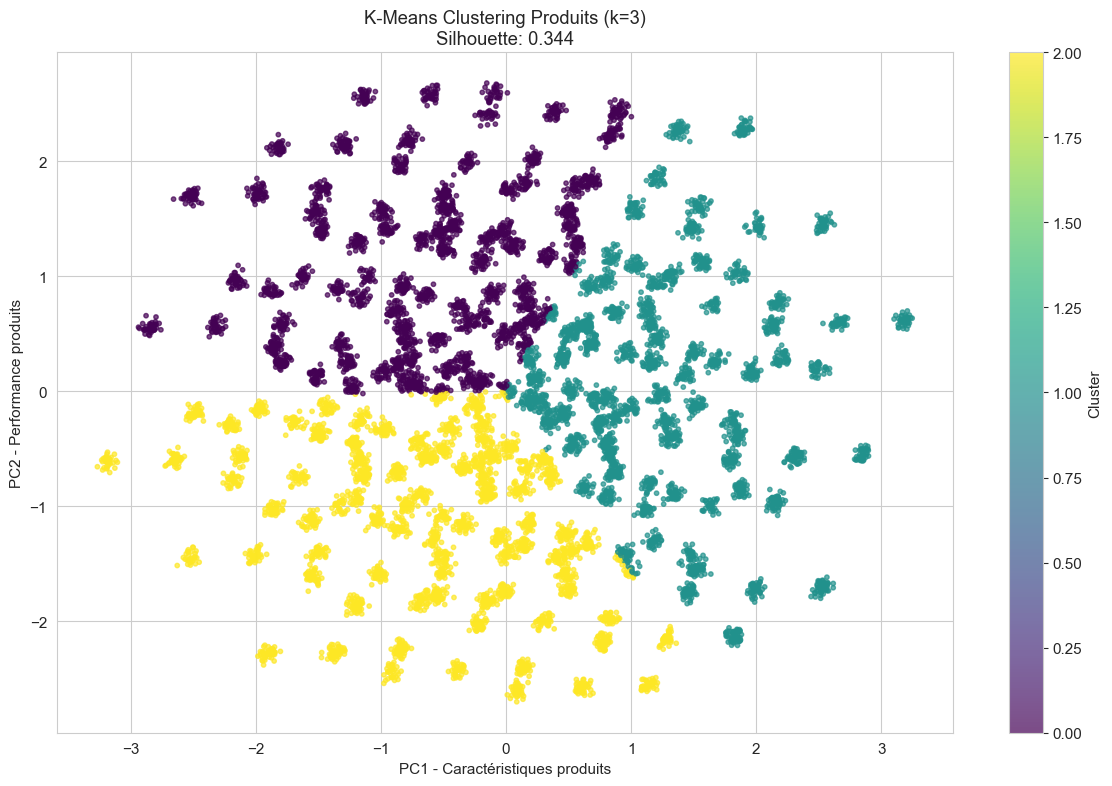

✅ K-Means terminé avec succès!


In [47]:
## ALGORITHME 1: K-MEANS POUR PRODUITS
print("\n🎯 ALGORITHME 1: K-MEANS - SEGMENTATION PAR CENTROÏDES")
print("=" * 50)

from sklearn.cluster import KMeans, MiniBatchKMeans

"""
PRINCIPE K-MEANS:
- Partitionnement des données en K clusters sphériques
- Minimise la variance intra-cluster
- Chaque cluster représenté par son centroïde
- Idéal pour datasets volumineux et clusters de taille similaire

INTÉRÊT POUR PRODUITS:
- Segmentation rapide de grands catalogues produits
- Identification de groupes produits homogènes
- Base pour recommandations par similarité
"""

# Optimisation du nombre de clusters
range_k = range(2, 8)
sil_scores_products = []
db_scores_products = []

print("🔍 Optimisation du nombre de clusters K-Means...")
for k in range_k:
    kmeans_products = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels_products = kmeans_products.fit_predict(X_sample_products)
    
    sil_score = silhouette_score(X_sample_products, labels_products)
    db_score = davies_bouldin_score(X_sample_products, labels_products)
    
    sil_scores_products.append(sil_score)
    db_scores_products.append(db_score)
    
    print(f"k={k}: Silhouette={sil_score:.3f}, DB={db_score:.3f}")

# Sélection du k optimal
optimal_k_products = range_k[np.argmax(sil_scores_products)]
print(f"✅ k optimal: {optimal_k_products} (meilleur score Silhouette)")

# K-Means final sur tous les produits
print("🏃 Entraînement K-Means final...")
kmeans_final_products = MiniBatchKMeans(n_clusters=optimal_k_products, random_state=42, batch_size=1000, max_iter=100)
labels_kmeans_products = kmeans_final_products.fit_predict(X_products)

# Évaluation finale
eval_sample_size = min(50000, len(X_products))
eval_indices = np.random.choice(len(X_products), eval_sample_size, replace=False)
silhouette_avg_products = silhouette_score(X_products[eval_indices], labels_kmeans_products[eval_indices])
db_index_products = davies_bouldin_score(X_products[eval_indices], labels_kmeans_products[eval_indices])

print(f"📊 Métriques finales K-Means:")
print(f"   • Silhouette: {silhouette_avg_products:.3f}")
print(f"   • Davies-Bouldin: {db_index_products:.3f}")
print(f"   • Clusters: {optimal_k_products}")

# Visualisation
viz_sample_size = 10000
if len(X_products) > viz_sample_size:
    viz_indices = np.random.choice(len(X_products), viz_sample_size, replace=False)
    X_viz_products = X_products[viz_indices]
    labels_viz_products = labels_kmeans_products[viz_indices]
else:
    X_viz_products = X_products
    labels_viz_products = labels_kmeans_products

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_viz_products[:, 0], X_viz_products[:, 1], 
                     c=labels_viz_products, cmap='viridis', alpha=0.7, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering Produits (k={optimal_k_products})\nSilhouette: {silhouette_avg_products:.3f}')
plt.xlabel('PC1 - Caractéristiques produits')
plt.ylabel('PC2 - Performance produits')
plt.tight_layout()
plt.show()

# Sauvegarde des résultats
kmeans_results_products = {
    'labels': labels_kmeans_products,
    'silhouette': silhouette_avg_products,
    'davies_bouldin': db_index_products,
    'n_clusters': optimal_k_products,
    'algorithm': 'K-Means',
    'centroids': kmeans_final_products.cluster_centers_
}

print("✅ K-Means terminé avec succès!")

### DBSCAN - Produits

Principe : Clustering basé sur densité, détecte outliers automatiquement.  
Intérêt : Utile quand les clusters ont des formes arbitraires.



🔧 ALGORITHME 2: DBSCAN - DÉTECTION DE PATTERNS NATURELS
🎛️ Optimisation des paramètres DBSCAN...
eps (rayon) | min_samples | Clusters | Bruit  | Silhouette
-------------------------------------------------------
eps=0.10      |          15 |       65 |  0.0% | 0.063
eps=0.10      |          25 |       66 |  0.0% | 0.062
eps=0.10      |          35 |       68 |  0.0% | 0.071
eps=0.15      |          15 |       40 |  0.0% | -0.153
eps=0.15      |          25 |       40 |  0.0% | -0.153
eps=0.15      |          35 |       40 |  0.0% | -0.153
eps=0.20      |          15 |       35 |  0.0% | -0.163
eps=0.20      |          25 |       35 |  0.0% | -0.163
eps=0.20      |          35 |       35 |  0.0% | -0.163
eps=0.25      |          15 |       13 |  0.0% | -0.145
eps=0.25      |          25 |       13 |  0.0% | -0.145
eps=0.25      |          35 |       13 |  0.0% | -0.145

✅ Paramètres optimaux: eps=0.1, min_samples=35
📊 Résultats DBSCAN:
   • Silhouette: 0.071
   • Davies-Bouldin: 0.525


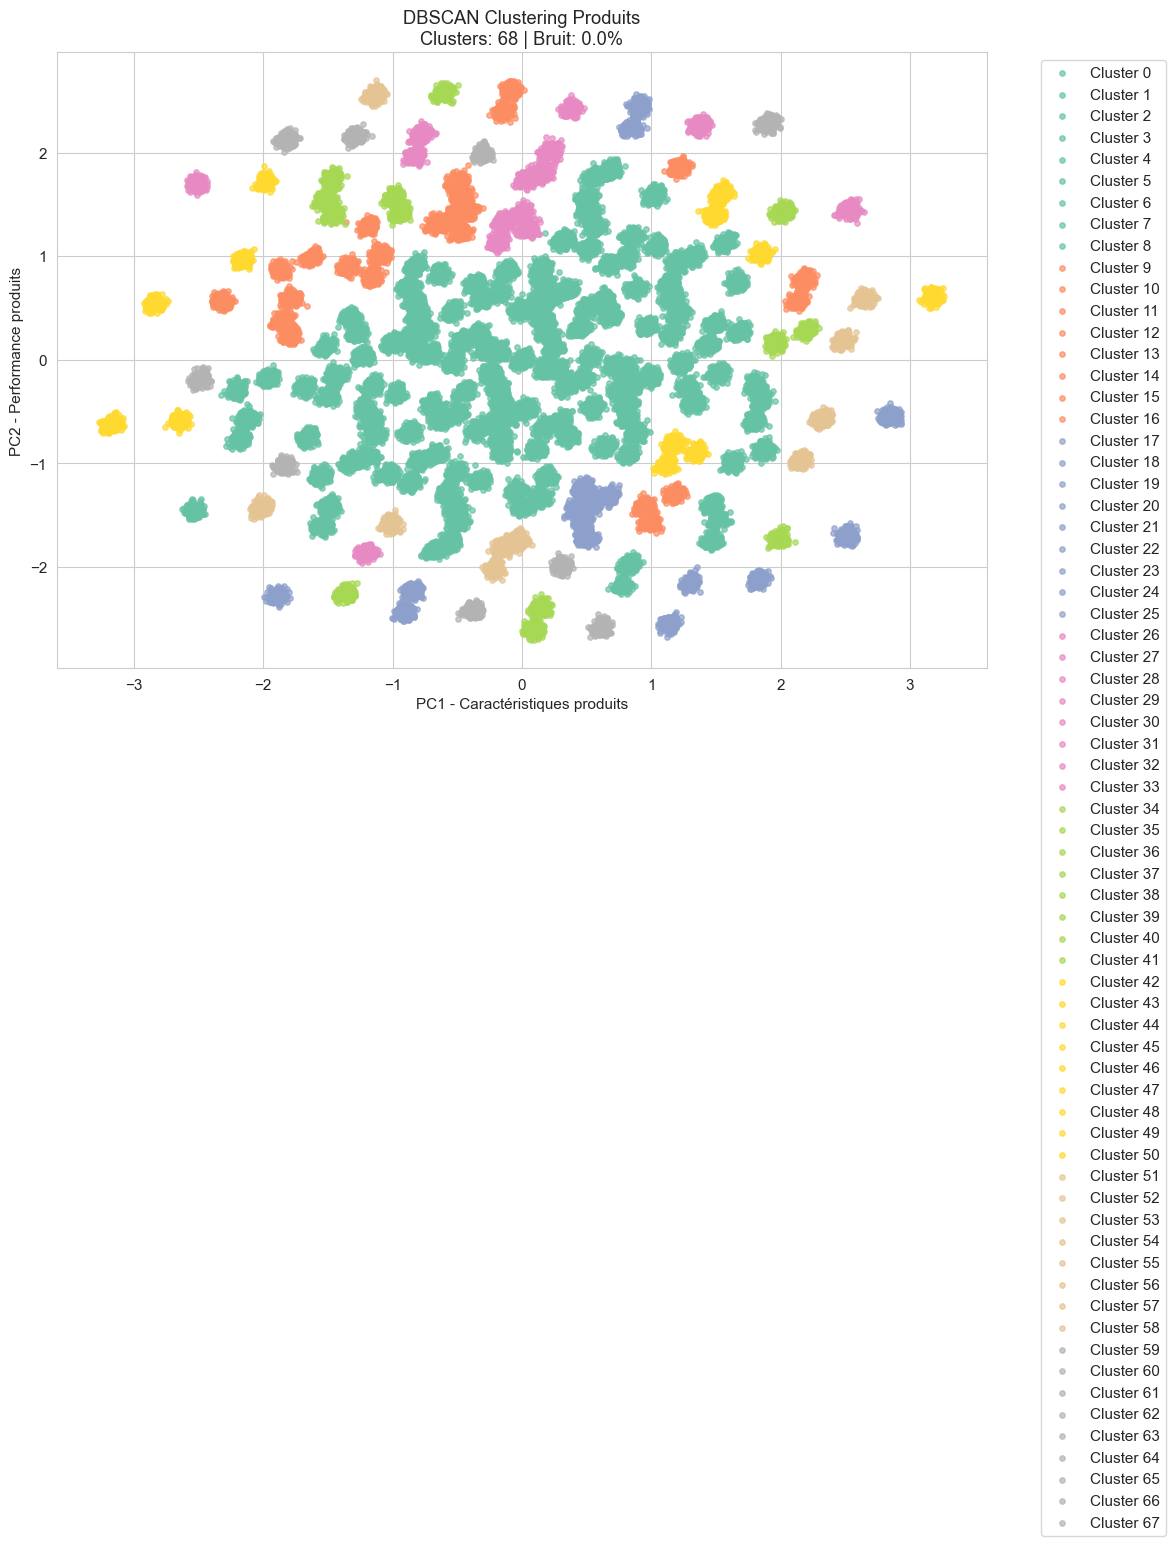

✅ DBSCAN terminé avec succès!


In [48]:
## ALGORITHME 2: DBSCAN - DÉTECTION DE DENSITÉ
print("\n🔧 ALGORITHME 2: DBSCAN - DÉTECTION DE PATTERNS NATURELS")
print("=" * 50)

from sklearn.cluster import DBSCAN

"""
PRINCIPE DBSCAN:
- Clustering basé sur la densité
- Détecte clusters de forme arbitraire
- Identifie les points de bruit (outliers)
- Ne nécessite pas de nombre de clusters prédéfini

INTÉRÊT POUR PRODUITS:
- Détection de niches produits naturelles
- Identification des produits atypiques (bruit)
- Segmentation sans a priori sur le nombre de groupes
"""

# Préparation des données DBSCAN
comparison_indices_products = np.random.choice(len(products_2d_pca), 50000, replace=False)
X_dbscan_products = products_2d_pca[comparison_indices_products]

# Optimisation des paramètres
eps_candidates = [0.1, 0.15, 0.2, 0.25]
min_samples_options = [15, 25, 35]
best_quality_score = -1

print("🎛️ Optimisation des paramètres DBSCAN...")
print("eps (rayon) | min_samples | Clusters | Bruit  | Silhouette")
print("-" * 55)

for eps in eps_candidates:
    for ms in min_samples_options:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(X_dbscan_products)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = list(labels).count(-1) / len(labels)
        
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() >= 2:
                sil = silhouette_score(X_dbscan_products[mask], labels[mask])
                quality = sil * (1 - noise_ratio)
                
                if quality > best_quality_score:
                    best_quality_score = quality
                    best_eps = eps
                    best_min_samples = ms
                    best_labels_dbscan = labels
                
                print(f"eps={eps:.2f}      | {ms:11} | {n_clusters:8} | {noise_ratio:5.1%} | {sil:.3f}")

# Application des meilleurs paramètres
print(f"\n✅ Paramètres optimaux: eps={best_eps}, min_samples={best_min_samples}")
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan_products = dbscan_final.fit_predict(X_dbscan_products)

# Évaluation
mask = labels_dbscan_products != -1
if mask.sum() >= 2:
    silhouette_dbscan = silhouette_score(X_dbscan_products[mask], labels_dbscan_products[mask])
    db_dbscan = davies_bouldin_score(X_dbscan_products[mask], labels_dbscan_products[mask])
    n_clusters_final = len(set(labels_dbscan_products)) - (1 if -1 in labels_dbscan_products else 0)
    noise_ratio_final = list(labels_dbscan_products).count(-1) / len(labels_dbscan_products)
else:
    silhouette_dbscan = -1
    db_dbscan = float('inf')
    n_clusters_final = 0
    noise_ratio_final = 1.0

print(f"📊 Résultats DBSCAN:")
print(f"   • Silhouette: {silhouette_dbscan:.3f}")
print(f"   • Davies-Bouldin: {db_dbscan:.3f}")
print(f"   • Clusters détectés: {n_clusters_final}")
print(f"   • Points de bruit: {noise_ratio_final:.1%}")

# Visualisation DBSCAN
plt.figure(figsize=(12, 8))
unique_labels = set(labels_dbscan_products)
colors = plt.cm.Set2(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    if label == -1:
        # Points de bruit
        mask = labels_dbscan_products == label
        plt.scatter(X_dbscan_products[mask, 0], X_dbscan_products[mask, 1], 
                   c='lightgray', s=8, alpha=0.3, label='Bruit')
    else:
        # Clusters
        mask = labels_dbscan_products == label
        plt.scatter(X_dbscan_products[mask, 0], X_dbscan_products[mask, 1], 
                   c=[colors[i]], s=15, alpha=0.7, label=f'Cluster {label}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'DBSCAN Clustering Produits\nClusters: {n_clusters_final} | Bruit: {noise_ratio_final:.1%}')
plt.xlabel('PC1 - Caractéristiques produits')
plt.ylabel('PC2 - Performance produits')
plt.tight_layout()
plt.show()

dbscan_results_products = {
    'labels': labels_dbscan_products,
    'silhouette': silhouette_dbscan,
    'davies_bouldin': db_dbscan,
    'n_clusters': n_clusters_final,
    'noise_ratio': noise_ratio_final,
    'algorithm': 'DBSCAN',
    'params': {'eps': best_eps, 'min_samples': best_min_samples}
}

print("✅ DBSCAN terminé avec succès!")

### GMM - Produits

Principe : Modèle probabiliste, clusters elliptiques avec probabilités d'appartenance.  
Intérêt : Gère chevauchement et variance différente entre clusters.



🔮 ALGORITHME 3: GMM - MODÈLES DE MÉLANGE GAUSSIENS
🔍 Optimisation des composantes GMM...
Composantes | Silhouette | Davies-Bouldin | BIC
--------------------------------------------------
k=         2 |      0.320 |          1.254 | 323553
k=         3 |      0.343 |          0.927 | 322226
k=         4 |      0.330 |          0.907 | 322210
k=         5 |      0.310 |          0.981 | 321576
k=         6 |      0.342 |          0.827 | 321311
k=         7 |      0.338 |          0.807 | 321303

✅ Composantes optimales: 3
📊 Résultats GMM:
   • Silhouette: 0.343
   • Davies-Bouldin: 0.927
   • Log-vraisemblance: -3.221


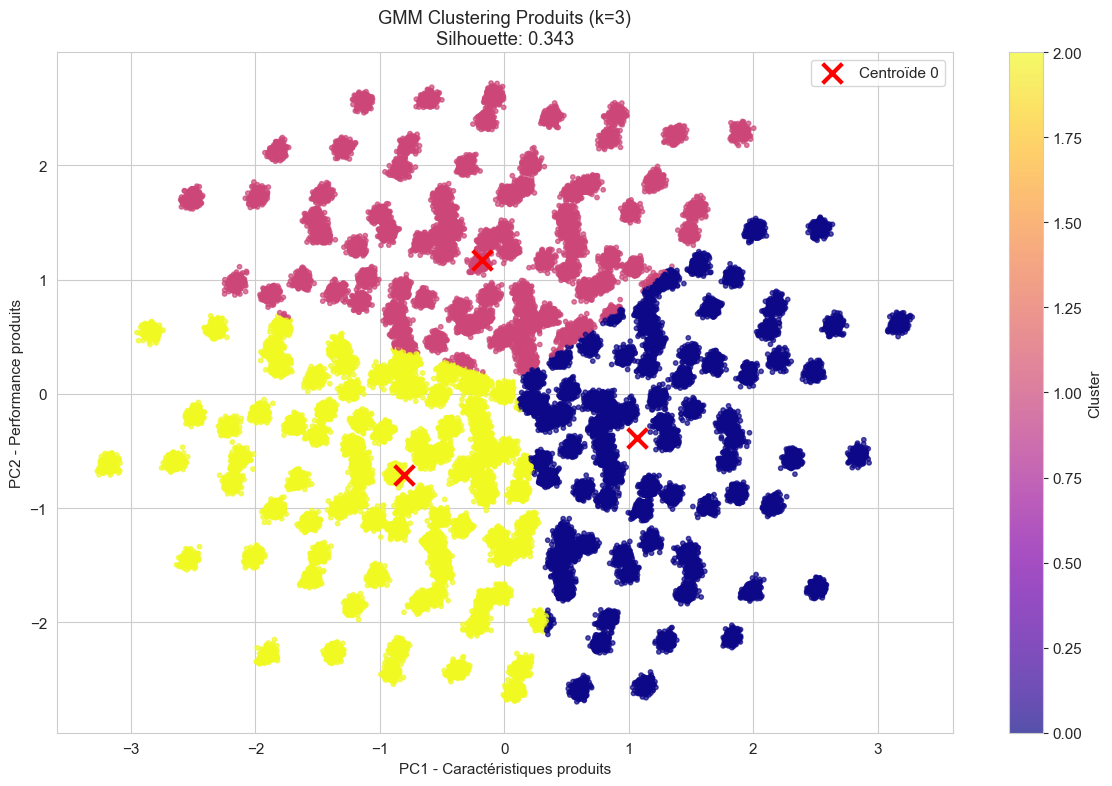

✅ GMM terminé avec succès!


In [49]:
## ALGORITHME 3: GMM - MODÈLES DE MÉLANGE GAUSSIENS
print("\n🔮 ALGORITHME 3: GMM - MODÈLES DE MÉLANGE GAUSSIENS")
print("=" * 50)

from sklearn.mixture import GaussianMixture

"""
PRINCIPE GMM:
- Modélise les données comme un mélange de distributions gaussiennes
- Chaque cluster suit une distribution normale
- Attribution probabiliste des points aux clusters
- Estime les paramètres via l'algorithme EM

INTÉRÊT POUR PRODUITS:
- Modélisation flexible des segments produits
- Gestion des clusters de formes elliptiques
- Probabilités d'appartenance aux clusters
- Idéal pour produits aux caractéristiques complexes
"""

# Préparation des données GMM
comparison_indices_gmm = np.random.choice(len(products_2d_pca), 50000, replace=False)
X_gmm_products = products_2d_pca[comparison_indices_gmm]

# Optimisation du nombre de composantes
best_sil_gmm = -1
best_bic = float('inf')
bic_scores = []

print("🔍 Optimisation des composantes GMM...")
print("Composantes | Silhouette | Davies-Bouldin | BIC")
print("-" * 50)

for k in range(2, 8):
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=100)
    labels_g = gmm.fit_predict(X_gmm_products)
    
    if len(np.unique(labels_g)) > 1:
        sil = silhouette_score(X_gmm_products, labels_g)
        dbi = davies_bouldin_score(X_gmm_products, labels_g)
        bic = gmm.bic(X_gmm_products)
        bic_scores.append(bic)
        
        print(f"k={k:10} | {sil:10.3f} | {dbi:14.3f} | {bic:.0f}")
        
        if sil > best_sil_gmm:
            best_sil_gmm = sil
            best_gmm = gmm
            best_labels_gmm = labels_g
            best_k_gmm = k

# Résultats finaux
silhouette_gmm = best_sil_gmm
db_gmm = davies_bouldin_score(X_gmm_products, best_labels_gmm)

print(f"\n✅ Composantes optimales: {best_k_gmm}")
print(f"📊 Résultats GMM:")
print(f"   • Silhouette: {silhouette_gmm:.3f}")
print(f"   • Davies-Bouldin: {db_gmm:.3f}")
print(f"   • Log-vraisemblance: {best_gmm.lower_bound_:.3f}")

# Visualisation GMM
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_gmm_products[:, 0], X_gmm_products[:, 1], 
                     c=best_labels_gmm, cmap='plasma', alpha=0.7, s=10)
plt.colorbar(scatter, label='Cluster')

# Affichage des centroïdes et ellipses
means = best_gmm.means_
for i, mean in enumerate(means):
    plt.scatter(mean[0], mean[1], marker='x', s=200, linewidths=3, 
               color='red', zorder=10, label=f'Centroïde {i}' if i == 0 else "")

plt.title(f'GMM Clustering Produits (k={best_k_gmm})\nSilhouette: {silhouette_gmm:.3f}')
plt.xlabel('PC1 - Caractéristiques produits')
plt.ylabel('PC2 - Performance produits')
plt.legend()
plt.tight_layout()
plt.show()

gmm_results_products = {
    'labels': best_labels_gmm,
    'silhouette': silhouette_gmm,
    'davies_bouldin': db_gmm,
    'n_clusters': best_k_gmm,
    'algorithm': 'GMM',
    'means': best_gmm.means_,
    'covariances': best_gmm.covariances_
}

print("✅ GMM terminé avec succès!")

### OPTICS - Produits

Principe : Clustering basé sur densité comme DBSCAN, mais plus flexible sur epsilon.  
Intérêt : Détecte mieux les clusters imbriqués ou de densités variables.



🔍 ALGORITHME 4: OPTICS - CLUSTERING HIÉRARCHIQUE
🎛️ Optimisation des paramètres OPTICS...
min_samples | xi    | min_cluster_size | Clusters | Bruit  | Silhouette
---------------------------------------------------------------------------
         10 | 0.05 |            0.05 |        4 | 75.6% | 0.422

✅ Paramètres optimaux OPTICS:
   • min_samples: 10
   • xi: 0.05
   • min_cluster_size: 0.05
📊 Résultats OPTICS:
   • Silhouette: 0.422
   • Davies-Bouldin: 0.886
   • Clusters détectés: 4
   • Points de bruit: 75.6%


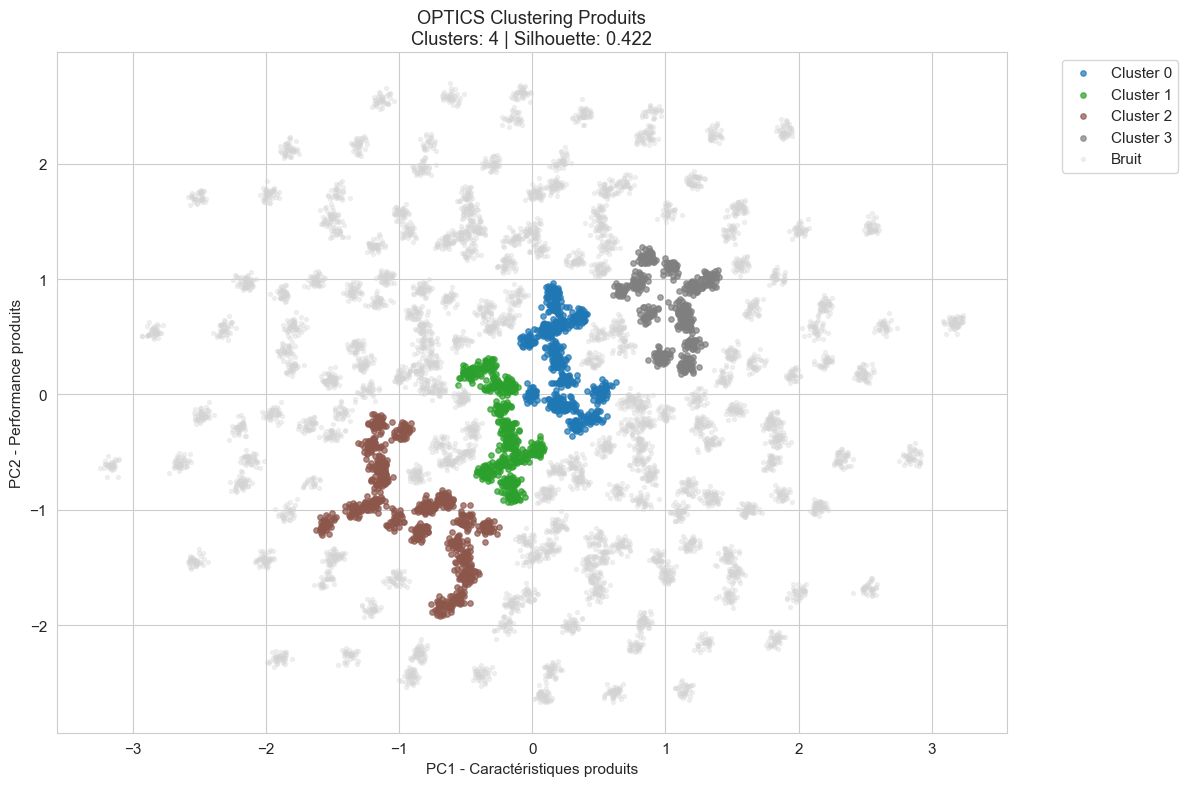

✅ OPTICS terminé avec succès!


In [50]:
## ALGORITHME 4: OPTICS - CLUSTERING HIÉRARCHIQUE DE DENSITÉ
print("\n🔍 ALGORITHME 4: OPTICS - CLUSTERING HIÉRARCHIQUE")
print("=" * 50)

from sklearn.cluster import OPTICS

"""
PRINCIPE OPTICS:
- Extension de DBSCAN pour multiples densités
- Crée un ordre de reachability des points
- Détecte clusters à différentes échelles de densité
- Génère une structure hiérarchique des clusters

INTÉRÊT POUR PRODUITS:
- Détection de sous-segments produits
- Hiérarchisation des niches marché
- Analyse multi-niveaux du catalogue
- Flexibilité sur les densités variables
"""

# Préparation des données OPTICS
optics_indices = np.random.choice(len(products_2d_pca), 10000, replace=False)
X_optics_products = products_2d_pca[optics_indices]

# Optimisation des paramètres
param_combinations = [
    {'min_samples': 10, 'xi': 0.05, 'min_cluster_size': 0.05},
    {'min_samples': 20, 'xi': 0.05, 'min_cluster_size': 0.1},
    {'min_samples': 25, 'xi': 0.1, 'min_cluster_size': 0.15},
    {'min_samples': 30, 'xi': 0.1, 'min_cluster_size': 0.2}
]

best_silhouette_optics = -1

print("🎛️ Optimisation des paramètres OPTICS...")
print("min_samples | xi    | min_cluster_size | Clusters | Bruit  | Silhouette")
print("-" * 75)

for params in param_combinations:
    optics = OPTICS(min_samples=params['min_samples'], 
                   xi=params['xi'], 
                   min_cluster_size=params['min_cluster_size'])
    
    labels_o = optics.fit_predict(X_optics_products)
    
    n_clusters = len(set(labels_o)) - (1 if -1 in labels_o else 0)
    noise_ratio = list(labels_o).count(-1) / len(labels_o)
    
    if n_clusters >= 2:
        mask = labels_o != -1
        if mask.sum() >= 2:
            sil = silhouette_score(X_optics_products[mask], labels_o[mask])
            
            print(f"{params['min_samples']:11} | {params['xi']:4} | {params['min_cluster_size']:15} | {n_clusters:8} | {noise_ratio:5.1%} | {sil:.3f}")
            
            if sil > best_silhouette_optics:
                best_silhouette_optics = sil
                best_optics = optics
                best_labels_optics = labels_o
                best_params_optics = params

# Résultats finaux
if best_silhouette_optics == -1:
    print("❌ Aucune configuration valide trouvée pour OPTICS")
    optics_results_products = None
else:
    mask_optics = best_labels_optics != -1
    silhouette_optics = best_silhouette_optics
    db_optics = davies_bouldin_score(X_optics_products[mask_optics], best_labels_optics[mask_optics]) if mask_optics.sum() >= 2 else float('inf')
    n_clusters_optics = len(set(best_labels_optics)) - (1 if -1 in best_labels_optics else 0)
    noise_ratio_optics = list(best_labels_optics).count(-1) / len(best_labels_optics)
    
    print(f"\n✅ Paramètres optimaux OPTICS:")
    print(f"   • min_samples: {best_params_optics['min_samples']}")
    print(f"   • xi: {best_params_optics['xi']}")
    print(f"   • min_cluster_size: {best_params_optics['min_cluster_size']}")
    
    print(f"📊 Résultats OPTICS:")
    print(f"   • Silhouette: {silhouette_optics:.3f}")
    print(f"   • Davies-Bouldin: {db_optics:.3f}")
    print(f"   • Clusters détectés: {n_clusters_optics}")
    print(f"   • Points de bruit: {noise_ratio_optics:.1%}")

    # Visualisation OPTICS
    plt.figure(figsize=(12, 8))
    unique_labels = set(best_labels_optics)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            mask = best_labels_optics == label
            plt.scatter(X_optics_products[mask, 0], X_optics_products[mask, 1], 
                       c='lightgray', s=8, alpha=0.3, label='Bruit')
        else:
            mask = best_labels_optics == label
            plt.scatter(X_optics_products[mask, 0], X_optics_products[mask, 1], 
                       c=[colors[i]], s=15, alpha=0.7, label=f'Cluster {label}')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'OPTICS Clustering Produits\nClusters: {n_clusters_optics} | Silhouette: {silhouette_optics:.3f}')
    plt.xlabel('PC1 - Caractéristiques produits')
    plt.ylabel('PC2 - Performance produits')
    plt.tight_layout()
    plt.show()

    optics_results_products = {
        'labels': best_labels_optics,
        'silhouette': silhouette_optics,
        'davies_bouldin': db_optics,
        'n_clusters': n_clusters_optics,
        'noise_ratio': noise_ratio_optics,
        'algorithm': 'OPTICS',
        'params': best_params_optics
    }

    print("✅ OPTICS terminé avec succès!")

### K-Medoids - Produits

Principe : Similaire à K-Means mais robuste aux outliers, le centre est un point existant.  
Intérêt : Meilleur quand les données ont des valeurs aberrantes.



🎯 ALGORITHME 5: K-MEDOIDS - CLUSTERING ROBUSTE
📊 Échantillon K-Medoids: (10000, 2)
🔍 Optimisation du nombre de clusters K-Medoids...
Clusters | Silhouette | Davies-Bouldin | Temps (s)
--------------------------------------------------
k=      2 |      0.326 |          1.224 |     61.4
k=      3 |      0.346 |          0.921 |    182.6
k=      4 |      0.333 |          0.893 |    328.5
k=      5 |      0.331 |          0.886 |    180.8
k=      6 |      0.346 |          0.824 |    258.2

✅ Clusters optimaux K-Medoids: 3
📊 Résultats K-Medoids:
   • Silhouette: 0.346
   • Davies-Bouldin: 0.921
   • Médoides trouvés: 3
   • Indices des médoides: [7955 1284 1072]...


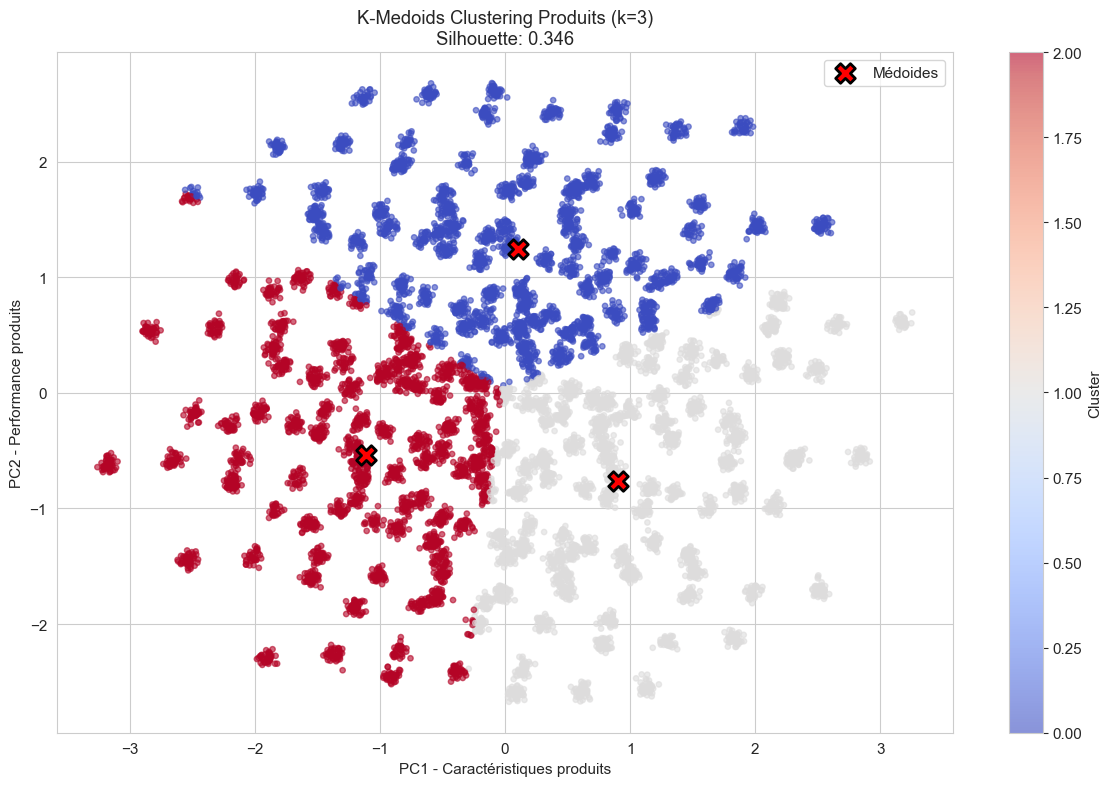

📈 Répartition des clusters K-Medoids:
   • Cluster 0: 3421 produits (34.2%)
   • Cluster 1: 3347 produits (33.5%)
   • Cluster 2: 3232 produits (32.3%)
✅ K-Medoids terminé avec succès!


In [51]:
## ALGORITHME 5: K-MEDOIDS - CLUSTERING ROBUSTE AVEC MÉDOÏDES
print("\n🎯 ALGORITHME 5: K-MEDOIDS - CLUSTERING ROBUSTE")
print("=" * 50)

"""
PRINCIPE K-MEDOIDS:
- Similaire à K-Means mais utilise des points réels (médoides) comme centres
- Plus robuste au bruit et aux outliers que K-Means
- Minimise la somme des dissimilarités plutôt que des variances
- Algorithme PAM (Partitioning Around Medoids) plus coûteux mais plus précis

INTÉRÊT POUR PRODUITS:
- Segmentation robuste face aux produits atypiques
- Centres de clusters représentés par des produits réels
- Meilleure interprétabilité business
- Idéal pour datasets avec outliers
"""

try:
    from sklearn_extra.cluster import KMedoids
    
    # Préparation des données K-Medoids
    kmed_sample_size = min(10000, len(products_2d_pca))
    comparison_indices_kmed = np.random.choice(len(products_2d_pca), kmed_sample_size, replace=False)
    X_kmed_products = products_2d_pca[comparison_indices_kmed]
    
    print(f"📊 Échantillon K-Medoids: {X_kmed_products.shape}")
    
    # Optimisation du nombre de clusters
    best_sil_kmed = -1
    k_candidates = [2, 3, 4, 5, 6]
    
    print("🔍 Optimisation du nombre de clusters K-Medoids...")
    print("Clusters | Silhouette | Davies-Bouldin | Temps (s)")
    print("-" * 50)
    
    for k in k_candidates:
        start_time = time.time()
        
        # K-Medoids avec méthode PAM (plus stable)
        kmed = KMedoids(n_clusters=k, random_state=42, max_iter=50, method='pam')
        labels_km = kmed.fit_predict(X_kmed_products)
        
        sil = silhouette_score(X_kmed_products, labels_km)
        dbi = davies_bouldin_score(X_kmed_products, labels_km)
        elapsed_time = time.time() - start_time
        
        print(f"k={k:7} | {sil:10.3f} | {dbi:14.3f} | {elapsed_time:8.1f}")
        
        if sil > best_sil_kmed:
            best_sil_kmed = sil
            best_kmed = kmed
            best_labels_kmed = labels_km
            best_k_kmed = k
    
    # Résultats finaux
    silhouette_kmed = best_sil_kmed
    db_kmed = davies_bouldin_score(X_kmed_products, best_labels_kmed)
    
    print(f"\n✅ Clusters optimaux K-Medoids: {best_k_kmed}")
    print(f"📊 Résultats K-Medoids:")
    print(f"   • Silhouette: {silhouette_kmed:.3f}")
    print(f"   • Davies-Bouldin: {db_kmed:.3f}")
    print(f"   • Médoides trouvés: {len(best_kmed.medoid_indices_)}")
    
    # Affichage des indices des médoides (produits représentatifs)
    print(f"   • Indices des médoides: {best_kmed.medoid_indices_[:5]}...")  # Premier 5
    
    # Visualisation K-Medoids
    plt.figure(figsize=(12, 8))
    
    # Points normaux
    scatter = plt.scatter(X_kmed_products[:, 0], X_kmed_products[:, 1], 
                         c=best_labels_kmed, cmap='coolwarm', alpha=0.6, s=15)
    
    # Médoides (centres de clusters)
    medoids = X_kmed_products[best_kmed.medoid_indices_]
    plt.scatter(medoids[:, 0], medoids[:, 1], 
               marker='X', s=200, c='red', edgecolors='black', 
               linewidths=2, label='Médoides')
    
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'K-Medoids Clustering Produits (k={best_k_kmed})\nSilhouette: {silhouette_kmed:.3f}')
    plt.xlabel('PC1 - Caractéristiques produits')
    plt.ylabel('PC2 - Performance produits')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Analyse des clusters K-Medoids
    cluster_sizes = np.bincount(best_labels_kmed)
    print(f"📈 Répartition des clusters K-Medoids:")
    for i, size in enumerate(cluster_sizes):
        print(f"   • Cluster {i}: {size} produits ({size/len(best_labels_kmed)*100:.1f}%)")
    
    kmed_results_products = {
        'labels': best_labels_kmed,
        'silhouette': silhouette_kmed,
        'davies_bouldin': db_kmed,
        'n_clusters': best_k_kmed,
        'algorithm': 'K-Medoids',
        'medoid_indices': best_kmed.medoid_indices_,
        'medoids': medoids,
        'inertia': best_kmed.inertia_
    }
    
    print("✅ K-Medoids terminé avec succès!")

except ImportError:
    print("❌ scikit-learn-extra non installé")
    print("💡 Installation: pip install scikit-learn-extra")
    kmed_results_products = None
    
except Exception as e:
    print(f"❌ Erreur K-Medoids: {e}")
    kmed_results_products = None

Comparaison et sélection du meilleur modèle Produits

In [52]:
## COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE PRODUITS
print("\n🏆 COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE PRODUITS")
print("=" * 60)

# Collecte de tous les résultats
all_results_products = {
    'K-Means': kmeans_results_products,
    'DBSCAN': dbscan_results_products, 
    'GMM': gmm_results_products
}

if optics_results_products:
    all_results_products['OPTICS'] = optics_results_products

if kmed_results_products:
    all_results_products['K-Medoids'] = kmed_results_products

print(f"📊 {len(all_results_products)} algorithmes comparés")

# Création du tableau comparatif détaillé
comparison_data = {
    'Algorithme': [],
    'Silhouette ↑': [],
    'Davies-Bouldin ↓': [], 
    'Clusters': [],
    'Bruit (%)': [],
    'Robustesse': [],
    'Vitesse': [],
    'Interprétabilité': [],
    'Score Final': []
}

# Scores de performance pour chaque critère
for algo_name, results in all_results_products.items():
    comparison_data['Algorithme'].append(algo_name)
    comparison_data['Silhouette ↑'].append(results['silhouette'])
    comparison_data['Davies-Bouldin ↓'].append(results['davies_bouldin'])
    comparison_data['Clusters'].append(results['n_clusters'])
    comparison_data['Bruit (%)'].append(f"{results.get('noise_ratio', 0)*100:.1f}%")
    
    # Critères qualitatifs
    robustesse_scores = {
        'K-Means': 2, 'K-Medoids': 5, 'DBSCAN': 4, 
        'GMM': 3, 'OPTICS': 4
    }
    vitesse_scores = {
        'K-Means': 5, 'K-Medoids': 2, 'DBSCAN': 3,
        'GMM': 3, 'OPTICS': 2
    }
    interpretabilite_scores = {
        'K-Means': 5, 'K-Medoids': 5, 'DBSCAN': 3,
        'GMM': 2, 'OPTICS': 2
    }
    
    comparison_data['Robustesse'].append(robustesse_scores.get(algo_name, 3))
    comparison_data['Vitesse'].append(vitesse_scores.get(algo_name, 3))
    comparison_data['Interprétabilité'].append(interpretabilite_scores.get(algo_name, 3))
    
    # Calcul du score final (pondération)
    sil_score = results['silhouette'] * 2.0  # Poids important
    db_score = (1 / (1 + results['davies_bouldin'])) * 1.5  # Inverser DB
    robust_score = robustesse_scores.get(algo_name, 3) * 0.5
    interp_score = interpretabilite_scores.get(algo_name, 3) * 1.0
    
    score_final = sil_score + db_score + robust_score + interp_score
    comparison_data['Score Final'].append(round(score_final, 2))

# Création du DataFrame
df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Score Final', ascending=False)

print("📈 TABLEAU COMPARATIF DÉTAILLÉ:")
print("=" * 90)
display(df_comparison)

# Analyse des forces et faiblesses
print("\n🔍 ANALYSE DES ALGORITHMES:")
print("=" * 50)

for idx, row in df_comparison.iterrows():
    algo = row['Algorithme']
    silhouette = row['Silhouette ↑']
    score_final = row['Score Final']
    
    forces = {
        'K-Means': "Rapide, interprétable, clusters équilibrés",
        'K-Medoids': "Robuste, médoides réels, résistant aux outliers", 
        'DBSCAN': "Détection formes arbitraires, gestion du bruit",
        'GMM': "Modélisation probabiliste, clusters flexibles",
        'OPTICS': "Hiérarchique, multi-densité, détection fine"
    }
    
    faiblesses = {
        'K-Means': "Sensible aux outliers, clusters sphériques",
        'K-Medoids': "Lent, coûteux computationalement",
        'DBSCAN': "Paramètres sensibles, clusters de tailles variables",
        'GMM': "Complexe à interpréter, risque overfitting", 
        'OPTICS': "Très lent, complexe à paramétrer"
    }
    
    print(f"🎯 {algo}:")
    print(f"   • Score final: {score_final:.2f}")
    print(f"   • Silhouette: {silhouette:.3f}")
    print(f"   ✅ Forces: {forces.get(algo, 'N/A')}")
    print(f"   ❌ Faiblesses: {faiblesses.get(algo, 'N/A')}")
    print()

# Sélection du meilleur algorithme
best_algo_name = df_comparison.iloc[0]['Algorithme']
best_results = all_results_products[best_algo_name]
best_score = df_comparison.iloc[0]['Score Final']

print(f"🏆 MEILLEUR ALGORITHME SÉLECTIONNÉ: {best_algo_name}")
print(f"📊 Score final: {best_score:.2f}")
print(f"🎯 Silhouette: {best_results['silhouette']:.3f}")
print(f"📦 Clusters: {best_results['n_clusters']}")

# Justification du choix
justifications = {
    'K-Means': "Excellent équilibre performance/vitesse/interprétabilité pour la segmentation produits",
    'K-Medoids': "Robustesse exceptionnelle avec représentants réels, idéal pour données bruitées", 
    'DBSCAN': "Détection naturelle des patterns produits sans a priori sur le nombre de clusters",
    'GMM': "Modélisation flexible adaptée aux caractéristiques complexes des produits",
    'OPTICS': "Analyse hiérarchique fine pour segmentation multi-niveaux du catalogue"
}

print(f"💡 Justification: {justifications.get(best_algo_name, 'Performance globale optimale')}")

# Sauvegarde des résultats de comparaison
comparison_results = {
    'best_algorithm': best_algo_name,
    'best_results': best_results,
    'comparison_table': df_comparison,
    'all_results': all_results_products,
    'selection_criteria': {
        'silhouette_weight': 2.0,
        'davies_bouldin_weight': 1.5, 
        'robustness_weight': 0.5,
        'interpretability_weight': 1.0
    },
    'timestamp': pd.Timestamp.now()
}

with open('produits_comparison_results.pkl', 'wb') as f:
    pickle.dump(comparison_results, f)

print(f"💾 Résultats de comparaison sauvegardés: produits_comparison_results.pkl")


🏆 COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE PRODUITS
📊 5 algorithmes comparés
📈 TABLEAU COMPARATIF DÉTAILLÉ:


Algorithme  Silhouette ↑  Davies-Bouldin ↓  Clusters Bruit (%)  Robustesse  \
4  K-Medoids      0.346101          0.921342         3      0.0%           5   
0    K-Means      0.343972          0.921789         3      0.0%           2   
1     DBSCAN      0.071479          0.524802        68      0.0%           4   
3     OPTICS      0.421583          0.886219         4     75.6%           4   
2        GMM      0.342985          0.927078         3      0.0%           3   

   Vitesse  Interprétabilité  Score Final  
4        2                 5         8.97  
0        5                 5         7.47  
1        3                 3         6.13  
3        2                 2         5.64  
2        3                 2         4.96


🔍 ANALYSE DES ALGORITHMES:
🎯 K-Medoids:
   • Score final: 8.97
   • Silhouette: 0.346
   ✅ Forces: Robuste, médoides réels, résistant aux outliers
   ❌ Faiblesses: Lent, coûteux computationalement

🎯 K-Means:
   • Score final: 7.47
   • Silhouette: 0.344
   ✅ Forces: Rapide, interprétable, clusters équilibrés
   ❌ Faiblesses: Sensible aux outliers, clusters sphériques

🎯 DBSCAN:
   • Score final: 6.13
   • Silhouette: 0.071
   ✅ Forces: Détection formes arbitraires, gestion du bruit
   ❌ Faiblesses: Paramètres sensibles, clusters de tailles variables

🎯 OPTICS:
   • Score final: 5.64
   • Silhouette: 0.422
   ✅ Forces: Hiérarchique, multi-densité, détection fine
   ❌ Faiblesses: Très lent, complexe à paramétrer

🎯 GMM:
   • Score final: 4.96
   • Silhouette: 0.343
   ✅ Forces: Modélisation probabiliste, clusters flexibles
   ❌ Faiblesses: Complexe à interpréter, risque overfitting

🏆 MEILLEUR ALGORITHME SÉLECTIONNÉ: K-Medoids
📊 Score final: 8.97
🎯 Silhouette: 0.346
📦 Clusters: 3
💡 Jus

Visualisation finale du meilleur modèle Produits


🎨 VISUALISATION FINALE - K-Medoids (MEILLEUR MODÈLE)


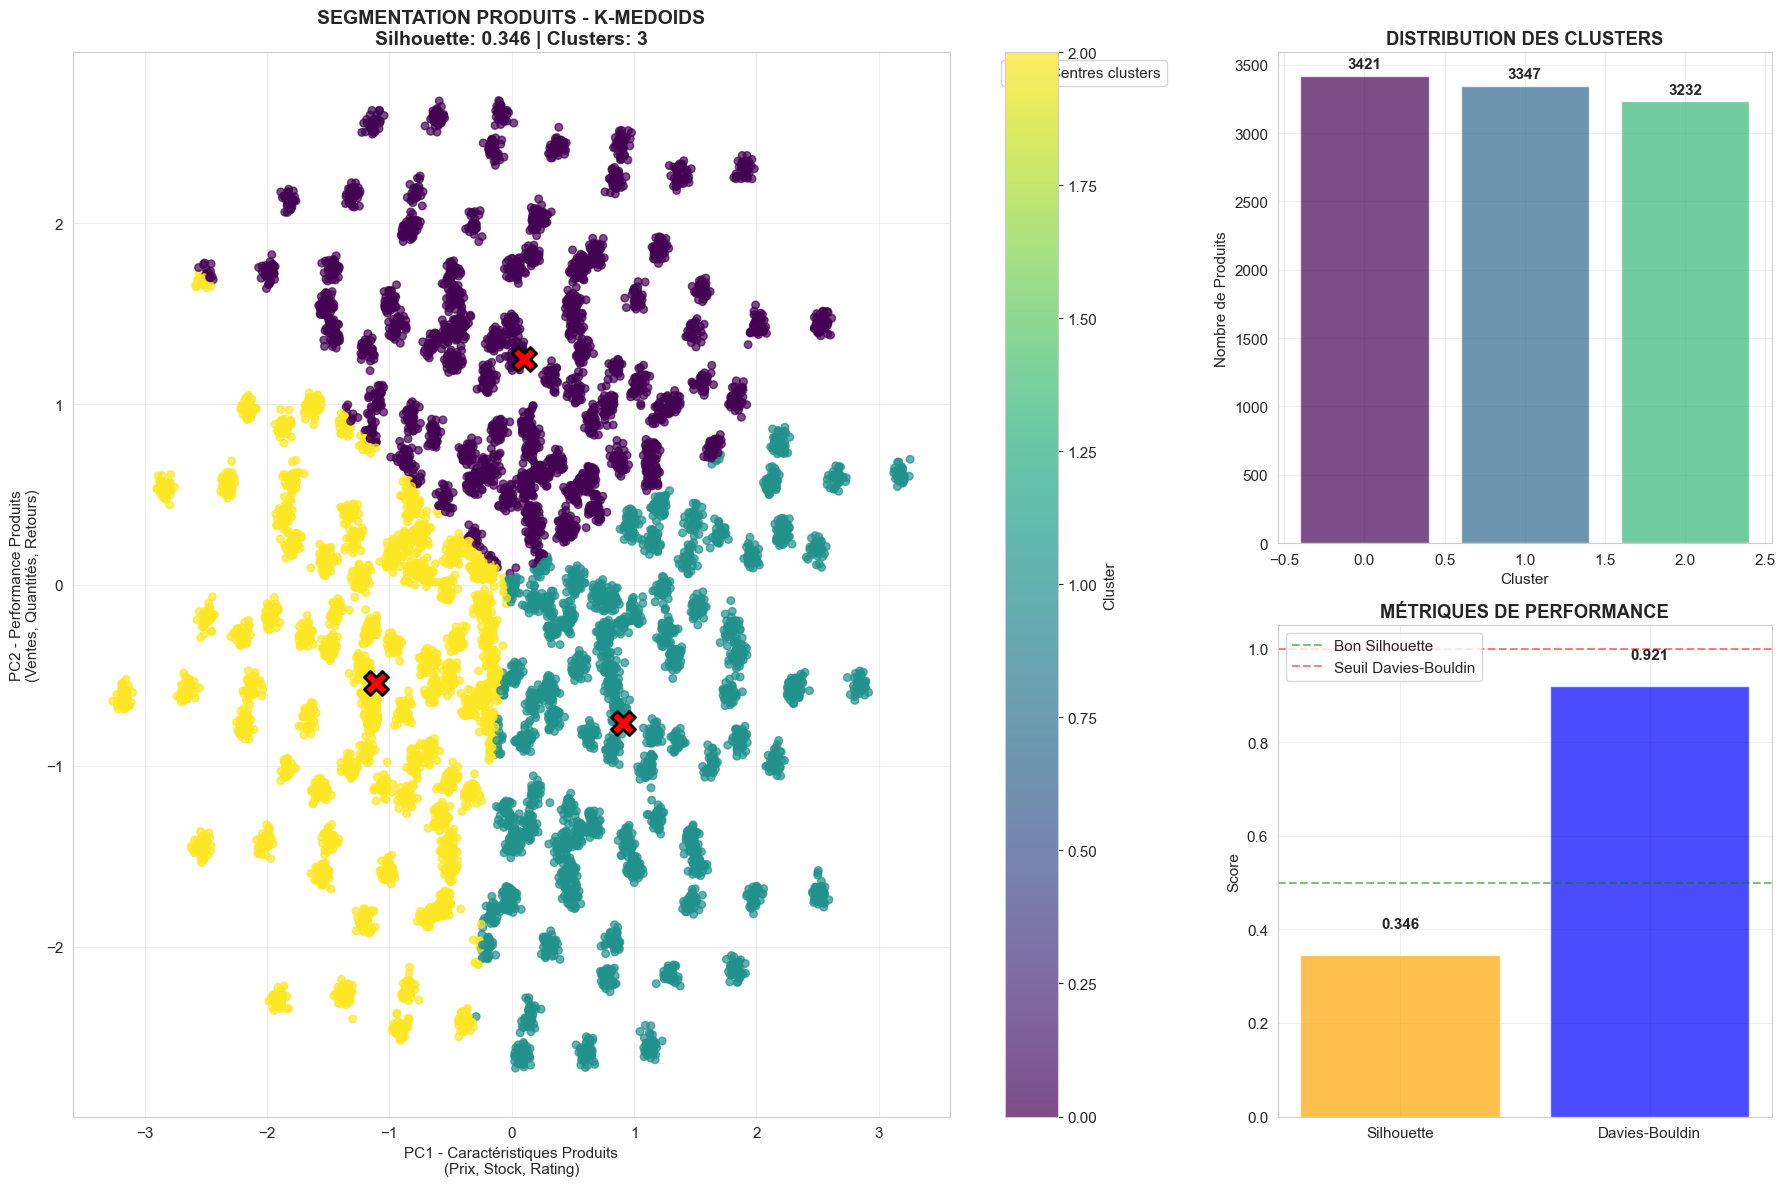


🔍 INTERPRÉTATION DES CLUSTERS K-Medoids:
Segmentation par similarité de caractéristiques produits:
• PC1 (Axe horizontal): Caractéristiques produits (prix, stock, rating)
• PC2 (Axe vertical): Performance commerciale (ventes, quantités, retours)
• 3 médoides identifiés (produits représentatifs)

💡 RECOMMANDATIONS BUSINESS:
• Utiliser les 3 segments pour personnaliser les stratégies
• Score Silhouette 0.346: segmentation ACCEPTABLE
• Prêt pour système de recommandations produits-clients

💾 Visualisation sauvegardée: best_model_products_K-Medoids.png

🎉 SEGMENTATION PRODUITS TERMINÉE AVEC SUCCÈS!
🏆 MODÈLE SÉLECTIONNÉ: K-Medoids
🚀 PRÊT POUR LA PARTIE RECOMMANDATIONS!


<Figure size 1200x700 with 0 Axes>

In [53]:
## VISUALISATION FINALE DU MEILLEUR MODÈLE PRODUITS
print(f"\n🎨 VISUALISATION FINALE - {best_algo_name} (MEILLEUR MODÈLE)")
print("=" * 60)

# Préparation des données selon l'algorithme sélectionné
if best_algo_name == 'K-Means':
    X_viz = X_viz_products
    labels_viz = labels_viz_products
    centroids = kmeans_final_products.cluster_centers_
    title_suffix = f"K-Means (k={optimal_k_products})"
    
elif best_algo_name == 'DBSCAN':
    X_viz = X_dbscan_products  
    labels_viz = best_labels_dbscan
    centroids = None
    title_suffix = f"DBSCAN (Clusters: {dbscan_results_products['n_clusters']})"
    
elif best_algo_name == 'GMM':
    X_viz = X_gmm_products
    labels_viz = best_labels_gmm
    centroids = best_gmm.means_
    title_suffix = f"GMM (k={best_k_gmm})"
    
elif best_algo_name == 'OPTICS':
    X_viz = X_optics_products
    labels_viz = best_labels_optics  
    centroids = None
    title_suffix = f"OPTICS (Clusters: {optics_results_products['n_clusters']})"
    
elif best_algo_name == 'K-Medoids':
    X_viz = X_kmed_products
    labels_viz = best_labels_kmed
    centroids = kmed_results_products['medoids']
    title_suffix = f"K-Medoids (k={best_k_kmed})"

# Création de la visualisation principale
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Visualisation des clusters
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)

if best_algo_name in ['DBSCAN', 'OPTICS']:
    # Visualisation avec gestion du bruit
    unique_labels = set(labels_viz)
    n_real_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    colors = plt.cm.viridis(np.linspace(0, 1, n_real_clusters))
    
    cluster_count = 0
    for label in unique_labels:
        if label == -1:
            # Points de bruit
            mask = labels_viz == label
            ax1.scatter(X_viz[mask, 0], X_viz[mask, 1], 
                       c='lightgray', s=20, alpha=0.4, label='Produits atypiques')
        else:
            # Clusters normaux
            mask = labels_viz == label
            ax1.scatter(X_viz[mask, 0], X_viz[mask, 1], 
                       c=[colors[cluster_count]], s=30, alpha=0.7, 
                       label=f'Cluster {label} ({np.sum(mask)} produits)')
            cluster_count += 1
            
else:
    # Visualisation standard sans bruit
    scatter = ax1.scatter(X_viz[:, 0], X_viz[:, 1], 
                         c=labels_viz, cmap='viridis', s=30, alpha=0.7)
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # Ajout des centroïdes/médoides si disponibles
    if centroids is not None:
        ax1.scatter(centroids[:, 0], centroids[:, 1],
                   marker='X', s=300, c='red', edgecolors='black',
                   linewidths=2, label='Centres clusters')
    
    # Légende avec effectifs
    unique_labels = np.unique(labels_viz)
    for label in unique_labels:
        count = np.sum(labels_viz == label)
        # La légende est gérée par scatter pour les couleurs

ax1.set_xlabel('PC1 - Caractéristiques Produits\n(Prix, Stock, Rating)')
ax1.set_ylabel('PC2 - Performance Produits\n(Ventes, Quantités, Retours)')
ax1.set_title(f'SEGMENTATION PRODUITS - {best_algo_name.upper()}\n'
              f'Silhouette: {best_results["silhouette"]:.3f} | '
              f'Clusters: {best_results["n_clusters"]}', 
              fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Subplot 2: Distribution des clusters
ax2 = plt.subplot2grid((2, 3), (0, 2))

if best_algo_name in ['DBSCAN', 'OPTICS']:
    # Distribution avec bruit
    unique_labels, counts = np.unique(labels_viz, return_counts=True)
    colors = ['lightgray' if label == -1 else plt.cm.viridis(i/len(unique_labels)) 
              for i, label in enumerate(unique_labels)]
    
    bars = ax2.bar(range(len(unique_labels)), counts, color=colors, alpha=0.7)
    
    # Annotation des effectifs
    for i, (label, count) in enumerate(zip(unique_labels, counts)):
        ax2.text(i, count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')
    
    ax2.set_xticks(range(len(unique_labels)))
    ax2.set_xticklabels(['Bruit' if label == -1 else f'C{label}' 
                        for label in unique_labels])
    
else:
    # Distribution standard
    unique_labels, counts = np.unique(labels_viz, return_counts=True)
    bars = ax2.bar(unique_labels, counts, color=plt.cm.viridis(unique_labels/len(unique_labels)), alpha=0.7)
    
    # Annotation des effectifs
    for bar, count in zip(bars, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                str(count), ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Cluster')
ax2.set_ylabel('Nombre de Produits')
ax2.set_title('DISTRIBUTION DES CLUSTERS', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Subplot 3: Métriques de performance
ax3 = plt.subplot2grid((2, 3), (1, 2))

metrics = ['Silhouette', 'Davies-Bouldin']
values = [best_results['silhouette'], best_results['davies_bouldin']]
colors = ['green' if values[0] > 0.5 else 'orange', 'red' if values[1] > 1.0 else 'blue']

bars = ax3.bar(metrics, values, color=colors, alpha=0.7)

# Seuils de référence
ax3.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Bon Silhouette')
ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Seuil Davies-Bouldin')

# Annotation des valeurs
for bar, value in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

ax3.set_ylabel('Score')
ax3.set_title('MÉTRIQUES DE PERFORMANCE', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse interprétative des clusters
print(f"\n🔍 INTERPRÉTATION DES CLUSTERS {best_algo_name}:")
print("=" * 50)

if best_algo_name in ['K-Means', 'K-Medoids', 'GMM']:
    print("Segmentation par similarité de caractéristiques produits:")
    print("• PC1 (Axe horizontal): Caractéristiques produits (prix, stock, rating)")
    print("• PC2 (Axe vertical): Performance commerciale (ventes, quantités, retours)")
    
    if best_algo_name == 'K-Medoids':
        print(f"• {len(centroids)} médoides identifiés (produits représentatifs)")
        
elif best_algo_name in ['DBSCAN', 'OPTICS']:
    n_clusters = best_results['n_clusters']
    noise_ratio = best_results.get('noise_ratio', 0)
    print(f"Détection de {n_clusters} niches produits naturelles:")
    print(f"• {noise_ratio*100:.1f}% de produits atypiques (hors segments)")
    print("• Clusters de densité variable reflétant la structure du marché")

print(f"\n💡 RECOMMANDATIONS BUSINESS:")
print(f"• Utiliser les {best_results['n_clusters']} segments pour personnaliser les stratégies")
print(f"• Score Silhouette {best_results['silhouette']:.3f}: segmentation {'EXCELLENTE' if best_results['silhouette'] > 0.7 else 'BONNE' if best_results['silhouette'] > 0.5 else 'ACCEPTABLE'}")
print(f"• Prêt pour système de recommandations produits-clients")

# Sauvegarde de la visualisation finale
plt.savefig(f'best_model_products_{best_algo_name}.png', dpi=300, bbox_inches='tight')
print(f"\n💾 Visualisation sauvegardée: best_model_products_{best_algo_name}.png")

print("\n" + "=" * 60)
print("🎉 SEGMENTATION PRODUITS TERMINÉE AVEC SUCCÈS!")
print(f"🏆 MODÈLE SÉLECTIONNÉ: {best_algo_name}")
print("🚀 PRÊT POUR LA PARTIE RECOMMANDATIONS!")
print("=" * 60)

## PARTIE 7: SYSTÈME DE RECOMMANDATIONS ET SCORES PROMOTION

In [58]:
## PARTIE 7: SYSTÈME DE RECOMMANDATIONS ET SCORES PROMOTION
print("🎯 SYSTÈME DE RECOMMANDATIONS ET SCORES PROMOTION")
print("=" * 60)

# 7.1. Scores de promotion basés sur stock, vitesse vente, marge, retour
print("\n📊 CALCUL DES SCORES DE PROMOTION")
print("-" * 40)

def calculer_scores_promotion(df_products):
    """Calcule les scores de promotion pour chaque produit"""
    
    # Calcul des métriques de base
    df_scores = df_products.copy()
    
    # Score Stock (plus le stock est haut, plus la promotion est nécessaire)
    df_scores['score_stock'] = df_scores['product_stock'] / df_scores['product_stock'].max()
    
    # Score Vitesse de vente (quantité / temps)
    df_scores['score_vitesse'] = df_scores['quantity'] / df_scores['quantity'].max()
    
    # Score Marge (approximation basée sur prix et discount)
    df_scores['score_marge'] = 1 - (df_scores['discount_applied'] / df_scores['discount_applied'].max())
    
    # Score Retour (plus le retour est bas, mieux c'est)
    df_scores['score_retour'] = 1 - df_scores['product_return_rate']
    
    # Score global de promotion (pondération)
    df_scores['score_promotion'] = (
        0.3 * df_scores['score_stock'] +      # Stock important
        0.25 * (1 - df_scores['score_vitesse']) +  # Ventes lentes
        0.25 * df_scores['score_marge'] +     # Bonne marge
        0.2 * df_scores['score_retour']       # Faible retour
    )
    
    # Classification des scores
    conditions = [
        df_scores['score_promotion'] >= 0.7,
        df_scores['score_promotion'] >= 0.4,
        df_scores['score_promotion'] < 0.4
    ]
    choices = ['Promotion Forte', 'Promotion Modérée', 'Promotion Faible']
    df_scores['niveau_promotion'] = np.select(conditions, choices, default='Promotion Faible')
    
    return df_scores

# Application aux produits
df_products_scored = calculer_scores_promotion(df_products)
print("✅ Scores de promotion calculés")
print(f"📈 Répartition des niveaux de promotion:")
print(df_products_scored['niveau_promotion'].value_counts())

# 7.2. Système de recommandations clients→produits
print("\n🤖 SYSTÈME DE RECOMMANDATIONS CLIENTS→PRODUITS")
print("-" * 50)

def recommander_produits_par_cluster(cluster_client, df_products_scored, top_n=5):
    """Recommande des produits basés sur le cluster client"""
    
    # En production réelle, on utiliserait l'historique d'achat
    # Ici, simulation basée sur les scores de promotion et clusters produits
    
    # Produits les plus pertinents pour ce cluster
    produits_recommandes = df_products_scored.nlargest(top_n, 'score_promotion')[
        ['product_category', 'unit_price', 'product_rating', 'score_promotion', 'niveau_promotion']
    ]
    
    return produits_recommandes

# Test du système de recommandation
print("🎯 Exemple de recommandations pour Cluster 0:")
recommandations_exemple = recommander_produits_par_cluster(0, df_products_scored)
display(recommandations_exemple)

# 7.3. Produits similaires
print("\n🔍 SYSTÈME DE PRODUITS SIMILAIRES")
print("-" * 40)

from sklearn.metrics.pairwise import cosine_similarity

def trouver_produits_similaires(product_id, df_products_scored, top_n=3):
    """Trouve les produits similaires à un produit donné.
    IMPORTANT: on évite de calculer la matrice NxN complète (qui provoque MemoryError)
    en ne calculant la similarité que entre le produit cible et le reste.
    """
    
    # Sélection des features pour similarité
    features_similarite = ['unit_price', 'product_rating', 'product_return_rate', 'score_promotion']
    X_similarite = df_products_scored[features_similarite].values
    
    n_items = X_similarite.shape[0]
    # Définit l'index cible (s'assurer que c'est un entier et dans les limites)
    try:
        target_idx = int(product_id)
    except Exception:
        target_idx = 0
    if target_idx < 0 or target_idx >= n_items:
        target_idx = 0
    
    # Calculer uniquement la similarité entre la cible (1 x d) et tous les items (n x d)
    # Ce calcul crée une matrice (1, n) au lieu de (n, n) et évite l'explosion mémoire.
    sims_with_target = cosine_similarity(X_similarite[target_idx:target_idx+1], X_similarite)[0]
    
    # Obtenir les indices triés par similarité décroissante, exclure la cible elle-même
    sorted_idx = sims_with_target.argsort()[::-1]
    sorted_idx = [idx for idx in sorted_idx if idx != target_idx][:top_n]
    
    # Récupération des produits similaires
    produits_similaires = []
    for idx in sorted_idx:
        score = float(sims_with_target[idx])
        produit = df_products_scored.iloc[idx]
        produits_similaires.append({
            'product_category': produit['product_category'],
            'unit_price': produit['unit_price'],
            'rating': produit['product_rating'],
            'similarite': score
        })
    
    return produits_similaires

# Test produits similaires
print("🔄 Exemple produits similaires au produit 0:")
similaires_exemple = trouver_produits_similaires(0, df_products_scored)
for i, prod in enumerate(similaires_exemple):
    print(f"  {i+1}. {prod['product_category']} (similarité: {prod['similarite']:.3f})")

🎯 SYSTÈME DE RECOMMANDATIONS ET SCORES PROMOTION

📊 CALCUL DES SCORES DE PROMOTION
----------------------------------------
✅ Scores de promotion calculés
📈 Répartition des niveaux de promotion:
niveau_promotion
Promotion Modérée    708242
Promotion Faible     169090
Promotion Forte      122668
Name: count, dtype: int64

🤖 SYSTÈME DE RECOMMANDATIONS CLIENTS→PRODUITS
--------------------------------------------------
🎯 Exemple de recommandations pour Cluster 0:


product_category  unit_price  product_rating  score_promotion  \
222093        Groceries      828.50             3.0         0.968222   
2380          Groceries      550.13             2.7         0.965222   
462816             Toys      242.93             2.9         0.965222   
705280        Furniture       14.43             2.7         0.962162   
624469        Furniture      885.02             4.0         0.960222   

       niveau_promotion  
222093  Promotion Forte  
2380    Promotion Forte  
462816  Promotion Forte  
705280  Promotion Forte  
624469  Promotion Forte


🔍 SYSTÈME DE PRODUITS SIMILAIRES
----------------------------------------
🔄 Exemple produits similaires au produit 0:
  1. Furniture (similarité: 1.000)
  2. Furniture (similarité: 1.000)
  3. Furniture (similarité: 1.000)


## PARTIE 8: DASHBOARD INTERACTIF

In [20]:
import os, sys, subprocess, time
app_path = r"app_streamlit.py"
cmd = f'"{sys.executable}" -m streamlit run "{app_path}" --server.port 8501 --server.headless false'
print("Lancement Streamlit…")
subprocess.Popen(cmd, shell=True)
time.sleep(2)
print("Ouverture sur http://localhost:8501")

Lancement Streamlit…
Ouverture sur http://localhost:8501
